***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las trayectorias con sus respectivas clases en "complete_df" :***

In [2]:
"""
csv_files = [
    "./Trayectorias/Tipos_de_barcos/longitud_8/Cargo_modificado_compressed_8.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Container_modificado_compressed_8.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Cruise_modificado_compressed_8.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Fishing_modificado_compressed_8.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Tanker_modificado_compressed_8.csv"
]
"""
csv_files = [
    "./Trayectorias/Tipos_de_barcos/longitud_28/Cargo_modificado_compressed_28_v2.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_28/Container_modificado_compressed_28_v2.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_28/Tanker_modificado_compressed_28_v2.csv"
]

complete_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    df['Bearing'] = df['Bearing'].round(4)
    grouped = df.groupby('Trajectory_ID')['Bearing'].apply(lambda x: [i for i in x if pd.notna(i)]).reset_index()
    grouped['Type'] = file.split('/')[-1].split('_')[0]
    complete_df = pd.concat([complete_df, grouped], ignore_index=True)

### COMPROBACIÓN BEARING ###
for tipo in complete_df['Type'].unique():
    first_element = complete_df[complete_df['Type'] == tipo].iloc[0]
    print(f"Type: {tipo}, Trajectory_ID: {first_element['Trajectory_ID']}, Bearing: {first_element['Bearing']}")

print()

### COMPROBACIÓN NÚMERO DE TRAYECTORIAS ###
print("Número total de trayectorias:", len(complete_df))
class_counts = complete_df['Type'].value_counts()
print(class_counts)

Type: Cargo, Trajectory_ID: 6, Bearing: [85.9813, 83.4948, 81.4367, 79.4248, 78.7669, 82.293, 84.1563, 86.5258, 82.196, 84.2905, 80.7255, 77.7342, 74.3326, 72.3342, 76.6374, 76.1252, 78.2791, 76.2551, 80.5085, 81.2342, 87.8038, 83.9483, 82.2021, 74.2397, 81.9476, 80.4048, 81.639]
Type: Container, Trajectory_ID: 24, Bearing: [79.0256, 83.3049, 86.553, 83.0474, 75.7304, 81.6789, 85.1362, 79.984, 78.463, 80.5605, 80.3212, 77.8201, 77.1404, 76.1251, 76.0628, 81.2343, 82.9812, 78.2018, 81.3787, 80.3007, 78.2253, 78.6548, 80.5155, 78.9224, 80.4505, 74.8486, 78.2525]
Type: Tanker, Trajectory_ID: 4, Bearing: [73.149, 84.7242, 80.3463, 75.5419, 80.2578, 83.564, 80.4332, 82.3601, 85.0705, 81.4655, 81.1754, 84.0992, 77.2338, 79.5903, 84.4041, 86.991, 79.4484, 77.106, 82.8404, 77.2214, 80.1858, 81.5052, 76.7469, 73.4563, 77.4019, 76.6975, 84.6507]

Número total de trayectorias: 955
Type
Cargo        648
Tanker       211
Container     96
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['Type'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['Type'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de trayectorias en train: {len(train_df)}")
print(train_df['Type'].value_counts())
print()
print(f"Nº de trayectorias en test: {len(test_df)}")
print(test_df['Type'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(5))
print()
print("Ejm. conjunto test:")
print(test_df.head(5))

Nº de trayectorias en train: 765
Type
Cargo        519
Tanker       169
Container     77
Name: count, dtype: int64

Nº de trayectorias en test: 190
Type
Cargo        129
Tanker        42
Container     19
Name: count, dtype: int64

Ejm. conjunto train:
   Trajectory_ID                                            Bearing    Type
0           1049  [64.0778, 63.9002, 63.2022, 75.3271, 74.916, 7...   Cargo
1            878  [41.6313, 67.0505, 49.6143, 64.8078, 53.1357, ...   Cargo
2            209  [14.1834, 338.1289, 21.4326, 110.865, 228.0552...  Tanker
3           1558  [59.8969, 62.7657, 67.7545, 58.733, 53.69, 39....   Cargo
4           1048  [351.5859, 312.7834, 311.723, 230.7689, 55.436...   Cargo

Ejm. conjunto test:
   Trajectory_ID                                            Bearing    Type
0           1155  [75.7382, 53.4513, 54.6615, 31.239, 28.5613, 4...  Tanker
1            974  [65.3321, 65.9314, 59.2055, 71.8668, 39.6723, ...  Tanker
2            553  [76.4694, 72.0284, 72.938

***Pre-procesado de los datos :***

In [4]:
#Convertimos Bearing a un array de numpy
X_train = np.array(train_df['Bearing'].tolist())
X_test = np.array(test_df['Bearing'].tolist())

#Normalizamos los valores de Bearing
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Añadimos una dimensión extra para que tenga la forma (n, 1)
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)

#Codificamos las etiquetas de Type
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Type'])
y_test = label_encoder.transform(test_df['Type'])

#Conversión a tensores
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)

Device: cuda
X_train: torch.Size([765, 1, 27]) cuda:0
y_train: torch.Size([765]) cuda:0
X_test: torch.Size([190, 1, 27]) cuda:0
y_test: torch.Size([190]) cuda:0


# ***CNN1D :***

In [5]:
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (X_train.shape[2] // 4), 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

***Configuración del modelo :***

In [6]:
k_folds = 5
batch_size = 32
num_epochs = 200
num_classes = 3

***Entrenamiento del modelo :***

In [7]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = CNN1D(num_classes=num_classes).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v2/representacion_1/longitud_28"
        os.makedirs(save_path, exist_ok=True)
        torch.save(model.state_dict(), f"{save_path}/CNN1D_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/200: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Fold 1 - Epoch 1 ✅ | Train Acc: 22.06% - Train Loss: 1.0927 | Val Acc: 73.20% - Val Loss: 1.0682


Fold 1 | Epoch 2/200: 100%|██████████| 20/20 [00:00<00:00, 123.93it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 47.55% - Train Loss: 1.0875 | Val Acc: 34.64% - Val Loss: 1.0644


Fold 1 | Epoch 3/200: 100%|██████████| 20/20 [00:00<00:00, 116.57it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 30.72% - Train Loss: 1.0626 | Val Acc: 34.64% - Val Loss: 1.0502


Fold 1 | Epoch 4/200: 100%|██████████| 20/20 [00:00<00:00, 82.00it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 27.61% - Train Loss: 1.0322 | Val Acc: 22.22% - Val Loss: 1.0534


Fold 1 | Epoch 5/200: 100%|██████████| 20/20 [00:00<00:00, 85.37it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 28.27% - Train Loss: 1.0353 | Val Acc: 22.22% - Val Loss: 1.0657


Fold 1 | Epoch 6/200: 100%|██████████| 20/20 [00:00<00:00, 89.65it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 28.59% - Train Loss: 1.0217 | Val Acc: 22.22% - Val Loss: 1.0584


Fold 1 | Epoch 7/200: 100%|██████████| 20/20 [00:00<00:00, 87.42it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 28.27% - Train Loss: 1.0155 | Val Acc: 22.22% - Val Loss: 1.0773


Fold 1 | Epoch 8/200: 100%|██████████| 20/20 [00:00<00:00, 78.13it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 32.35% - Train Loss: 1.0078 | Val Acc: 28.10% - Val Loss: 1.0600


Fold 1 | Epoch 9/200: 100%|██████████| 20/20 [00:00<00:00, 95.81it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 35.95% - Train Loss: 1.0330 | Val Acc: 22.22% - Val Loss: 1.1172


Fold 1 | Epoch 10/200: 100%|██████████| 20/20 [00:00<00:00, 229.89it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 30.39% - Train Loss: 0.9983 | Val Acc: 35.95% - Val Loss: 1.0240


Fold 1 | Epoch 11/200: 100%|██████████| 20/20 [00:00<00:00, 116.63it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 35.13% - Train Loss: 1.0127 | Val Acc: 22.22% - Val Loss: 1.0907


Fold 1 | Epoch 12/200: 100%|██████████| 20/20 [00:00<00:00, 89.35it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 29.58% - Train Loss: 0.9995 | Val Acc: 28.76% - Val Loss: 1.0754


Fold 1 | Epoch 13/200: 100%|██████████| 20/20 [00:00<00:00, 89.59it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 34.48% - Train Loss: 0.9875 | Val Acc: 39.22% - Val Loss: 1.0587


Fold 1 | Epoch 14/200: 100%|██████████| 20/20 [00:00<00:00, 81.63it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 42.16% - Train Loss: 0.9761 | Val Acc: 27.45% - Val Loss: 1.1390


Fold 1 | Epoch 15/200: 100%|██████████| 20/20 [00:00<00:00, 80.52it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 41.67% - Train Loss: 0.9860 | Val Acc: 56.21% - Val Loss: 1.0548


Fold 1 | Epoch 16/200: 100%|██████████| 20/20 [00:00<00:00, 83.93it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 35.78% - Train Loss: 0.9836 | Val Acc: 39.87% - Val Loss: 1.0501


Fold 1 | Epoch 17/200: 100%|██████████| 20/20 [00:00<00:00, 76.99it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 43.30% - Train Loss: 0.9592 | Val Acc: 54.90% - Val Loss: 1.0784


Fold 1 | Epoch 18/200: 100%|██████████| 20/20 [00:00<00:00, 83.38it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 49.67% - Train Loss: 0.9317 | Val Acc: 37.91% - Val Loss: 1.1451


Fold 1 | Epoch 19/200: 100%|██████████| 20/20 [00:00<00:00, 82.98it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 48.04% - Train Loss: 0.9498 | Val Acc: 39.22% - Val Loss: 1.1561


Fold 1 | Epoch 20/200: 100%|██████████| 20/20 [00:00<00:00, 81.90it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 43.63% - Train Loss: 0.9488 | Val Acc: 41.18% - Val Loss: 1.1602


Fold 1 | Epoch 21/200: 100%|██████████| 20/20 [00:00<00:00, 83.45it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 44.93% - Train Loss: 0.9528 | Val Acc: 37.25% - Val Loss: 1.1016


Fold 1 | Epoch 22/200: 100%|██████████| 20/20 [00:00<00:00, 84.41it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 45.26% - Train Loss: 0.9427 | Val Acc: 39.87% - Val Loss: 1.1925


Fold 1 | Epoch 23/200: 100%|██████████| 20/20 [00:00<00:00, 84.50it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 50.65% - Train Loss: 0.9403 | Val Acc: 37.91% - Val Loss: 1.1840


Fold 1 | Epoch 24/200: 100%|██████████| 20/20 [00:00<00:00, 85.70it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 44.61% - Train Loss: 0.9297 | Val Acc: 41.18% - Val Loss: 1.1701


Fold 1 | Epoch 25/200: 100%|██████████| 20/20 [00:00<00:00, 84.69it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 48.37% - Train Loss: 0.9239 | Val Acc: 41.18% - Val Loss: 1.2130


Fold 1 | Epoch 26/200: 100%|██████████| 20/20 [00:00<00:00, 81.27it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 49.67% - Train Loss: 0.9405 | Val Acc: 38.56% - Val Loss: 1.2067


Fold 1 | Epoch 27/200: 100%|██████████| 20/20 [00:00<00:00, 78.27it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 49.02% - Train Loss: 0.9347 | Val Acc: 44.44% - Val Loss: 1.2254


Fold 1 | Epoch 28/200: 100%|██████████| 20/20 [00:00<00:00, 88.39it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 49.84% - Train Loss: 0.9150 | Val Acc: 40.52% - Val Loss: 1.2643


Fold 1 | Epoch 29/200: 100%|██████████| 20/20 [00:00<00:00, 82.77it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 48.86% - Train Loss: 0.9031 | Val Acc: 38.56% - Val Loss: 1.1528


Fold 1 | Epoch 30/200: 100%|██████████| 20/20 [00:00<00:00, 83.98it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 46.90% - Train Loss: 0.8957 | Val Acc: 55.56% - Val Loss: 1.2775


Fold 1 | Epoch 31/200: 100%|██████████| 20/20 [00:00<00:00, 77.86it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 51.63% - Train Loss: 0.9043 | Val Acc: 37.91% - Val Loss: 1.2604


Fold 1 | Epoch 32/200: 100%|██████████| 20/20 [00:00<00:00, 205.85it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 50.98% - Train Loss: 0.9135 | Val Acc: 55.56% - Val Loss: 1.2334


Fold 1 | Epoch 33/200: 100%|██████████| 20/20 [00:00<00:00, 197.05it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 54.08% - Train Loss: 0.9108 | Val Acc: 38.56% - Val Loss: 1.2863


Fold 1 | Epoch 34/200: 100%|██████████| 20/20 [00:00<00:00, 160.45it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 49.51% - Train Loss: 0.8900 | Val Acc: 44.44% - Val Loss: 1.2985


Fold 1 | Epoch 35/200: 100%|██████████| 20/20 [00:00<00:00, 201.91it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 47.39% - Train Loss: 0.9184 | Val Acc: 41.18% - Val Loss: 1.3320


Fold 1 | Epoch 36/200: 100%|██████████| 20/20 [00:00<00:00, 163.14it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 50.65% - Train Loss: 0.8977 | Val Acc: 41.18% - Val Loss: 1.3328


Fold 1 | Epoch 37/200: 100%|██████████| 20/20 [00:00<00:00, 201.95it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 49.67% - Train Loss: 0.8815 | Val Acc: 41.18% - Val Loss: 1.3874


Fold 1 | Epoch 38/200: 100%|██████████| 20/20 [00:00<00:00, 160.26it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 48.20% - Train Loss: 0.9132 | Val Acc: 37.25% - Val Loss: 1.4238


Fold 1 | Epoch 39/200: 100%|██████████| 20/20 [00:00<00:00, 233.81it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 47.88% - Train Loss: 0.8857 | Val Acc: 43.79% - Val Loss: 1.3945


Fold 1 | Epoch 40/200: 100%|██████████| 20/20 [00:00<00:00, 205.87it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 50.65% - Train Loss: 0.8983 | Val Acc: 39.87% - Val Loss: 1.3882


Fold 1 | Epoch 41/200: 100%|██████████| 20/20 [00:00<00:00, 213.25it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 48.20% - Train Loss: 0.8988 | Val Acc: 40.52% - Val Loss: 1.4441


Fold 1 | Epoch 42/200: 100%|██████████| 20/20 [00:00<00:00, 209.35it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 50.82% - Train Loss: 0.8872 | Val Acc: 41.18% - Val Loss: 1.4731


Fold 1 | Epoch 43/200: 100%|██████████| 20/20 [00:00<00:00, 245.12it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 46.41% - Train Loss: 0.8722 | Val Acc: 41.18% - Val Loss: 1.4375


Fold 1 | Epoch 44/200: 100%|██████████| 20/20 [00:00<00:00, 217.58it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 47.88% - Train Loss: 0.8920 | Val Acc: 40.52% - Val Loss: 1.5370


Fold 1 | Epoch 45/200: 100%|██████████| 20/20 [00:00<00:00, 198.45it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 51.14% - Train Loss: 0.8816 | Val Acc: 40.52% - Val Loss: 1.5157


Fold 1 | Epoch 46/200: 100%|██████████| 20/20 [00:00<00:00, 205.41it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 51.63% - Train Loss: 0.8671 | Val Acc: 41.18% - Val Loss: 1.6088


Fold 1 | Epoch 47/200: 100%|██████████| 20/20 [00:00<00:00, 206.06it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 49.35% - Train Loss: 0.8729 | Val Acc: 39.22% - Val Loss: 1.6104


Fold 1 | Epoch 48/200: 100%|██████████| 20/20 [00:00<00:00, 245.34it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 48.69% - Train Loss: 0.8783 | Val Acc: 40.52% - Val Loss: 1.6699


Fold 1 | Epoch 49/200: 100%|██████████| 20/20 [00:00<00:00, 217.27it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 50.49% - Train Loss: 0.8898 | Val Acc: 38.56% - Val Loss: 1.5738


Fold 1 | Epoch 50/200: 100%|██████████| 20/20 [00:00<00:00, 255.84it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 50.33% - Train Loss: 0.9048 | Val Acc: 39.22% - Val Loss: 1.6469


Fold 1 | Epoch 51/200: 100%|██████████| 20/20 [00:00<00:00, 167.15it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 39.38% - Train Loss: 0.9235 | Val Acc: 37.91% - Val Loss: 1.7348


Fold 1 | Epoch 52/200: 100%|██████████| 20/20 [00:00<00:00, 191.48it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 48.53% - Train Loss: 0.8909 | Val Acc: 40.52% - Val Loss: 1.6409


Fold 1 | Epoch 53/200: 100%|██████████| 20/20 [00:00<00:00, 240.19it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 50.98% - Train Loss: 0.8952 | Val Acc: 40.52% - Val Loss: 1.7403


Fold 1 | Epoch 54/200: 100%|██████████| 20/20 [00:00<00:00, 260.45it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 48.69% - Train Loss: 0.8739 | Val Acc: 40.52% - Val Loss: 1.6789


Fold 1 | Epoch 55/200: 100%|██████████| 20/20 [00:00<00:00, 239.73it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 49.35% - Train Loss: 0.8663 | Val Acc: 39.87% - Val Loss: 1.8123


Fold 1 | Epoch 56/200: 100%|██████████| 20/20 [00:00<00:00, 240.17it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 50.82% - Train Loss: 0.8924 | Val Acc: 40.52% - Val Loss: 1.5975


Fold 1 | Epoch 57/200: 100%|██████████| 20/20 [00:00<00:00, 239.94it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 50.98% - Train Loss: 0.8572 | Val Acc: 39.22% - Val Loss: 1.7904


Fold 1 | Epoch 58/200: 100%|██████████| 20/20 [00:00<00:00, 239.73it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 45.75% - Train Loss: 0.8815 | Val Acc: 39.22% - Val Loss: 1.7842


Fold 1 | Epoch 59/200: 100%|██████████| 20/20 [00:00<00:00, 240.41it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 50.98% - Train Loss: 0.8419 | Val Acc: 39.22% - Val Loss: 1.8199


Fold 1 | Epoch 60/200: 100%|██████████| 20/20 [00:00<00:00, 240.38it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 47.88% - Train Loss: 0.8641 | Val Acc: 39.87% - Val Loss: 1.8127


Fold 1 | Epoch 61/200: 100%|██████████| 20/20 [00:00<00:00, 209.25it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 50.82% - Train Loss: 0.8561 | Val Acc: 39.87% - Val Loss: 1.7919


Fold 1 | Epoch 62/200: 100%|██████████| 20/20 [00:00<00:00, 205.87it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 48.37% - Train Loss: 0.8491 | Val Acc: 45.10% - Val Loss: 1.9309


Fold 1 | Epoch 63/200: 100%|██████████| 20/20 [00:00<00:00, 255.97it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 54.08% - Train Loss: 0.8645 | Val Acc: 36.60% - Val Loss: 1.8184


Fold 1 | Epoch 64/200: 100%|██████████| 20/20 [00:00<00:00, 279.21it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 44.61% - Train Loss: 0.8695 | Val Acc: 40.52% - Val Loss: 1.8859


Fold 1 | Epoch 65/200: 100%|██████████| 20/20 [00:00<00:00, 245.25it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 45.26% - Train Loss: 0.8674 | Val Acc: 38.56% - Val Loss: 1.9048


Fold 1 | Epoch 66/200: 100%|██████████| 20/20 [00:00<00:00, 188.42it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 49.35% - Train Loss: 0.8646 | Val Acc: 39.87% - Val Loss: 1.9251


Fold 1 | Epoch 67/200: 100%|██████████| 20/20 [00:00<00:00, 197.48it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 45.75% - Train Loss: 0.8644 | Val Acc: 39.87% - Val Loss: 1.9546


Fold 1 | Epoch 68/200: 100%|██████████| 20/20 [00:00<00:00, 202.05it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 50.98% - Train Loss: 0.8384 | Val Acc: 38.56% - Val Loss: 1.9139


Fold 1 | Epoch 69/200: 100%|██████████| 20/20 [00:00<00:00, 201.63it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 47.55% - Train Loss: 0.8614 | Val Acc: 39.22% - Val Loss: 1.9845


Fold 1 | Epoch 70/200: 100%|██████████| 20/20 [00:00<00:00, 235.13it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 52.45% - Train Loss: 0.8720 | Val Acc: 39.22% - Val Loss: 1.9910


Fold 1 | Epoch 71/200: 100%|██████████| 20/20 [00:00<00:00, 191.80it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 52.78% - Train Loss: 0.8557 | Val Acc: 39.22% - Val Loss: 2.0099


Fold 1 | Epoch 72/200: 100%|██████████| 20/20 [00:00<00:00, 225.51it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 49.84% - Train Loss: 0.8496 | Val Acc: 39.87% - Val Loss: 1.9804


Fold 1 | Epoch 73/200: 100%|██████████| 20/20 [00:00<00:00, 195.10it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 49.02% - Train Loss: 0.8694 | Val Acc: 40.52% - Val Loss: 2.0546


Fold 1 | Epoch 74/200: 100%|██████████| 20/20 [00:00<00:00, 270.14it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 47.06% - Train Loss: 0.8480 | Val Acc: 39.87% - Val Loss: 2.0323


Fold 1 | Epoch 75/200: 100%|██████████| 20/20 [00:00<00:00, 281.12it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 54.25% - Train Loss: 0.8243 | Val Acc: 45.75% - Val Loss: 2.0568


Fold 1 | Epoch 76/200: 100%|██████████| 20/20 [00:00<00:00, 225.96it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 52.12% - Train Loss: 0.8128 | Val Acc: 38.56% - Val Loss: 2.1070


Fold 1 | Epoch 77/200: 100%|██████████| 20/20 [00:00<00:00, 206.07it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 52.94% - Train Loss: 0.8569 | Val Acc: 40.52% - Val Loss: 2.0861


Fold 1 | Epoch 78/200: 100%|██████████| 20/20 [00:00<00:00, 191.13it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 50.82% - Train Loss: 0.8269 | Val Acc: 39.22% - Val Loss: 2.1646


Fold 1 | Epoch 79/200: 100%|██████████| 20/20 [00:00<00:00, 239.99it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 49.84% - Train Loss: 0.8309 | Val Acc: 43.79% - Val Loss: 2.2519


Fold 1 | Epoch 80/200: 100%|██████████| 20/20 [00:00<00:00, 188.68it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 53.27% - Train Loss: 0.8607 | Val Acc: 37.91% - Val Loss: 2.0180


Fold 1 | Epoch 81/200: 100%|██████████| 20/20 [00:00<00:00, 187.88it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 51.80% - Train Loss: 0.8542 | Val Acc: 39.22% - Val Loss: 2.1477


Fold 1 | Epoch 82/200: 100%|██████████| 20/20 [00:00<00:00, 203.20it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 49.35% - Train Loss: 0.8483 | Val Acc: 38.56% - Val Loss: 2.1445


Fold 1 | Epoch 83/200: 100%|██████████| 20/20 [00:00<00:00, 231.01it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 49.67% - Train Loss: 0.8121 | Val Acc: 41.83% - Val Loss: 2.1326


Fold 1 | Epoch 84/200: 100%|██████████| 20/20 [00:00<00:00, 213.18it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 51.47% - Train Loss: 0.8240 | Val Acc: 38.56% - Val Loss: 2.1428


Fold 1 | Epoch 85/200: 100%|██████████| 20/20 [00:00<00:00, 254.74it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 50.33% - Train Loss: 0.8209 | Val Acc: 38.56% - Val Loss: 2.2205


Fold 1 | Epoch 86/200: 100%|██████████| 20/20 [00:00<00:00, 267.78it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 50.49% - Train Loss: 0.8458 | Val Acc: 39.22% - Val Loss: 2.1846


Fold 1 | Epoch 87/200: 100%|██████████| 20/20 [00:00<00:00, 245.18it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 51.63% - Train Loss: 0.8321 | Val Acc: 37.25% - Val Loss: 2.2285


Fold 1 | Epoch 88/200: 100%|██████████| 20/20 [00:00<00:00, 245.18it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 48.86% - Train Loss: 0.8314 | Val Acc: 37.91% - Val Loss: 2.3885


Fold 1 | Epoch 89/200: 100%|██████████| 20/20 [00:00<00:00, 191.69it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 54.08% - Train Loss: 0.8384 | Val Acc: 35.95% - Val Loss: 2.2233


Fold 1 | Epoch 90/200: 100%|██████████| 20/20 [00:00<00:00, 191.16it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 50.65% - Train Loss: 0.8326 | Val Acc: 40.52% - Val Loss: 2.2583


Fold 1 | Epoch 91/200: 100%|██████████| 20/20 [00:00<00:00, 198.39it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 51.31% - Train Loss: 0.8347 | Val Acc: 43.79% - Val Loss: 2.3908


Fold 1 | Epoch 92/200: 100%|██████████| 20/20 [00:00<00:00, 233.97it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 50.82% - Train Loss: 0.8397 | Val Acc: 39.22% - Val Loss: 2.3014


Fold 1 | Epoch 93/200: 100%|██████████| 20/20 [00:00<00:00, 245.27it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 52.94% - Train Loss: 0.8155 | Val Acc: 37.25% - Val Loss: 2.4002


Fold 1 | Epoch 94/200: 100%|██████████| 20/20 [00:00<00:00, 213.07it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 51.80% - Train Loss: 0.8414 | Val Acc: 39.87% - Val Loss: 2.3586


Fold 1 | Epoch 95/200: 100%|██████████| 20/20 [00:00<00:00, 226.25it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 51.63% - Train Loss: 0.8432 | Val Acc: 35.95% - Val Loss: 2.4024


Fold 1 | Epoch 96/200: 100%|██████████| 20/20 [00:00<00:00, 240.17it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 51.31% - Train Loss: 0.8297 | Val Acc: 35.95% - Val Loss: 2.3392


Fold 1 | Epoch 97/200: 100%|██████████| 20/20 [00:00<00:00, 234.52it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 46.57% - Train Loss: 0.8302 | Val Acc: 37.25% - Val Loss: 2.4816


Fold 1 | Epoch 98/200: 100%|██████████| 20/20 [00:00<00:00, 230.29it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 54.74% - Train Loss: 0.7931 | Val Acc: 35.29% - Val Loss: 2.3370


Fold 1 | Epoch 99/200: 100%|██████████| 20/20 [00:00<00:00, 202.32it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 48.20% - Train Loss: 0.8088 | Val Acc: 46.41% - Val Loss: 2.6720


Fold 1 | Epoch 100/200: 100%|██████████| 20/20 [00:00<00:00, 217.48it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 51.31% - Train Loss: 0.8328 | Val Acc: 36.60% - Val Loss: 2.2077


Fold 1 | Epoch 101/200: 100%|██████████| 20/20 [00:00<00:00, 234.98it/s]


Fold 1 - Epoch 101 ✅ | Train Acc: 54.25% - Train Loss: 0.8278 | Val Acc: 36.60% - Val Loss: 1.8972


Fold 1 | Epoch 102/200: 100%|██████████| 20/20 [00:00<00:00, 230.64it/s]


Fold 1 - Epoch 102 ✅ | Train Acc: 50.16% - Train Loss: 0.8228 | Val Acc: 41.83% - Val Loss: 2.4478


Fold 1 | Epoch 103/200: 100%|██████████| 20/20 [00:00<00:00, 221.98it/s]


Fold 1 - Epoch 103 ✅ | Train Acc: 53.76% - Train Loss: 0.8223 | Val Acc: 36.60% - Val Loss: 2.1797


Fold 1 | Epoch 104/200: 100%|██████████| 20/20 [00:00<00:00, 205.81it/s]


Fold 1 - Epoch 104 ✅ | Train Acc: 52.78% - Train Loss: 0.8206 | Val Acc: 45.10% - Val Loss: 2.3927


Fold 1 | Epoch 105/200: 100%|██████████| 20/20 [00:00<00:00, 205.85it/s]


Fold 1 - Epoch 105 ✅ | Train Acc: 54.90% - Train Loss: 0.8058 | Val Acc: 37.25% - Val Loss: 2.4115


Fold 1 | Epoch 106/200: 100%|██████████| 20/20 [00:00<00:00, 206.87it/s]


Fold 1 - Epoch 106 ✅ | Train Acc: 46.57% - Train Loss: 0.8408 | Val Acc: 37.25% - Val Loss: 2.4915


Fold 1 | Epoch 107/200: 100%|██████████| 20/20 [00:00<00:00, 192.83it/s]


Fold 1 - Epoch 107 ✅ | Train Acc: 56.05% - Train Loss: 0.7979 | Val Acc: 39.87% - Val Loss: 2.3931


Fold 1 | Epoch 108/200: 100%|██████████| 20/20 [00:00<00:00, 179.96it/s]


Fold 1 - Epoch 108 ✅ | Train Acc: 53.92% - Train Loss: 0.7967 | Val Acc: 38.56% - Val Loss: 2.5317


Fold 1 | Epoch 109/200: 100%|██████████| 20/20 [00:00<00:00, 179.49it/s]


Fold 1 - Epoch 109 ✅ | Train Acc: 54.08% - Train Loss: 0.8017 | Val Acc: 43.14% - Val Loss: 2.4480


Fold 1 | Epoch 110/200: 100%|██████████| 20/20 [00:00<00:00, 205.85it/s]


Fold 1 - Epoch 110 ✅ | Train Acc: 52.45% - Train Loss: 0.7823 | Val Acc: 39.22% - Val Loss: 2.5316


Fold 1 | Epoch 111/200: 100%|██████████| 20/20 [00:00<00:00, 239.86it/s]


Fold 1 - Epoch 111 ✅ | Train Acc: 50.65% - Train Loss: 0.7955 | Val Acc: 42.48% - Val Loss: 2.5835


Fold 1 | Epoch 112/200: 100%|██████████| 20/20 [00:00<00:00, 221.55it/s]


Fold 1 - Epoch 112 ✅ | Train Acc: 52.45% - Train Loss: 0.8361 | Val Acc: 37.91% - Val Loss: 2.5753


Fold 1 | Epoch 113/200: 100%|██████████| 20/20 [00:00<00:00, 220.60it/s]


Fold 1 - Epoch 113 ✅ | Train Acc: 54.41% - Train Loss: 0.7722 | Val Acc: 40.52% - Val Loss: 2.5404


Fold 1 | Epoch 114/200: 100%|██████████| 20/20 [00:00<00:00, 205.86it/s]


Fold 1 - Epoch 114 ✅ | Train Acc: 53.59% - Train Loss: 0.8043 | Val Acc: 37.25% - Val Loss: 2.7038


Fold 1 | Epoch 115/200: 100%|██████████| 20/20 [00:00<00:00, 221.22it/s]


Fold 1 - Epoch 115 ✅ | Train Acc: 54.08% - Train Loss: 0.8062 | Val Acc: 41.18% - Val Loss: 2.7007


Fold 1 | Epoch 116/200: 100%|██████████| 20/20 [00:00<00:00, 205.53it/s]


Fold 1 - Epoch 116 ✅ | Train Acc: 51.47% - Train Loss: 0.8111 | Val Acc: 35.95% - Val Loss: 2.6557


Fold 1 | Epoch 117/200: 100%|██████████| 20/20 [00:00<00:00, 240.43it/s]


Fold 1 - Epoch 117 ✅ | Train Acc: 55.72% - Train Loss: 0.7830 | Val Acc: 36.60% - Val Loss: 2.6718


Fold 1 | Epoch 118/200: 100%|██████████| 20/20 [00:00<00:00, 205.71it/s]


Fold 1 - Epoch 118 ✅ | Train Acc: 51.80% - Train Loss: 0.7721 | Val Acc: 47.06% - Val Loss: 2.8111


Fold 1 | Epoch 119/200: 100%|██████████| 20/20 [00:00<00:00, 241.19it/s]


Fold 1 - Epoch 119 ✅ | Train Acc: 54.74% - Train Loss: 0.8134 | Val Acc: 35.29% - Val Loss: 2.6108


Fold 1 | Epoch 120/200: 100%|██████████| 20/20 [00:00<00:00, 261.89it/s]


Fold 1 - Epoch 120 ✅ | Train Acc: 53.76% - Train Loss: 0.8007 | Val Acc: 38.56% - Val Loss: 2.7803


Fold 1 | Epoch 121/200: 100%|██████████| 20/20 [00:00<00:00, 99.10it/s]


Fold 1 - Epoch 121 ✅ | Train Acc: 56.70% - Train Loss: 0.7871 | Val Acc: 37.25% - Val Loss: 2.7200


Fold 1 | Epoch 122/200: 100%|██████████| 20/20 [00:00<00:00, 92.54it/s]


Fold 1 - Epoch 122 ✅ | Train Acc: 52.78% - Train Loss: 0.7679 | Val Acc: 43.14% - Val Loss: 2.8427


Fold 1 | Epoch 123/200: 100%|██████████| 20/20 [00:00<00:00, 79.97it/s]


Fold 1 - Epoch 123 ✅ | Train Acc: 55.23% - Train Loss: 0.8014 | Val Acc: 40.52% - Val Loss: 2.8513


Fold 1 | Epoch 124/200: 100%|██████████| 20/20 [00:00<00:00, 80.08it/s]


Fold 1 - Epoch 124 ✅ | Train Acc: 55.56% - Train Loss: 0.7698 | Val Acc: 44.44% - Val Loss: 2.9276


Fold 1 | Epoch 125/200: 100%|██████████| 20/20 [00:00<00:00, 87.42it/s]


Fold 1 - Epoch 125 ✅ | Train Acc: 57.84% - Train Loss: 0.7941 | Val Acc: 36.60% - Val Loss: 2.6571


Fold 1 | Epoch 126/200: 100%|██████████| 20/20 [00:00<00:00, 87.71it/s]


Fold 1 - Epoch 126 ✅ | Train Acc: 53.76% - Train Loss: 0.7785 | Val Acc: 43.79% - Val Loss: 2.8269


Fold 1 | Epoch 127/200: 100%|██████████| 20/20 [00:00<00:00, 87.80it/s]


Fold 1 - Epoch 127 ✅ | Train Acc: 57.68% - Train Loss: 0.8020 | Val Acc: 37.25% - Val Loss: 2.8274


Fold 1 | Epoch 128/200: 100%|██████████| 20/20 [00:00<00:00, 207.86it/s]


Fold 1 - Epoch 128 ✅ | Train Acc: 54.08% - Train Loss: 0.7625 | Val Acc: 41.83% - Val Loss: 2.8251


Fold 1 | Epoch 129/200: 100%|██████████| 20/20 [00:00<00:00, 222.89it/s]


Fold 1 - Epoch 129 ✅ | Train Acc: 56.54% - Train Loss: 0.7686 | Val Acc: 38.56% - Val Loss: 2.8015


Fold 1 | Epoch 130/200: 100%|██████████| 20/20 [00:00<00:00, 221.22it/s]


Fold 1 - Epoch 130 ✅ | Train Acc: 56.54% - Train Loss: 0.7822 | Val Acc: 37.25% - Val Loss: 2.8874


Fold 1 | Epoch 131/200: 100%|██████████| 20/20 [00:00<00:00, 221.19it/s]


Fold 1 - Epoch 131 ✅ | Train Acc: 50.16% - Train Loss: 0.7959 | Val Acc: 50.33% - Val Loss: 3.0907


Fold 1 | Epoch 132/200: 100%|██████████| 20/20 [00:00<00:00, 191.48it/s]


Fold 1 - Epoch 132 ✅ | Train Acc: 53.76% - Train Loss: 0.8010 | Val Acc: 34.64% - Val Loss: 2.6669


Fold 1 | Epoch 133/200: 100%|██████████| 20/20 [00:00<00:00, 76.36it/s]


Fold 1 - Epoch 133 ✅ | Train Acc: 55.07% - Train Loss: 0.7831 | Val Acc: 41.83% - Val Loss: 2.8631


Fold 1 | Epoch 134/200: 100%|██████████| 20/20 [00:00<00:00, 84.89it/s]


Fold 1 - Epoch 134 ✅ | Train Acc: 55.72% - Train Loss: 0.7494 | Val Acc: 41.83% - Val Loss: 2.8932


Fold 1 | Epoch 135/200: 100%|██████████| 20/20 [00:00<00:00, 85.29it/s]


Fold 1 - Epoch 135 ✅ | Train Acc: 57.03% - Train Loss: 0.7949 | Val Acc: 38.56% - Val Loss: 2.8629


Fold 1 | Epoch 136/200: 100%|██████████| 20/20 [00:00<00:00, 101.57it/s]


Fold 1 - Epoch 136 ✅ | Train Acc: 56.86% - Train Loss: 0.7748 | Val Acc: 39.22% - Val Loss: 2.8271


Fold 1 | Epoch 137/200: 100%|██████████| 20/20 [00:00<00:00, 105.49it/s]


Fold 1 - Epoch 137 ✅ | Train Acc: 55.39% - Train Loss: 0.7731 | Val Acc: 39.22% - Val Loss: 2.9283


Fold 1 | Epoch 138/200: 100%|██████████| 20/20 [00:00<00:00, 98.88it/s]


Fold 1 - Epoch 138 ✅ | Train Acc: 54.08% - Train Loss: 0.7866 | Val Acc: 40.52% - Val Loss: 2.9332


Fold 1 | Epoch 139/200: 100%|██████████| 20/20 [00:00<00:00, 219.35it/s]


Fold 1 - Epoch 139 ✅ | Train Acc: 56.37% - Train Loss: 0.7436 | Val Acc: 40.52% - Val Loss: 2.9866


Fold 1 | Epoch 140/200: 100%|██████████| 20/20 [00:00<00:00, 222.91it/s]


Fold 1 - Epoch 140 ✅ | Train Acc: 56.37% - Train Loss: 0.7711 | Val Acc: 40.52% - Val Loss: 3.0916


Fold 1 | Epoch 141/200: 100%|██████████| 20/20 [00:00<00:00, 103.01it/s]


Fold 1 - Epoch 141 ✅ | Train Acc: 55.88% - Train Loss: 0.7652 | Val Acc: 39.22% - Val Loss: 3.0149


Fold 1 | Epoch 142/200: 100%|██████████| 20/20 [00:00<00:00, 115.45it/s]


Fold 1 - Epoch 142 ✅ | Train Acc: 53.10% - Train Loss: 0.7581 | Val Acc: 43.14% - Val Loss: 2.9824


Fold 1 | Epoch 143/200: 100%|██████████| 20/20 [00:00<00:00, 205.44it/s]


Fold 1 - Epoch 143 ✅ | Train Acc: 56.37% - Train Loss: 0.7588 | Val Acc: 41.83% - Val Loss: 3.1530


Fold 1 | Epoch 144/200: 100%|██████████| 20/20 [00:00<00:00, 86.21it/s]


Fold 1 - Epoch 144 ✅ | Train Acc: 57.68% - Train Loss: 0.7703 | Val Acc: 38.56% - Val Loss: 3.0809


Fold 1 | Epoch 145/200: 100%|██████████| 20/20 [00:00<00:00, 90.12it/s]


Fold 1 - Epoch 145 ✅ | Train Acc: 55.07% - Train Loss: 0.7753 | Val Acc: 38.56% - Val Loss: 3.2314


Fold 1 | Epoch 146/200: 100%|██████████| 20/20 [00:00<00:00, 238.98it/s]


Fold 1 - Epoch 146 ✅ | Train Acc: 56.54% - Train Loss: 0.7282 | Val Acc: 45.10% - Val Loss: 3.2802


Fold 1 | Epoch 147/200: 100%|██████████| 20/20 [00:00<00:00, 124.87it/s]


Fold 1 - Epoch 147 ✅ | Train Acc: 55.56% - Train Loss: 0.7368 | Val Acc: 40.52% - Val Loss: 3.2490


Fold 1 | Epoch 148/200: 100%|██████████| 20/20 [00:00<00:00, 83.55it/s]


Fold 1 - Epoch 148 ✅ | Train Acc: 55.72% - Train Loss: 0.7586 | Val Acc: 37.91% - Val Loss: 3.2647


Fold 1 | Epoch 149/200: 100%|██████████| 20/20 [00:00<00:00, 83.17it/s]


Fold 1 - Epoch 149 ✅ | Train Acc: 56.21% - Train Loss: 0.7484 | Val Acc: 39.87% - Val Loss: 3.2048


Fold 1 | Epoch 150/200: 100%|██████████| 20/20 [00:00<00:00, 89.67it/s]


Fold 1 - Epoch 150 ✅ | Train Acc: 57.35% - Train Loss: 0.7610 | Val Acc: 39.22% - Val Loss: 3.0885


Fold 1 | Epoch 151/200: 100%|██████████| 20/20 [00:00<00:00, 107.48it/s]


Fold 1 - Epoch 151 ✅ | Train Acc: 55.39% - Train Loss: 0.7427 | Val Acc: 47.06% - Val Loss: 3.2102


Fold 1 | Epoch 152/200: 100%|██████████| 20/20 [00:00<00:00, 89.20it/s]


Fold 1 - Epoch 152 ✅ | Train Acc: 59.64% - Train Loss: 0.7916 | Val Acc: 37.91% - Val Loss: 3.5231


Fold 1 | Epoch 153/200: 100%|██████████| 20/20 [00:00<00:00, 94.88it/s]


Fold 1 - Epoch 153 ✅ | Train Acc: 50.65% - Train Loss: 0.7651 | Val Acc: 43.14% - Val Loss: 3.7032


Fold 1 | Epoch 154/200: 100%|██████████| 20/20 [00:00<00:00, 86.95it/s]


Fold 1 - Epoch 154 ✅ | Train Acc: 59.15% - Train Loss: 0.7628 | Val Acc: 44.44% - Val Loss: 3.3388


Fold 1 | Epoch 155/200: 100%|██████████| 20/20 [00:00<00:00, 85.41it/s]


Fold 1 - Epoch 155 ✅ | Train Acc: 56.86% - Train Loss: 0.7406 | Val Acc: 45.10% - Val Loss: 3.3754


Fold 1 | Epoch 156/200: 100%|██████████| 20/20 [00:00<00:00, 92.61it/s]


Fold 1 - Epoch 156 ✅ | Train Acc: 59.80% - Train Loss: 0.7464 | Val Acc: 38.56% - Val Loss: 3.2551


Fold 1 | Epoch 157/200: 100%|██████████| 20/20 [00:00<00:00, 99.78it/s]


Fold 1 - Epoch 157 ✅ | Train Acc: 55.39% - Train Loss: 0.7510 | Val Acc: 41.18% - Val Loss: 3.3424


Fold 1 | Epoch 158/200: 100%|██████████| 20/20 [00:00<00:00, 131.04it/s]


Fold 1 - Epoch 158 ✅ | Train Acc: 58.50% - Train Loss: 0.7291 | Val Acc: 40.52% - Val Loss: 3.4578


Fold 1 | Epoch 159/200: 100%|██████████| 20/20 [00:00<00:00, 102.36it/s]


Fold 1 - Epoch 159 ✅ | Train Acc: 54.58% - Train Loss: 0.7554 | Val Acc: 41.83% - Val Loss: 3.4383


Fold 1 | Epoch 160/200: 100%|██████████| 20/20 [00:00<00:00, 83.40it/s]


Fold 1 - Epoch 160 ✅ | Train Acc: 56.37% - Train Loss: 0.7809 | Val Acc: 40.52% - Val Loss: 3.3861


Fold 1 | Epoch 161/200: 100%|██████████| 20/20 [00:00<00:00, 80.01it/s]


Fold 1 - Epoch 161 ✅ | Train Acc: 56.86% - Train Loss: 0.7518 | Val Acc: 42.48% - Val Loss: 3.5169


Fold 1 | Epoch 162/200: 100%|██████████| 20/20 [00:00<00:00, 92.00it/s]


Fold 1 - Epoch 162 ✅ | Train Acc: 59.80% - Train Loss: 0.7561 | Val Acc: 37.91% - Val Loss: 3.5035


Fold 1 | Epoch 163/200: 100%|██████████| 20/20 [00:00<00:00, 123.14it/s]


Fold 1 - Epoch 163 ✅ | Train Acc: 58.66% - Train Loss: 0.7539 | Val Acc: 38.56% - Val Loss: 3.4607


Fold 1 | Epoch 164/200: 100%|██████████| 20/20 [00:00<00:00, 90.97it/s]


Fold 1 - Epoch 164 ✅ | Train Acc: 57.19% - Train Loss: 0.7332 | Val Acc: 44.44% - Val Loss: 3.5878


Fold 1 | Epoch 165/200: 100%|██████████| 20/20 [00:00<00:00, 99.19it/s]


Fold 1 - Epoch 165 ✅ | Train Acc: 57.35% - Train Loss: 0.7188 | Val Acc: 41.18% - Val Loss: 3.6987


Fold 1 | Epoch 166/200: 100%|██████████| 20/20 [00:00<00:00, 131.41it/s]


Fold 1 - Epoch 166 ✅ | Train Acc: 58.66% - Train Loss: 0.7228 | Val Acc: 40.52% - Val Loss: 3.6155


Fold 1 | Epoch 167/200: 100%|██████████| 20/20 [00:00<00:00, 228.66it/s]


Fold 1 - Epoch 167 ✅ | Train Acc: 62.09% - Train Loss: 0.7174 | Val Acc: 41.83% - Val Loss: 3.7652


Fold 1 | Epoch 168/200: 100%|██████████| 20/20 [00:00<00:00, 106.79it/s]


Fold 1 - Epoch 168 ✅ | Train Acc: 60.29% - Train Loss: 0.7184 | Val Acc: 39.22% - Val Loss: 3.6378


Fold 1 | Epoch 169/200: 100%|██████████| 20/20 [00:00<00:00, 110.33it/s]


Fold 1 - Epoch 169 ✅ | Train Acc: 59.48% - Train Loss: 0.7492 | Val Acc: 45.75% - Val Loss: 3.8156


Fold 1 | Epoch 170/200: 100%|██████████| 20/20 [00:00<00:00, 88.23it/s]


Fold 1 - Epoch 170 ✅ | Train Acc: 58.50% - Train Loss: 0.7170 | Val Acc: 41.18% - Val Loss: 3.9425


Fold 1 | Epoch 171/200: 100%|██████████| 20/20 [00:00<00:00, 82.89it/s]


Fold 1 - Epoch 171 ✅ | Train Acc: 61.11% - Train Loss: 0.7002 | Val Acc: 43.14% - Val Loss: 3.9950


Fold 1 | Epoch 172/200: 100%|██████████| 20/20 [00:00<00:00, 109.52it/s]


Fold 1 - Epoch 172 ✅ | Train Acc: 59.31% - Train Loss: 0.7396 | Val Acc: 39.22% - Val Loss: 3.8951


Fold 1 | Epoch 173/200: 100%|██████████| 20/20 [00:00<00:00, 106.46it/s]


Fold 1 - Epoch 173 ✅ | Train Acc: 58.99% - Train Loss: 0.6848 | Val Acc: 41.18% - Val Loss: 3.9172


Fold 1 | Epoch 174/200: 100%|██████████| 20/20 [00:00<00:00, 111.99it/s]


Fold 1 - Epoch 174 ✅ | Train Acc: 58.66% - Train Loss: 0.6936 | Val Acc: 47.06% - Val Loss: 4.0113


Fold 1 | Epoch 175/200: 100%|██████████| 20/20 [00:00<00:00, 144.86it/s]


Fold 1 - Epoch 175 ✅ | Train Acc: 60.78% - Train Loss: 0.6910 | Val Acc: 39.22% - Val Loss: 3.8723


Fold 1 | Epoch 176/200: 100%|██████████| 20/20 [00:00<00:00, 174.87it/s]


Fold 1 - Epoch 176 ✅ | Train Acc: 58.66% - Train Loss: 0.7134 | Val Acc: 44.44% - Val Loss: 4.1156


Fold 1 | Epoch 177/200: 100%|██████████| 20/20 [00:00<00:00, 238.87it/s]


Fold 1 - Epoch 177 ✅ | Train Acc: 61.11% - Train Loss: 0.7122 | Val Acc: 43.79% - Val Loss: 4.0294


Fold 1 | Epoch 178/200: 100%|██████████| 20/20 [00:00<00:00, 221.34it/s]


Fold 1 - Epoch 178 ✅ | Train Acc: 59.97% - Train Loss: 0.6965 | Val Acc: 45.10% - Val Loss: 3.9587


Fold 1 | Epoch 179/200: 100%|██████████| 20/20 [00:00<00:00, 220.75it/s]


Fold 1 - Epoch 179 ✅ | Train Acc: 62.25% - Train Loss: 0.7257 | Val Acc: 45.10% - Val Loss: 4.5232


Fold 1 | Epoch 180/200: 100%|██████████| 20/20 [00:00<00:00, 168.22it/s]


Fold 1 - Epoch 180 ✅ | Train Acc: 59.48% - Train Loss: 0.7286 | Val Acc: 41.83% - Val Loss: 4.3956


Fold 1 | Epoch 181/200: 100%|██████████| 20/20 [00:00<00:00, 192.16it/s]


Fold 1 - Epoch 181 ✅ | Train Acc: 60.62% - Train Loss: 0.6798 | Val Acc: 41.18% - Val Loss: 4.3232


Fold 1 | Epoch 182/200: 100%|██████████| 20/20 [00:00<00:00, 110.92it/s]


Fold 1 - Epoch 182 ✅ | Train Acc: 60.95% - Train Loss: 0.7035 | Val Acc: 43.79% - Val Loss: 4.0988


Fold 1 | Epoch 183/200: 100%|██████████| 20/20 [00:00<00:00, 137.46it/s]


Fold 1 - Epoch 183 ✅ | Train Acc: 62.25% - Train Loss: 0.6493 | Val Acc: 43.14% - Val Loss: 4.1175


Fold 1 | Epoch 184/200: 100%|██████████| 20/20 [00:00<00:00, 221.66it/s]


Fold 1 - Epoch 184 ✅ | Train Acc: 60.29% - Train Loss: 0.7215 | Val Acc: 42.48% - Val Loss: 4.4411


Fold 1 | Epoch 185/200: 100%|██████████| 20/20 [00:00<00:00, 220.70it/s]


Fold 1 - Epoch 185 ✅ | Train Acc: 61.60% - Train Loss: 0.7091 | Val Acc: 43.14% - Val Loss: 4.1793


Fold 1 | Epoch 186/200: 100%|██████████| 20/20 [00:00<00:00, 180.49it/s]


Fold 1 - Epoch 186 ✅ | Train Acc: 62.09% - Train Loss: 0.7191 | Val Acc: 39.22% - Val Loss: 3.5352


Fold 1 | Epoch 187/200: 100%|██████████| 20/20 [00:00<00:00, 179.59it/s]


Fold 1 - Epoch 187 ✅ | Train Acc: 61.76% - Train Loss: 0.6826 | Val Acc: 45.10% - Val Loss: 4.8026


Fold 1 | Epoch 188/200: 100%|██████████| 20/20 [00:00<00:00, 106.44it/s]


Fold 1 - Epoch 188 ✅ | Train Acc: 59.31% - Train Loss: 0.6842 | Val Acc: 44.44% - Val Loss: 4.4900


Fold 1 | Epoch 189/200: 100%|██████████| 20/20 [00:00<00:00, 133.50it/s]


Fold 1 - Epoch 189 ✅ | Train Acc: 60.95% - Train Loss: 0.6930 | Val Acc: 45.10% - Val Loss: 4.3992


Fold 1 | Epoch 190/200: 100%|██████████| 20/20 [00:00<00:00, 222.06it/s]


Fold 1 - Epoch 190 ✅ | Train Acc: 57.84% - Train Loss: 0.6972 | Val Acc: 46.41% - Val Loss: 4.3806


Fold 1 | Epoch 191/200: 100%|██████████| 20/20 [00:00<00:00, 205.71it/s]


Fold 1 - Epoch 191 ✅ | Train Acc: 62.91% - Train Loss: 0.6837 | Val Acc: 43.14% - Val Loss: 4.3180


Fold 1 | Epoch 192/200: 100%|██████████| 20/20 [00:00<00:00, 222.57it/s]


Fold 1 - Epoch 192 ✅ | Train Acc: 60.29% - Train Loss: 0.6791 | Val Acc: 46.41% - Val Loss: 4.5956


Fold 1 | Epoch 193/200: 100%|██████████| 20/20 [00:00<00:00, 221.28it/s]


Fold 1 - Epoch 193 ✅ | Train Acc: 61.93% - Train Loss: 0.7141 | Val Acc: 45.10% - Val Loss: 4.3432


Fold 1 | Epoch 194/200: 100%|██████████| 20/20 [00:00<00:00, 220.22it/s]


Fold 1 - Epoch 194 ✅ | Train Acc: 62.42% - Train Loss: 0.6625 | Val Acc: 45.75% - Val Loss: 4.4711


Fold 1 | Epoch 195/200: 100%|██████████| 20/20 [00:00<00:00, 222.95it/s]


Fold 1 - Epoch 195 ✅ | Train Acc: 62.91% - Train Loss: 0.6828 | Val Acc: 40.52% - Val Loss: 4.4213


Fold 1 | Epoch 196/200: 100%|██████████| 20/20 [00:00<00:00, 221.38it/s]


Fold 1 - Epoch 196 ✅ | Train Acc: 61.44% - Train Loss: 0.6724 | Val Acc: 45.10% - Val Loss: 4.5803


Fold 1 | Epoch 197/200: 100%|██████████| 20/20 [00:00<00:00, 191.86it/s]


Fold 1 - Epoch 197 ✅ | Train Acc: 61.93% - Train Loss: 0.6693 | Val Acc: 48.37% - Val Loss: 4.7918


Fold 1 | Epoch 198/200: 100%|██████████| 20/20 [00:00<00:00, 211.23it/s]


Fold 1 - Epoch 198 ✅ | Train Acc: 63.40% - Train Loss: 0.6785 | Val Acc: 43.14% - Val Loss: 4.6763


Fold 1 | Epoch 199/200: 100%|██████████| 20/20 [00:00<00:00, 169.59it/s]


Fold 1 - Epoch 199 ✅ | Train Acc: 62.25% - Train Loss: 0.6468 | Val Acc: 45.10% - Val Loss: 4.8007


Fold 1 | Epoch 200/200: 100%|██████████| 20/20 [00:00<00:00, 186.99it/s]


Fold 1 - Epoch 200 ✅ | Train Acc: 60.46% - Train Loss: 0.6679 | Val Acc: 46.41% - Val Loss: 4.7433

📂 Fold 2/5


Fold 2 | Epoch 1/200: 100%|██████████| 20/20 [00:00<00:00, 153.90it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 43.79% - Train Loss: 1.1015 | Val Acc: 41.18% - Val Loss: 1.0814


Fold 2 | Epoch 2/200: 100%|██████████| 20/20 [00:00<00:00, 110.74it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 40.36% - Train Loss: 1.0672 | Val Acc: 62.09% - Val Loss: 1.0530


Fold 2 | Epoch 3/200: 100%|██████████| 20/20 [00:00<00:00, 131.36it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 36.60% - Train Loss: 1.0467 | Val Acc: 26.80% - Val Loss: 1.0368


Fold 2 | Epoch 4/200: 100%|██████████| 20/20 [00:00<00:00, 132.61it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 33.66% - Train Loss: 1.0459 | Val Acc: 28.10% - Val Loss: 1.0329


Fold 2 | Epoch 5/200: 100%|██████████| 20/20 [00:00<00:00, 120.54it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 49.18% - Train Loss: 1.0332 | Val Acc: 27.45% - Val Loss: 1.0332


Fold 2 | Epoch 6/200: 100%|██████████| 20/20 [00:00<00:00, 125.67it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 42.81% - Train Loss: 1.0303 | Val Acc: 37.25% - Val Loss: 1.0273


Fold 2 | Epoch 7/200: 100%|██████████| 20/20 [00:00<00:00, 179.55it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 40.52% - Train Loss: 1.0212 | Val Acc: 54.90% - Val Loss: 1.0224


Fold 2 | Epoch 8/200: 100%|██████████| 20/20 [00:00<00:00, 173.67it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 50.00% - Train Loss: 1.0179 | Val Acc: 38.56% - Val Loss: 1.0120


Fold 2 | Epoch 9/200: 100%|██████████| 20/20 [00:00<00:00, 98.88it/s] 


Fold 2 - Epoch 9 ✅ | Train Acc: 49.51% - Train Loss: 0.9812 | Val Acc: 49.67% - Val Loss: 0.9956


Fold 2 | Epoch 10/200: 100%|██████████| 20/20 [00:00<00:00, 106.93it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 48.53% - Train Loss: 0.9813 | Val Acc: 37.91% - Val Loss: 0.9880


Fold 2 | Epoch 11/200: 100%|██████████| 20/20 [00:00<00:00, 134.41it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 46.08% - Train Loss: 0.9835 | Val Acc: 49.67% - Val Loss: 0.9795


Fold 2 | Epoch 12/200: 100%|██████████| 20/20 [00:00<00:00, 220.90it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 50.82% - Train Loss: 0.9727 | Val Acc: 39.87% - Val Loss: 0.9762


Fold 2 | Epoch 13/200: 100%|██████████| 20/20 [00:00<00:00, 128.68it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 51.14% - Train Loss: 0.9669 | Val Acc: 39.87% - Val Loss: 0.9968


Fold 2 | Epoch 14/200: 100%|██████████| 20/20 [00:00<00:00, 155.70it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 41.01% - Train Loss: 0.9899 | Val Acc: 52.29% - Val Loss: 0.9919


Fold 2 | Epoch 15/200: 100%|██████████| 20/20 [00:00<00:00, 153.46it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 51.63% - Train Loss: 0.9643 | Val Acc: 37.25% - Val Loss: 0.9845


Fold 2 | Epoch 16/200: 100%|██████████| 20/20 [00:00<00:00, 170.13it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 53.27% - Train Loss: 0.9789 | Val Acc: 36.60% - Val Loss: 1.0004


Fold 2 | Epoch 17/200: 100%|██████████| 20/20 [00:00<00:00, 179.45it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 48.53% - Train Loss: 0.9479 | Val Acc: 49.67% - Val Loss: 0.9736


Fold 2 | Epoch 18/200: 100%|██████████| 20/20 [00:00<00:00, 192.73it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 52.61% - Train Loss: 0.9488 | Val Acc: 47.06% - Val Loss: 0.9685


Fold 2 | Epoch 19/200: 100%|██████████| 20/20 [00:00<00:00, 192.06it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 50.82% - Train Loss: 0.9439 | Val Acc: 32.03% - Val Loss: 0.9877


Fold 2 | Epoch 20/200: 100%|██████████| 20/20 [00:00<00:00, 221.98it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 49.51% - Train Loss: 0.9490 | Val Acc: 34.64% - Val Loss: 0.9898


Fold 2 | Epoch 21/200: 100%|██████████| 20/20 [00:00<00:00, 239.88it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 46.41% - Train Loss: 0.9708 | Val Acc: 47.06% - Val Loss: 0.9688


Fold 2 | Epoch 22/200: 100%|██████████| 20/20 [00:00<00:00, 222.63it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 51.63% - Train Loss: 0.9447 | Val Acc: 46.41% - Val Loss: 0.9694


Fold 2 | Epoch 23/200: 100%|██████████| 20/20 [00:00<00:00, 205.31it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 50.49% - Train Loss: 0.9448 | Val Acc: 47.71% - Val Loss: 0.9635


Fold 2 | Epoch 24/200: 100%|██████████| 20/20 [00:00<00:00, 206.07it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 50.98% - Train Loss: 0.9304 | Val Acc: 41.83% - Val Loss: 0.9654


Fold 2 | Epoch 25/200: 100%|██████████| 20/20 [00:00<00:00, 192.62it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 50.98% - Train Loss: 0.9424 | Val Acc: 39.22% - Val Loss: 0.9644


Fold 2 | Epoch 26/200: 100%|██████████| 20/20 [00:00<00:00, 180.88it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 45.59% - Train Loss: 0.9362 | Val Acc: 43.14% - Val Loss: 0.9687


Fold 2 | Epoch 27/200: 100%|██████████| 20/20 [00:00<00:00, 193.03it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 53.10% - Train Loss: 0.9224 | Val Acc: 44.44% - Val Loss: 0.9625


Fold 2 | Epoch 28/200: 100%|██████████| 20/20 [00:00<00:00, 191.87it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 47.71% - Train Loss: 0.9272 | Val Acc: 50.33% - Val Loss: 0.9662


Fold 2 | Epoch 29/200: 100%|██████████| 20/20 [00:00<00:00, 206.52it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 51.63% - Train Loss: 0.9250 | Val Acc: 49.02% - Val Loss: 0.9649


Fold 2 | Epoch 30/200: 100%|██████████| 20/20 [00:00<00:00, 124.45it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 50.49% - Train Loss: 0.9216 | Val Acc: 48.37% - Val Loss: 0.9662


Fold 2 | Epoch 31/200: 100%|██████████| 20/20 [00:00<00:00, 223.26it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 55.07% - Train Loss: 0.9123 | Val Acc: 33.99% - Val Loss: 0.9641


Fold 2 | Epoch 32/200: 100%|██████████| 20/20 [00:00<00:00, 222.45it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 50.16% - Train Loss: 0.8934 | Val Acc: 50.33% - Val Loss: 0.9631


Fold 2 | Epoch 33/200: 100%|██████████| 20/20 [00:00<00:00, 215.52it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 53.59% - Train Loss: 0.8968 | Val Acc: 48.37% - Val Loss: 0.9667


Fold 2 | Epoch 34/200: 100%|██████████| 20/20 [00:00<00:00, 218.87it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 52.61% - Train Loss: 0.9284 | Val Acc: 51.63% - Val Loss: 0.9888


Fold 2 | Epoch 35/200: 100%|██████████| 20/20 [00:00<00:00, 192.15it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 55.56% - Train Loss: 0.9193 | Val Acc: 35.95% - Val Loss: 0.9710


Fold 2 | Epoch 36/200: 100%|██████████| 20/20 [00:00<00:00, 179.74it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 50.33% - Train Loss: 0.9049 | Val Acc: 50.33% - Val Loss: 0.9634


Fold 2 | Epoch 37/200: 100%|██████████| 20/20 [00:00<00:00, 221.37it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 51.80% - Train Loss: 0.9220 | Val Acc: 40.52% - Val Loss: 0.9658


Fold 2 | Epoch 38/200: 100%|██████████| 20/20 [00:00<00:00, 222.76it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 52.12% - Train Loss: 0.8951 | Val Acc: 38.56% - Val Loss: 0.9688


Fold 2 | Epoch 39/200: 100%|██████████| 20/20 [00:00<00:00, 190.79it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 54.25% - Train Loss: 0.9008 | Val Acc: 48.37% - Val Loss: 0.9686


Fold 2 | Epoch 40/200: 100%|██████████| 20/20 [00:00<00:00, 207.04it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 54.90% - Train Loss: 0.9156 | Val Acc: 49.67% - Val Loss: 0.9686


Fold 2 | Epoch 41/200: 100%|██████████| 20/20 [00:00<00:00, 220.71it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 47.71% - Train Loss: 0.8747 | Val Acc: 41.18% - Val Loss: 0.9697


Fold 2 | Epoch 42/200: 100%|██████████| 20/20 [00:00<00:00, 219.85it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 53.92% - Train Loss: 0.9071 | Val Acc: 39.87% - Val Loss: 0.9748


Fold 2 | Epoch 43/200: 100%|██████████| 20/20 [00:00<00:00, 221.68it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 49.35% - Train Loss: 0.8988 | Val Acc: 52.29% - Val Loss: 0.9805


Fold 2 | Epoch 44/200: 100%|██████████| 20/20 [00:00<00:00, 204.29it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 58.33% - Train Loss: 0.8556 | Val Acc: 38.56% - Val Loss: 0.9767


Fold 2 | Epoch 45/200: 100%|██████████| 20/20 [00:00<00:00, 179.56it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 54.41% - Train Loss: 0.8755 | Val Acc: 51.63% - Val Loss: 0.9929


Fold 2 | Epoch 46/200: 100%|██████████| 20/20 [00:00<00:00, 191.28it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 52.45% - Train Loss: 0.8829 | Val Acc: 50.33% - Val Loss: 0.9721


Fold 2 | Epoch 47/200: 100%|██████████| 20/20 [00:00<00:00, 186.94it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 56.37% - Train Loss: 0.8857 | Val Acc: 49.67% - Val Loss: 0.9752


Fold 2 | Epoch 48/200: 100%|██████████| 20/20 [00:00<00:00, 206.39it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 57.19% - Train Loss: 0.8730 | Val Acc: 39.22% - Val Loss: 0.9850


Fold 2 | Epoch 49/200: 100%|██████████| 20/20 [00:00<00:00, 219.73it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 48.20% - Train Loss: 0.8797 | Val Acc: 50.98% - Val Loss: 0.9840


Fold 2 | Epoch 50/200: 100%|██████████| 20/20 [00:00<00:00, 219.18it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 56.86% - Train Loss: 0.8702 | Val Acc: 38.56% - Val Loss: 0.9951


Fold 2 | Epoch 51/200: 100%|██████████| 20/20 [00:00<00:00, 229.42it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 51.14% - Train Loss: 0.8456 | Val Acc: 51.63% - Val Loss: 0.9900


Fold 2 | Epoch 52/200: 100%|██████████| 20/20 [00:00<00:00, 106.34it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 54.08% - Train Loss: 0.8768 | Val Acc: 37.25% - Val Loss: 0.9721


Fold 2 | Epoch 53/200: 100%|██████████| 20/20 [00:00<00:00, 113.24it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 51.96% - Train Loss: 0.8795 | Val Acc: 39.87% - Val Loss: 0.9898


Fold 2 | Epoch 54/200: 100%|██████████| 20/20 [00:00<00:00, 261.69it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 54.41% - Train Loss: 0.8485 | Val Acc: 43.14% - Val Loss: 0.9665


Fold 2 | Epoch 55/200: 100%|██████████| 20/20 [00:00<00:00, 139.67it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 55.39% - Train Loss: 0.8604 | Val Acc: 50.98% - Val Loss: 0.9815


Fold 2 | Epoch 56/200: 100%|██████████| 20/20 [00:00<00:00, 85.06it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 52.45% - Train Loss: 0.8765 | Val Acc: 51.63% - Val Loss: 0.9916


Fold 2 | Epoch 57/200: 100%|██████████| 20/20 [00:00<00:00, 107.28it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 56.37% - Train Loss: 0.8687 | Val Acc: 39.22% - Val Loss: 0.9798


Fold 2 | Epoch 58/200: 100%|██████████| 20/20 [00:00<00:00, 110.64it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 50.49% - Train Loss: 0.8611 | Val Acc: 51.63% - Val Loss: 1.0032


Fold 2 | Epoch 59/200: 100%|██████████| 20/20 [00:00<00:00, 111.42it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 57.03% - Train Loss: 0.8448 | Val Acc: 37.25% - Val Loss: 0.9982


Fold 2 | Epoch 60/200: 100%|██████████| 20/20 [00:00<00:00, 106.95it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 44.93% - Train Loss: 0.8761 | Val Acc: 46.41% - Val Loss: 1.0164


Fold 2 | Epoch 61/200: 100%|██████████| 20/20 [00:00<00:00, 107.22it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 54.41% - Train Loss: 0.8370 | Val Acc: 51.63% - Val Loss: 0.9911


Fold 2 | Epoch 62/200: 100%|██████████| 20/20 [00:00<00:00, 111.24it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 51.96% - Train Loss: 0.8536 | Val Acc: 45.10% - Val Loss: 1.0039


Fold 2 | Epoch 63/200: 100%|██████████| 20/20 [00:00<00:00, 111.23it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 56.37% - Train Loss: 0.8476 | Val Acc: 42.48% - Val Loss: 0.9915


Fold 2 | Epoch 64/200: 100%|██████████| 20/20 [00:00<00:00, 169.73it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 52.45% - Train Loss: 0.8408 | Val Acc: 52.29% - Val Loss: 0.9972


Fold 2 | Epoch 65/200: 100%|██████████| 20/20 [00:00<00:00, 110.83it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 58.82% - Train Loss: 0.8528 | Val Acc: 39.22% - Val Loss: 1.0123


Fold 2 | Epoch 66/200: 100%|██████████| 20/20 [00:00<00:00, 109.98it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 50.65% - Train Loss: 0.8523 | Val Acc: 51.63% - Val Loss: 1.0005


Fold 2 | Epoch 67/200: 100%|██████████| 20/20 [00:00<00:00, 110.80it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 57.35% - Train Loss: 0.8815 | Val Acc: 35.29% - Val Loss: 1.0161


Fold 2 | Epoch 68/200: 100%|██████████| 20/20 [00:00<00:00, 110.78it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 45.26% - Train Loss: 0.8863 | Val Acc: 40.52% - Val Loss: 1.0423


Fold 2 | Epoch 69/200: 100%|██████████| 20/20 [00:00<00:00, 110.48it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 58.33% - Train Loss: 0.8518 | Val Acc: 49.02% - Val Loss: 1.0124


Fold 2 | Epoch 70/200: 100%|██████████| 20/20 [00:00<00:00, 103.07it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 51.63% - Train Loss: 0.8371 | Val Acc: 51.63% - Val Loss: 1.0079


Fold 2 | Epoch 71/200: 100%|██████████| 20/20 [00:00<00:00, 169.81it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 56.54% - Train Loss: 0.8328 | Val Acc: 37.91% - Val Loss: 1.0092


Fold 2 | Epoch 72/200: 100%|██████████| 20/20 [00:00<00:00, 119.57it/s]

Fold 2 - Epoch 72 ✅ | Train Acc: 53.59% - Train Loss: 0.8592 | Val Acc: 51.63% - Val Loss: 1.0765

Fold 2 | Epoch 73/200: 100%|██████████| 20/20 [00:00<00:00, 106.36it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 58.01% - Train Loss: 0.8545 | Val Acc: 39.22% - Val Loss: 1.0530


Fold 2 | Epoch 74/200: 100%|██████████| 20/20 [00:00<00:00, 103.17it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 51.63% - Train Loss: 0.8466 | Val Acc: 50.98% - Val Loss: 1.0516


Fold 2 | Epoch 75/200: 100%|██████████| 20/20 [00:00<00:00, 106.92it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 57.19% - Train Loss: 0.8202 | Val Acc: 41.83% - Val Loss: 1.0425


Fold 2 | Epoch 76/200: 100%|██████████| 20/20 [00:00<00:00, 107.28it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 53.59% - Train Loss: 0.8213 | Val Acc: 51.63% - Val Loss: 1.0474


Fold 2 | Epoch 77/200: 100%|██████████| 20/20 [00:00<00:00, 110.80it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 56.37% - Train Loss: 0.8270 | Val Acc: 49.67% - Val Loss: 1.0490


Fold 2 | Epoch 78/200: 100%|██████████| 20/20 [00:00<00:00, 110.95it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 55.72% - Train Loss: 0.8160 | Val Acc: 38.56% - Val Loss: 1.0565


Fold 2 | Epoch 79/200: 100%|██████████| 20/20 [00:00<00:00, 106.97it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 51.47% - Train Loss: 0.8371 | Val Acc: 51.63% - Val Loss: 1.0383


Fold 2 | Epoch 80/200: 100%|██████████| 20/20 [00:00<00:00, 115.28it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 54.90% - Train Loss: 0.8335 | Val Acc: 50.98% - Val Loss: 1.0628


Fold 2 | Epoch 81/200: 100%|██████████| 20/20 [00:00<00:00, 107.21it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 56.05% - Train Loss: 0.8449 | Val Acc: 47.06% - Val Loss: 1.0782


Fold 2 | Epoch 82/200: 100%|██████████| 20/20 [00:00<00:00, 110.64it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 58.33% - Train Loss: 0.8275 | Val Acc: 50.98% - Val Loss: 1.0472


Fold 2 | Epoch 83/200: 100%|██████████| 20/20 [00:00<00:00, 110.92it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 58.17% - Train Loss: 0.8322 | Val Acc: 46.41% - Val Loss: 1.0637


Fold 2 | Epoch 84/200: 100%|██████████| 20/20 [00:00<00:00, 178.53it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 53.43% - Train Loss: 0.8091 | Val Acc: 46.41% - Val Loss: 1.0754


Fold 2 | Epoch 85/200: 100%|██████████| 20/20 [00:00<00:00, 118.35it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 50.16% - Train Loss: 0.8315 | Val Acc: 52.29% - Val Loss: 1.1017


Fold 2 | Epoch 86/200: 100%|██████████| 20/20 [00:00<00:00, 221.88it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 55.72% - Train Loss: 0.8067 | Val Acc: 49.67% - Val Loss: 1.0898


Fold 2 | Epoch 87/200: 100%|██████████| 20/20 [00:00<00:00, 111.08it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 59.48% - Train Loss: 0.8151 | Val Acc: 50.33% - Val Loss: 1.1006


Fold 2 | Epoch 88/200: 100%|██████████| 20/20 [00:00<00:00, 111.21it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 57.84% - Train Loss: 0.8343 | Val Acc: 50.33% - Val Loss: 1.0788


Fold 2 | Epoch 89/200: 100%|██████████| 20/20 [00:00<00:00, 261.18it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 56.86% - Train Loss: 0.8051 | Val Acc: 47.71% - Val Loss: 1.0785


Fold 2 | Epoch 90/200: 100%|██████████| 20/20 [00:00<00:00, 124.93it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 58.50% - Train Loss: 0.8078 | Val Acc: 37.25% - Val Loss: 1.0810


Fold 2 | Epoch 91/200: 100%|██████████| 20/20 [00:00<00:00, 110.84it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 48.37% - Train Loss: 0.8354 | Val Acc: 51.63% - Val Loss: 1.1197


Fold 2 | Epoch 92/200: 100%|██████████| 20/20 [00:00<00:00, 110.29it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 58.17% - Train Loss: 0.8222 | Val Acc: 43.14% - Val Loss: 1.0901


Fold 2 | Epoch 93/200: 100%|██████████| 20/20 [00:00<00:00, 110.33it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 54.41% - Train Loss: 0.8269 | Val Acc: 50.98% - Val Loss: 1.0758


Fold 2 | Epoch 94/200: 100%|██████████| 20/20 [00:00<00:00, 110.63it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 50.65% - Train Loss: 0.8281 | Val Acc: 47.71% - Val Loss: 1.0881


Fold 2 | Epoch 95/200: 100%|██████████| 20/20 [00:00<00:00, 159.75it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 55.88% - Train Loss: 0.8179 | Val Acc: 50.98% - Val Loss: 1.0867


Fold 2 | Epoch 96/200: 100%|██████████| 20/20 [00:00<00:00, 110.75it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 55.88% - Train Loss: 0.8366 | Val Acc: 49.67% - Val Loss: 1.0882


Fold 2 | Epoch 97/200: 100%|██████████| 20/20 [00:00<00:00, 106.75it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 56.37% - Train Loss: 0.8289 | Val Acc: 41.83% - Val Loss: 1.0640


Fold 2 | Epoch 98/200: 100%|██████████| 20/20 [00:00<00:00, 107.05it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 54.25% - Train Loss: 0.8194 | Val Acc: 50.33% - Val Loss: 1.1136


Fold 2 | Epoch 99/200: 100%|██████████| 20/20 [00:00<00:00, 221.08it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 54.74% - Train Loss: 0.7992 | Val Acc: 42.48% - Val Loss: 1.1250


Fold 2 | Epoch 100/200: 100%|██████████| 20/20 [00:00<00:00, 179.16it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 56.54% - Train Loss: 0.8352 | Val Acc: 46.41% - Val Loss: 1.0978


Fold 2 | Epoch 101/200: 100%|██████████| 20/20 [00:00<00:00, 120.66it/s]


Fold 2 - Epoch 101 ✅ | Train Acc: 53.27% - Train Loss: 0.8177 | Val Acc: 49.67% - Val Loss: 1.1549


Fold 2 | Epoch 102/200: 100%|██████████| 20/20 [00:00<00:00, 179.41it/s]


Fold 2 - Epoch 102 ✅ | Train Acc: 54.74% - Train Loss: 0.8383 | Val Acc: 50.33% - Val Loss: 1.1336


Fold 2 | Epoch 103/200: 100%|██████████| 20/20 [00:00<00:00, 110.73it/s]


Fold 2 - Epoch 103 ✅ | Train Acc: 57.52% - Train Loss: 0.8155 | Val Acc: 39.22% - Val Loss: 1.0867


Fold 2 | Epoch 104/200: 100%|██████████| 20/20 [00:00<00:00, 111.61it/s]


Fold 2 - Epoch 104 ✅ | Train Acc: 52.61% - Train Loss: 0.7974 | Val Acc: 47.71% - Val Loss: 1.1212


Fold 2 | Epoch 105/200: 100%|██████████| 20/20 [00:00<00:00, 111.00it/s]


Fold 2 - Epoch 105 ✅ | Train Acc: 55.72% - Train Loss: 0.8249 | Val Acc: 47.71% - Val Loss: 1.1450


Fold 2 | Epoch 106/200: 100%|██████████| 20/20 [00:00<00:00, 125.44it/s]


Fold 2 - Epoch 106 ✅ | Train Acc: 55.72% - Train Loss: 0.8042 | Val Acc: 42.48% - Val Loss: 1.1234


Fold 2 | Epoch 107/200: 100%|██████████| 20/20 [00:00<00:00, 159.07it/s]


Fold 2 - Epoch 107 ✅ | Train Acc: 58.01% - Train Loss: 0.8076 | Val Acc: 47.06% - Val Loss: 1.1420


Fold 2 | Epoch 108/200: 100%|██████████| 20/20 [00:00<00:00, 110.25it/s]


Fold 2 - Epoch 108 ✅ | Train Acc: 57.84% - Train Loss: 0.7835 | Val Acc: 44.44% - Val Loss: 1.1078


Fold 2 | Epoch 109/200: 100%|██████████| 20/20 [00:00<00:00, 110.69it/s]


Fold 2 - Epoch 109 ✅ | Train Acc: 60.13% - Train Loss: 0.7921 | Val Acc: 50.33% - Val Loss: 1.1636


Fold 2 | Epoch 110/200: 100%|██████████| 20/20 [00:00<00:00, 110.91it/s]


Fold 2 - Epoch 110 ✅ | Train Acc: 58.82% - Train Loss: 0.7910 | Val Acc: 50.33% - Val Loss: 1.1675


Fold 2 | Epoch 111/200: 100%|██████████| 20/20 [00:00<00:00, 110.94it/s]


Fold 2 - Epoch 111 ✅ | Train Acc: 57.84% - Train Loss: 0.8078 | Val Acc: 48.37% - Val Loss: 1.1693


Fold 2 | Epoch 112/200: 100%|██████████| 20/20 [00:00<00:00, 220.45it/s]


Fold 2 - Epoch 112 ✅ | Train Acc: 57.52% - Train Loss: 0.7912 | Val Acc: 50.98% - Val Loss: 1.1736


Fold 2 | Epoch 113/200: 100%|██████████| 20/20 [00:00<00:00, 222.30it/s]


Fold 2 - Epoch 113 ✅ | Train Acc: 59.31% - Train Loss: 0.8148 | Val Acc: 47.71% - Val Loss: 1.1699


Fold 2 | Epoch 114/200: 100%|██████████| 20/20 [00:00<00:00, 221.50it/s]


Fold 2 - Epoch 114 ✅ | Train Acc: 60.13% - Train Loss: 0.7868 | Val Acc: 49.02% - Val Loss: 1.1775


Fold 2 | Epoch 115/200: 100%|██████████| 20/20 [00:00<00:00, 222.73it/s]


Fold 2 - Epoch 115 ✅ | Train Acc: 58.33% - Train Loss: 0.7867 | Val Acc: 49.02% - Val Loss: 1.1941


Fold 2 | Epoch 116/200: 100%|██████████| 20/20 [00:00<00:00, 191.05it/s]


Fold 2 - Epoch 116 ✅ | Train Acc: 57.19% - Train Loss: 0.7963 | Val Acc: 50.98% - Val Loss: 1.2377


Fold 2 | Epoch 117/200: 100%|██████████| 20/20 [00:00<00:00, 159.77it/s]


Fold 2 - Epoch 117 ✅ | Train Acc: 59.31% - Train Loss: 0.7962 | Val Acc: 47.06% - Val Loss: 1.1721


Fold 2 | Epoch 118/200: 100%|██████████| 20/20 [00:00<00:00, 159.80it/s]


Fold 2 - Epoch 118 ✅ | Train Acc: 59.64% - Train Loss: 0.8091 | Val Acc: 47.71% - Val Loss: 1.2183


Fold 2 | Epoch 119/200: 100%|██████████| 20/20 [00:00<00:00, 110.05it/s]


Fold 2 - Epoch 119 ✅ | Train Acc: 59.31% - Train Loss: 0.7921 | Val Acc: 47.06% - Val Loss: 1.1912


Fold 2 | Epoch 120/200: 100%|██████████| 20/20 [00:00<00:00, 107.06it/s]


Fold 2 - Epoch 120 ✅ | Train Acc: 59.31% - Train Loss: 0.7777 | Val Acc: 45.75% - Val Loss: 1.2345


Fold 2 | Epoch 121/200: 100%|██████████| 20/20 [00:00<00:00, 110.38it/s]


Fold 2 - Epoch 121 ✅ | Train Acc: 54.74% - Train Loss: 0.7930 | Val Acc: 52.29% - Val Loss: 1.2643


Fold 2 | Epoch 122/200: 100%|██████████| 20/20 [00:00<00:00, 106.75it/s]


Fold 2 - Epoch 122 ✅ | Train Acc: 58.66% - Train Loss: 0.7868 | Val Acc: 49.02% - Val Loss: 1.2107


Fold 2 | Epoch 123/200: 100%|██████████| 20/20 [00:00<00:00, 106.63it/s]


Fold 2 - Epoch 123 ✅ | Train Acc: 58.01% - Train Loss: 0.7738 | Val Acc: 47.06% - Val Loss: 1.1905


Fold 2 | Epoch 124/200: 100%|██████████| 20/20 [00:00<00:00, 106.66it/s]


Fold 2 - Epoch 124 ✅ | Train Acc: 58.17% - Train Loss: 0.7863 | Val Acc: 47.06% - Val Loss: 1.2392


Fold 2 | Epoch 125/200: 100%|██████████| 20/20 [00:00<00:00, 120.06it/s]


Fold 2 - Epoch 125 ✅ | Train Acc: 57.84% - Train Loss: 0.7873 | Val Acc: 45.10% - Val Loss: 1.2352


Fold 2 | Epoch 126/200: 100%|██████████| 20/20 [00:00<00:00, 221.22it/s]


Fold 2 - Epoch 126 ✅ | Train Acc: 58.66% - Train Loss: 0.7975 | Val Acc: 47.06% - Val Loss: 1.2417


Fold 2 | Epoch 127/200: 100%|██████████| 20/20 [00:00<00:00, 205.64it/s]


Fold 2 - Epoch 127 ✅ | Train Acc: 58.33% - Train Loss: 0.7861 | Val Acc: 49.02% - Val Loss: 1.2271


Fold 2 | Epoch 128/200: 100%|██████████| 20/20 [00:00<00:00, 179.56it/s]


Fold 2 - Epoch 128 ✅ | Train Acc: 57.68% - Train Loss: 0.7964 | Val Acc: 50.98% - Val Loss: 1.2757


Fold 2 | Epoch 129/200: 100%|██████████| 20/20 [00:00<00:00, 120.32it/s]


Fold 2 - Epoch 129 ✅ | Train Acc: 59.15% - Train Loss: 0.7831 | Val Acc: 35.29% - Val Loss: 1.2465


Fold 2 | Epoch 130/200: 100%|██████████| 20/20 [00:00<00:00, 106.75it/s]


Fold 2 - Epoch 130 ✅ | Train Acc: 53.59% - Train Loss: 0.8058 | Val Acc: 49.02% - Val Loss: 1.2613


Fold 2 | Epoch 131/200: 100%|██████████| 20/20 [00:00<00:00, 159.63it/s]


Fold 2 - Epoch 131 ✅ | Train Acc: 60.62% - Train Loss: 0.7623 | Val Acc: 46.41% - Val Loss: 1.2567


Fold 2 | Epoch 132/200: 100%|██████████| 20/20 [00:00<00:00, 111.18it/s]


Fold 2 - Epoch 132 ✅ | Train Acc: 57.35% - Train Loss: 0.7801 | Val Acc: 50.33% - Val Loss: 1.2927


Fold 2 | Epoch 133/200: 100%|██████████| 20/20 [00:00<00:00, 111.17it/s]


Fold 2 - Epoch 133 ✅ | Train Acc: 59.80% - Train Loss: 0.7687 | Val Acc: 45.75% - Val Loss: 1.2423


Fold 2 | Epoch 134/200: 100%|██████████| 20/20 [00:00<00:00, 106.89it/s]


Fold 2 - Epoch 134 ✅ | Train Acc: 57.84% - Train Loss: 0.7764 | Val Acc: 45.75% - Val Loss: 1.3046


Fold 2 | Epoch 135/200: 100%|██████████| 20/20 [00:00<00:00, 102.78it/s]


Fold 2 - Epoch 135 ✅ | Train Acc: 52.61% - Train Loss: 0.8161 | Val Acc: 47.71% - Val Loss: 1.2947


Fold 2 | Epoch 136/200: 100%|██████████| 20/20 [00:00<00:00, 240.05it/s]


Fold 2 - Epoch 136 ✅ | Train Acc: 59.64% - Train Loss: 0.7631 | Val Acc: 49.02% - Val Loss: 1.3291


Fold 2 | Epoch 137/200: 100%|██████████| 20/20 [00:00<00:00, 261.98it/s]


Fold 2 - Epoch 137 ✅ | Train Acc: 60.46% - Train Loss: 0.7423 | Val Acc: 46.41% - Val Loss: 1.2878


Fold 2 | Epoch 138/200: 100%|██████████| 20/20 [00:00<00:00, 272.06it/s]


Fold 2 - Epoch 138 ✅ | Train Acc: 58.99% - Train Loss: 0.7686 | Val Acc: 47.06% - Val Loss: 1.3061


Fold 2 | Epoch 139/200: 100%|██████████| 20/20 [00:00<00:00, 192.79it/s]


Fold 2 - Epoch 139 ✅ | Train Acc: 56.54% - Train Loss: 0.7618 | Val Acc: 52.29% - Val Loss: 1.3882


Fold 2 | Epoch 140/200: 100%|██████████| 20/20 [00:00<00:00, 206.54it/s]


Fold 2 - Epoch 140 ✅ | Train Acc: 57.03% - Train Loss: 0.7709 | Val Acc: 45.75% - Val Loss: 1.2977


Fold 2 | Epoch 141/200: 100%|██████████| 20/20 [00:00<00:00, 221.88it/s]


Fold 2 - Epoch 141 ✅ | Train Acc: 59.48% - Train Loss: 0.7640 | Val Acc: 47.06% - Val Loss: 1.2863


Fold 2 | Epoch 142/200: 100%|██████████| 20/20 [00:00<00:00, 137.25it/s]


Fold 2 - Epoch 142 ✅ | Train Acc: 55.07% - Train Loss: 0.7632 | Val Acc: 50.98% - Val Loss: 1.3698


Fold 2 | Epoch 143/200: 100%|██████████| 20/20 [00:00<00:00, 110.89it/s]


Fold 2 - Epoch 143 ✅ | Train Acc: 59.15% - Train Loss: 0.7751 | Val Acc: 51.63% - Val Loss: 1.2803


Fold 2 | Epoch 144/200: 100%|██████████| 20/20 [00:00<00:00, 222.49it/s]


Fold 2 - Epoch 144 ✅ | Train Acc: 58.82% - Train Loss: 0.7748 | Val Acc: 44.44% - Val Loss: 1.2832


Fold 2 | Epoch 145/200: 100%|██████████| 20/20 [00:00<00:00, 180.50it/s]


Fold 2 - Epoch 145 ✅ | Train Acc: 58.99% - Train Loss: 0.7607 | Val Acc: 49.67% - Val Loss: 1.2764


Fold 2 | Epoch 146/200: 100%|██████████| 20/20 [00:00<00:00, 110.75it/s]


Fold 2 - Epoch 146 ✅ | Train Acc: 58.99% - Train Loss: 0.7536 | Val Acc: 52.94% - Val Loss: 1.3869


Fold 2 | Epoch 147/200: 100%|██████████| 20/20 [00:00<00:00, 110.79it/s]


Fold 2 - Epoch 147 ✅ | Train Acc: 59.80% - Train Loss: 0.7677 | Val Acc: 49.02% - Val Loss: 1.2983


Fold 2 | Epoch 148/200: 100%|██████████| 20/20 [00:00<00:00, 110.20it/s]


Fold 2 - Epoch 148 ✅ | Train Acc: 58.33% - Train Loss: 0.7737 | Val Acc: 49.02% - Val Loss: 1.2893


Fold 2 | Epoch 149/200: 100%|██████████| 20/20 [00:00<00:00, 106.66it/s]


Fold 2 - Epoch 149 ✅ | Train Acc: 60.78% - Train Loss: 0.7581 | Val Acc: 48.37% - Val Loss: 1.3578


Fold 2 | Epoch 150/200: 100%|██████████| 20/20 [00:00<00:00, 106.76it/s]


Fold 2 - Epoch 150 ✅ | Train Acc: 60.46% - Train Loss: 0.7415 | Val Acc: 49.02% - Val Loss: 1.2739


Fold 2 | Epoch 151/200: 100%|██████████| 20/20 [00:00<00:00, 106.22it/s]


Fold 2 - Epoch 151 ✅ | Train Acc: 60.46% - Train Loss: 0.7527 | Val Acc: 47.71% - Val Loss: 1.3106


Fold 2 | Epoch 152/200: 100%|██████████| 20/20 [00:00<00:00, 111.03it/s]


Fold 2 - Epoch 152 ✅ | Train Acc: 59.31% - Train Loss: 0.7434 | Val Acc: 50.33% - Val Loss: 1.3119


Fold 2 | Epoch 153/200: 100%|██████████| 20/20 [00:00<00:00, 160.37it/s]


Fold 2 - Epoch 153 ✅ | Train Acc: 59.97% - Train Loss: 0.7625 | Val Acc: 48.37% - Val Loss: 1.3398


Fold 2 | Epoch 154/200: 100%|██████████| 20/20 [00:00<00:00, 239.94it/s]


Fold 2 - Epoch 154 ✅ | Train Acc: 58.82% - Train Loss: 0.7381 | Val Acc: 48.37% - Val Loss: 1.3709


Fold 2 | Epoch 155/200: 100%|██████████| 20/20 [00:00<00:00, 238.65it/s]


Fold 2 - Epoch 155 ✅ | Train Acc: 60.95% - Train Loss: 0.7826 | Val Acc: 51.63% - Val Loss: 1.3266


Fold 2 | Epoch 156/200: 100%|██████████| 20/20 [00:00<00:00, 289.19it/s]


Fold 2 - Epoch 156 ✅ | Train Acc: 60.13% - Train Loss: 0.7341 | Val Acc: 49.67% - Val Loss: 1.4169


Fold 2 | Epoch 157/200: 100%|██████████| 20/20 [00:00<00:00, 261.64it/s]


Fold 2 - Epoch 157 ✅ | Train Acc: 60.62% - Train Loss: 0.7569 | Val Acc: 46.41% - Val Loss: 1.4259


Fold 2 | Epoch 158/200: 100%|██████████| 20/20 [00:00<00:00, 239.70it/s]


Fold 2 - Epoch 158 ✅ | Train Acc: 60.62% - Train Loss: 0.7478 | Val Acc: 47.71% - Val Loss: 1.3856


Fold 2 | Epoch 159/200: 100%|██████████| 20/20 [00:00<00:00, 152.04it/s]


Fold 2 - Epoch 159 ✅ | Train Acc: 58.17% - Train Loss: 0.7412 | Val Acc: 52.29% - Val Loss: 1.4103


Fold 2 | Epoch 160/200: 100%|██████████| 20/20 [00:00<00:00, 110.80it/s]


Fold 2 - Epoch 160 ✅ | Train Acc: 60.13% - Train Loss: 0.7529 | Val Acc: 47.06% - Val Loss: 1.4139


Fold 2 | Epoch 161/200: 100%|██████████| 20/20 [00:00<00:00, 107.15it/s]


Fold 2 - Epoch 161 ✅ | Train Acc: 60.13% - Train Loss: 0.7429 | Val Acc: 53.59% - Val Loss: 1.4176


Fold 2 | Epoch 162/200: 100%|██████████| 20/20 [00:00<00:00, 110.74it/s]


Fold 2 - Epoch 162 ✅ | Train Acc: 60.13% - Train Loss: 0.7386 | Val Acc: 47.71% - Val Loss: 1.4427


Fold 2 | Epoch 163/200: 100%|██████████| 20/20 [00:00<00:00, 110.88it/s]


Fold 2 - Epoch 163 ✅ | Train Acc: 60.29% - Train Loss: 0.7702 | Val Acc: 46.41% - Val Loss: 1.4068


Fold 2 | Epoch 164/200: 100%|██████████| 20/20 [00:00<00:00, 111.36it/s]


Fold 2 - Epoch 164 ✅ | Train Acc: 58.50% - Train Loss: 0.7468 | Val Acc: 50.33% - Val Loss: 1.4623


Fold 2 | Epoch 165/200: 100%|██████████| 20/20 [00:00<00:00, 110.63it/s]


Fold 2 - Epoch 165 ✅ | Train Acc: 58.99% - Train Loss: 0.7456 | Val Acc: 52.94% - Val Loss: 1.4827


Fold 2 | Epoch 166/200: 100%|██████████| 20/20 [00:00<00:00, 119.76it/s]


Fold 2 - Epoch 166 ✅ | Train Acc: 59.48% - Train Loss: 0.7531 | Val Acc: 46.41% - Val Loss: 1.4104


Fold 2 | Epoch 167/200: 100%|██████████| 20/20 [00:00<00:00, 241.42it/s]


Fold 2 - Epoch 167 ✅ | Train Acc: 60.13% - Train Loss: 0.7474 | Val Acc: 45.75% - Val Loss: 1.4496


Fold 2 | Epoch 168/200: 100%|██████████| 20/20 [00:00<00:00, 241.36it/s]


Fold 2 - Epoch 168 ✅ | Train Acc: 58.50% - Train Loss: 0.7111 | Val Acc: 52.29% - Val Loss: 1.4737


Fold 2 | Epoch 169/200: 100%|██████████| 20/20 [00:00<00:00, 260.23it/s]


Fold 2 - Epoch 169 ✅ | Train Acc: 61.11% - Train Loss: 0.7240 | Val Acc: 45.10% - Val Loss: 1.4517


Fold 2 | Epoch 170/200: 100%|██████████| 20/20 [00:00<00:00, 238.80it/s]


Fold 2 - Epoch 170 ✅ | Train Acc: 60.78% - Train Loss: 0.7411 | Val Acc: 51.63% - Val Loss: 1.4941


Fold 2 | Epoch 171/200: 100%|██████████| 20/20 [00:00<00:00, 125.08it/s]


Fold 2 - Epoch 171 ✅ | Train Acc: 60.46% - Train Loss: 0.7339 | Val Acc: 45.10% - Val Loss: 1.4595


Fold 2 | Epoch 172/200: 100%|██████████| 20/20 [00:00<00:00, 106.30it/s]


Fold 2 - Epoch 172 ✅ | Train Acc: 59.31% - Train Loss: 0.7309 | Val Acc: 47.71% - Val Loss: 1.4505


Fold 2 | Epoch 173/200: 100%|██████████| 20/20 [00:00<00:00, 110.27it/s]


Fold 2 - Epoch 173 ✅ | Train Acc: 59.80% - Train Loss: 0.7522 | Val Acc: 51.63% - Val Loss: 1.5242


Fold 2 | Epoch 174/200: 100%|██████████| 20/20 [00:00<00:00, 110.70it/s]


Fold 2 - Epoch 174 ✅ | Train Acc: 59.64% - Train Loss: 0.7391 | Val Acc: 51.63% - Val Loss: 1.4398


Fold 2 | Epoch 175/200: 100%|██████████| 20/20 [00:00<00:00, 125.64it/s]


Fold 2 - Epoch 175 ✅ | Train Acc: 61.27% - Train Loss: 0.7075 | Val Acc: 44.44% - Val Loss: 1.3850


Fold 2 | Epoch 176/200: 100%|██████████| 20/20 [00:00<00:00, 192.78it/s]


Fold 2 - Epoch 176 ✅ | Train Acc: 61.60% - Train Loss: 0.7341 | Val Acc: 47.71% - Val Loss: 1.4708


Fold 2 | Epoch 177/200: 100%|██████████| 20/20 [00:00<00:00, 206.49it/s]


Fold 2 - Epoch 177 ✅ | Train Acc: 62.09% - Train Loss: 0.7593 | Val Acc: 51.63% - Val Loss: 1.3447


Fold 2 | Epoch 178/200: 100%|██████████| 20/20 [00:00<00:00, 205.45it/s]


Fold 2 - Epoch 178 ✅ | Train Acc: 61.76% - Train Loss: 0.7434 | Val Acc: 51.63% - Val Loss: 1.4338


Fold 2 | Epoch 179/200: 100%|██████████| 20/20 [00:00<00:00, 205.68it/s]


Fold 2 - Epoch 179 ✅ | Train Acc: 57.19% - Train Loss: 0.7559 | Val Acc: 49.67% - Val Loss: 1.3722


Fold 2 | Epoch 180/200: 100%|██████████| 20/20 [00:00<00:00, 204.65it/s]


Fold 2 - Epoch 180 ✅ | Train Acc: 62.58% - Train Loss: 0.7227 | Val Acc: 47.06% - Val Loss: 1.3543


Fold 2 | Epoch 181/200: 100%|██████████| 20/20 [00:00<00:00, 205.59it/s]


Fold 2 - Epoch 181 ✅ | Train Acc: 61.44% - Train Loss: 0.7042 | Val Acc: 54.90% - Val Loss: 1.4224


Fold 2 | Epoch 182/200: 100%|██████████| 20/20 [00:00<00:00, 204.51it/s]


Fold 2 - Epoch 182 ✅ | Train Acc: 61.27% - Train Loss: 0.7330 | Val Acc: 48.37% - Val Loss: 1.3975


Fold 2 | Epoch 183/200: 100%|██████████| 20/20 [00:00<00:00, 262.25it/s]


Fold 2 - Epoch 183 ✅ | Train Acc: 59.64% - Train Loss: 0.7010 | Val Acc: 45.75% - Val Loss: 1.4440


Fold 2 | Epoch 184/200: 100%|██████████| 20/20 [00:00<00:00, 276.94it/s]


Fold 2 - Epoch 184 ✅ | Train Acc: 60.29% - Train Loss: 0.7215 | Val Acc: 51.63% - Val Loss: 1.4600


Fold 2 | Epoch 185/200: 100%|██████████| 20/20 [00:00<00:00, 261.70it/s]


Fold 2 - Epoch 185 ✅ | Train Acc: 62.75% - Train Loss: 0.7089 | Val Acc: 50.33% - Val Loss: 1.5048


Fold 2 | Epoch 186/200: 100%|██████████| 20/20 [00:00<00:00, 261.99it/s]


Fold 2 - Epoch 186 ✅ | Train Acc: 61.11% - Train Loss: 0.6889 | Val Acc: 51.63% - Val Loss: 1.4781


Fold 2 | Epoch 187/200: 100%|██████████| 20/20 [00:00<00:00, 220.33it/s]


Fold 2 - Epoch 187 ✅ | Train Acc: 61.11% - Train Loss: 0.7134 | Val Acc: 49.02% - Val Loss: 1.5587


Fold 2 | Epoch 188/200: 100%|██████████| 20/20 [00:00<00:00, 222.88it/s]


Fold 2 - Epoch 188 ✅ | Train Acc: 60.13% - Train Loss: 0.7403 | Val Acc: 51.63% - Val Loss: 1.4569


Fold 2 | Epoch 189/200: 100%|██████████| 20/20 [00:00<00:00, 221.47it/s]


Fold 2 - Epoch 189 ✅ | Train Acc: 61.76% - Train Loss: 0.6954 | Val Acc: 49.67% - Val Loss: 1.5892


Fold 2 | Epoch 190/200: 100%|██████████| 20/20 [00:00<00:00, 222.59it/s]


Fold 2 - Epoch 190 ✅ | Train Acc: 62.91% - Train Loss: 0.7075 | Val Acc: 49.02% - Val Loss: 1.4159


Fold 2 | Epoch 191/200: 100%|██████████| 20/20 [00:00<00:00, 221.54it/s]


Fold 2 - Epoch 191 ✅ | Train Acc: 56.37% - Train Loss: 0.7259 | Val Acc: 54.25% - Val Loss: 1.5309


Fold 2 | Epoch 192/200: 100%|██████████| 20/20 [00:00<00:00, 239.86it/s]


Fold 2 - Epoch 192 ✅ | Train Acc: 62.25% - Train Loss: 0.6958 | Val Acc: 46.41% - Val Loss: 1.5023


Fold 2 | Epoch 193/200: 100%|██████████| 20/20 [00:00<00:00, 240.38it/s]


Fold 2 - Epoch 193 ✅ | Train Acc: 62.58% - Train Loss: 0.7196 | Val Acc: 50.33% - Val Loss: 1.5386


Fold 2 | Epoch 194/200: 100%|██████████| 20/20 [00:00<00:00, 221.49it/s]


Fold 2 - Epoch 194 ✅ | Train Acc: 61.60% - Train Loss: 0.6908 | Val Acc: 50.33% - Val Loss: 1.5594


Fold 2 | Epoch 195/200: 100%|██████████| 20/20 [00:00<00:00, 239.18it/s]


Fold 2 - Epoch 195 ✅ | Train Acc: 61.60% - Train Loss: 0.7082 | Val Acc: 54.25% - Val Loss: 1.5852


Fold 2 | Epoch 196/200: 100%|██████████| 20/20 [00:00<00:00, 241.09it/s]


Fold 2 - Epoch 196 ✅ | Train Acc: 63.40% - Train Loss: 0.7237 | Val Acc: 47.71% - Val Loss: 1.4942


Fold 2 | Epoch 197/200: 100%|██████████| 20/20 [00:00<00:00, 288.24it/s]


Fold 2 - Epoch 197 ✅ | Train Acc: 61.11% - Train Loss: 0.6844 | Val Acc: 51.63% - Val Loss: 1.5216


Fold 2 | Epoch 198/200: 100%|██████████| 20/20 [00:00<00:00, 260.32it/s]


Fold 2 - Epoch 198 ✅ | Train Acc: 61.60% - Train Loss: 0.7098 | Val Acc: 49.67% - Val Loss: 1.5800


Fold 2 | Epoch 199/200: 100%|██████████| 20/20 [00:00<00:00, 288.20it/s]


Fold 2 - Epoch 199 ✅ | Train Acc: 62.42% - Train Loss: 0.6892 | Val Acc: 49.67% - Val Loss: 1.5355


Fold 2 | Epoch 200/200: 100%|██████████| 20/20 [00:00<00:00, 192.63it/s]


Fold 2 - Epoch 200 ✅ | Train Acc: 62.75% - Train Loss: 0.6987 | Val Acc: 51.63% - Val Loss: 1.4945

📂 Fold 3/5


Fold 3 | Epoch 1/200: 100%|██████████| 20/20 [00:00<00:00, 192.39it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 64.22% - Train Loss: 1.0838 | Val Acc: 63.40% - Val Loss: 1.1104


Fold 3 | Epoch 2/200: 100%|██████████| 20/20 [00:00<00:00, 205.88it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 62.75% - Train Loss: 1.0527 | Val Acc: 33.33% - Val Loss: 1.0880


Fold 3 | Epoch 3/200: 100%|██████████| 20/20 [00:00<00:00, 205.80it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 39.38% - Train Loss: 1.0456 | Val Acc: 33.33% - Val Loss: 1.0563


Fold 3 | Epoch 4/200: 100%|██████████| 20/20 [00:00<00:00, 288.34it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 34.48% - Train Loss: 1.0216 | Val Acc: 34.64% - Val Loss: 1.0532


Fold 3 | Epoch 5/200: 100%|██████████| 20/20 [00:00<00:00, 286.75it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 64.71% - Train Loss: 1.0243 | Val Acc: 43.14% - Val Loss: 1.0308


Fold 3 | Epoch 6/200: 100%|██████████| 20/20 [00:00<00:00, 272.80it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 38.56% - Train Loss: 1.0288 | Val Acc: 53.59% - Val Loss: 1.0485


Fold 3 | Epoch 7/200: 100%|██████████| 20/20 [00:00<00:00, 262.94it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 50.49% - Train Loss: 1.0120 | Val Acc: 50.98% - Val Loss: 1.0153


Fold 3 | Epoch 8/200: 100%|██████████| 20/20 [00:00<00:00, 261.40it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 44.12% - Train Loss: 0.9935 | Val Acc: 51.63% - Val Loss: 1.0376


Fold 3 | Epoch 9/200: 100%|██████████| 20/20 [00:00<00:00, 261.92it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 48.37% - Train Loss: 0.9813 | Val Acc: 41.83% - Val Loss: 0.9708


Fold 3 | Epoch 10/200: 100%|██████████| 20/20 [00:00<00:00, 286.09it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 45.75% - Train Loss: 0.9730 | Val Acc: 47.06% - Val Loss: 0.9732


Fold 3 | Epoch 11/200: 100%|██████████| 20/20 [00:00<00:00, 287.39it/s]


Fold 3 - Epoch 11 ✅ | Train Acc: 39.54% - Train Loss: 0.9690 | Val Acc: 52.94% - Val Loss: 0.9809


Fold 3 | Epoch 12/200: 100%|██████████| 20/20 [00:00<00:00, 289.57it/s]


Fold 3 - Epoch 12 ✅ | Train Acc: 43.63% - Train Loss: 0.9644 | Val Acc: 54.90% - Val Loss: 1.1730


Fold 3 | Epoch 13/200: 100%|██████████| 20/20 [00:00<00:00, 180.46it/s]


Fold 3 - Epoch 13 ✅ | Train Acc: 46.73% - Train Loss: 0.9666 | Val Acc: 49.02% - Val Loss: 0.9568


Fold 3 | Epoch 14/200: 100%|██████████| 20/20 [00:00<00:00, 260.50it/s]


Fold 3 - Epoch 14 ✅ | Train Acc: 50.00% - Train Loss: 0.9674 | Val Acc: 42.48% - Val Loss: 0.9556


Fold 3 | Epoch 15/200: 100%|██████████| 20/20 [00:00<00:00, 289.44it/s]


Fold 3 - Epoch 15 ✅ | Train Acc: 49.84% - Train Loss: 0.9569 | Val Acc: 53.59% - Val Loss: 0.9780


Fold 3 | Epoch 16/200: 100%|██████████| 20/20 [00:00<00:00, 287.03it/s]


Fold 3 - Epoch 16 ✅ | Train Acc: 47.71% - Train Loss: 0.9461 | Val Acc: 52.29% - Val Loss: 0.9878


Fold 3 | Epoch 17/200: 100%|██████████| 20/20 [00:00<00:00, 286.60it/s]


Fold 3 - Epoch 17 ✅ | Train Acc: 48.04% - Train Loss: 0.9449 | Val Acc: 40.52% - Val Loss: 0.9582


Fold 3 | Epoch 18/200: 100%|██████████| 20/20 [00:00<00:00, 263.05it/s]


Fold 3 - Epoch 18 ✅ | Train Acc: 37.75% - Train Loss: 0.9470 | Val Acc: 49.67% - Val Loss: 0.9834


Fold 3 | Epoch 19/200: 100%|██████████| 20/20 [00:00<00:00, 262.97it/s]


Fold 3 - Epoch 19 ✅ | Train Acc: 52.45% - Train Loss: 0.9368 | Val Acc: 52.29% - Val Loss: 0.9737


Fold 3 | Epoch 20/200: 100%|██████████| 20/20 [00:00<00:00, 261.66it/s]


Fold 3 - Epoch 20 ✅ | Train Acc: 53.76% - Train Loss: 0.9281 | Val Acc: 46.41% - Val Loss: 0.9519


Fold 3 | Epoch 21/200: 100%|██████████| 20/20 [00:00<00:00, 261.60it/s]


Fold 3 - Epoch 21 ✅ | Train Acc: 47.06% - Train Loss: 0.9366 | Val Acc: 51.63% - Val Loss: 1.0307


Fold 3 | Epoch 22/200: 100%|██████████| 20/20 [00:00<00:00, 262.55it/s]


Fold 3 - Epoch 22 ✅ | Train Acc: 49.67% - Train Loss: 0.9308 | Val Acc: 47.06% - Val Loss: 0.9570


Fold 3 | Epoch 23/200: 100%|██████████| 20/20 [00:00<00:00, 260.25it/s]


Fold 3 - Epoch 23 ✅ | Train Acc: 51.63% - Train Loss: 0.9358 | Val Acc: 47.71% - Val Loss: 0.9679


Fold 3 | Epoch 24/200: 100%|██████████| 20/20 [00:00<00:00, 288.25it/s]


Fold 3 - Epoch 24 ✅ | Train Acc: 46.41% - Train Loss: 0.9392 | Val Acc: 50.98% - Val Loss: 0.9739


Fold 3 | Epoch 25/200: 100%|██████████| 20/20 [00:00<00:00, 262.76it/s]


Fold 3 - Epoch 25 ✅ | Train Acc: 56.86% - Train Loss: 0.9134 | Val Acc: 52.29% - Val Loss: 0.9651


Fold 3 | Epoch 26/200: 100%|██████████| 20/20 [00:00<00:00, 191.68it/s]


Fold 3 - Epoch 26 ✅ | Train Acc: 55.72% - Train Loss: 0.9038 | Val Acc: 51.63% - Val Loss: 0.9869


Fold 3 | Epoch 27/200: 100%|██████████| 20/20 [00:00<00:00, 222.37it/s]


Fold 3 - Epoch 27 ✅ | Train Acc: 51.63% - Train Loss: 0.8800 | Val Acc: 47.71% - Val Loss: 0.9444


Fold 3 | Epoch 28/200: 100%|██████████| 20/20 [00:00<00:00, 205.93it/s]


Fold 3 - Epoch 28 ✅ | Train Acc: 51.14% - Train Loss: 0.9101 | Val Acc: 50.98% - Val Loss: 0.9403


Fold 3 | Epoch 29/200: 100%|██████████| 20/20 [00:00<00:00, 221.30it/s]


Fold 3 - Epoch 29 ✅ | Train Acc: 50.82% - Train Loss: 0.9339 | Val Acc: 38.56% - Val Loss: 0.9878


Fold 3 | Epoch 30/200: 100%|██████████| 20/20 [00:00<00:00, 221.24it/s]


Fold 3 - Epoch 30 ✅ | Train Acc: 44.61% - Train Loss: 0.9070 | Val Acc: 50.33% - Val Loss: 0.9603


Fold 3 | Epoch 31/200: 100%|██████████| 20/20 [00:00<00:00, 222.66it/s]


Fold 3 - Epoch 31 ✅ | Train Acc: 56.70% - Train Loss: 0.9038 | Val Acc: 45.10% - Val Loss: 0.9631


Fold 3 | Epoch 32/200: 100%|██████████| 20/20 [00:00<00:00, 221.95it/s]


Fold 3 - Epoch 32 ✅ | Train Acc: 55.23% - Train Loss: 0.9022 | Val Acc: 50.33% - Val Loss: 0.9819


Fold 3 | Epoch 33/200: 100%|██████████| 20/20 [00:00<00:00, 220.49it/s]


Fold 3 - Epoch 33 ✅ | Train Acc: 44.61% - Train Loss: 0.8886 | Val Acc: 52.29% - Val Loss: 0.9992


Fold 3 | Epoch 34/200: 100%|██████████| 20/20 [00:00<00:00, 221.42it/s]


Fold 3 - Epoch 34 ✅ | Train Acc: 51.31% - Train Loss: 0.8957 | Val Acc: 43.14% - Val Loss: 0.9474


Fold 3 | Epoch 35/200: 100%|██████████| 20/20 [00:00<00:00, 206.29it/s]


Fold 3 - Epoch 35 ✅ | Train Acc: 54.58% - Train Loss: 0.8812 | Val Acc: 52.29% - Val Loss: 1.0032


Fold 3 | Epoch 36/200: 100%|██████████| 20/20 [00:00<00:00, 206.05it/s]


Fold 3 - Epoch 36 ✅ | Train Acc: 50.82% - Train Loss: 0.8695 | Val Acc: 46.41% - Val Loss: 0.9920


Fold 3 | Epoch 37/200: 100%|██████████| 20/20 [00:00<00:00, 221.01it/s]


Fold 3 - Epoch 37 ✅ | Train Acc: 53.27% - Train Loss: 0.8644 | Val Acc: 50.33% - Val Loss: 0.9885


Fold 3 | Epoch 38/200: 100%|██████████| 20/20 [00:00<00:00, 221.19it/s]


Fold 3 - Epoch 38 ✅ | Train Acc: 55.39% - Train Loss: 0.8460 | Val Acc: 44.44% - Val Loss: 0.9856


Fold 3 | Epoch 39/200: 100%|██████████| 20/20 [00:00<00:00, 192.68it/s]


Fold 3 - Epoch 39 ✅ | Train Acc: 44.61% - Train Loss: 0.8582 | Val Acc: 41.18% - Val Loss: 1.0071


Fold 3 | Epoch 40/200: 100%|██████████| 20/20 [00:00<00:00, 205.64it/s]


Fold 3 - Epoch 40 ✅ | Train Acc: 55.23% - Train Loss: 0.8510 | Val Acc: 48.37% - Val Loss: 0.9982


Fold 3 | Epoch 41/200: 100%|██████████| 20/20 [00:00<00:00, 191.67it/s]


Fold 3 - Epoch 41 ✅ | Train Acc: 56.70% - Train Loss: 0.8449 | Val Acc: 45.75% - Val Loss: 0.9964


Fold 3 | Epoch 42/200: 100%|██████████| 20/20 [00:00<00:00, 192.63it/s]


Fold 3 - Epoch 42 ✅ | Train Acc: 55.07% - Train Loss: 0.8572 | Val Acc: 45.10% - Val Loss: 0.9528


Fold 3 | Epoch 43/200: 100%|██████████| 20/20 [00:00<00:00, 206.63it/s]


Fold 3 - Epoch 43 ✅ | Train Acc: 55.88% - Train Loss: 0.8640 | Val Acc: 48.37% - Val Loss: 0.9940


Fold 3 | Epoch 44/200: 100%|██████████| 20/20 [00:00<00:00, 192.10it/s]


Fold 3 - Epoch 44 ✅ | Train Acc: 55.88% - Train Loss: 0.8284 | Val Acc: 41.83% - Val Loss: 0.9800


Fold 3 | Epoch 45/200: 100%|██████████| 20/20 [00:00<00:00, 262.64it/s]


Fold 3 - Epoch 45 ✅ | Train Acc: 50.49% - Train Loss: 0.8227 | Val Acc: 49.02% - Val Loss: 1.0233


Fold 3 | Epoch 46/200: 100%|██████████| 20/20 [00:00<00:00, 262.23it/s]


Fold 3 - Epoch 46 ✅ | Train Acc: 55.39% - Train Loss: 0.8267 | Val Acc: 50.98% - Val Loss: 0.9806


Fold 3 | Epoch 47/200: 100%|██████████| 20/20 [00:00<00:00, 262.02it/s]


Fold 3 - Epoch 47 ✅ | Train Acc: 56.05% - Train Loss: 0.8590 | Val Acc: 41.18% - Val Loss: 1.0000


Fold 3 | Epoch 48/200: 100%|██████████| 20/20 [00:00<00:00, 263.19it/s]


Fold 3 - Epoch 48 ✅ | Train Acc: 54.90% - Train Loss: 0.8298 | Val Acc: 48.37% - Val Loss: 0.9932


Fold 3 | Epoch 49/200: 100%|██████████| 20/20 [00:00<00:00, 263.00it/s]


Fold 3 - Epoch 49 ✅ | Train Acc: 56.37% - Train Loss: 0.8128 | Val Acc: 46.41% - Val Loss: 1.0248


Fold 3 | Epoch 50/200: 100%|██████████| 20/20 [00:00<00:00, 260.40it/s]


Fold 3 - Epoch 50 ✅ | Train Acc: 58.17% - Train Loss: 0.8322 | Val Acc: 48.37% - Val Loss: 1.0254


Fold 3 | Epoch 51/200: 100%|██████████| 20/20 [00:00<00:00, 192.79it/s]


Fold 3 - Epoch 51 ✅ | Train Acc: 58.01% - Train Loss: 0.8432 | Val Acc: 45.75% - Val Loss: 1.0079


Fold 3 | Epoch 52/200: 100%|██████████| 20/20 [00:00<00:00, 191.55it/s]


Fold 3 - Epoch 52 ✅ | Train Acc: 46.24% - Train Loss: 0.8807 | Val Acc: 46.41% - Val Loss: 0.9641


Fold 3 | Epoch 53/200: 100%|██████████| 20/20 [00:00<00:00, 180.75it/s]


Fold 3 - Epoch 53 ✅ | Train Acc: 56.70% - Train Loss: 0.8322 | Val Acc: 47.06% - Val Loss: 1.0307


Fold 3 | Epoch 54/200: 100%|██████████| 20/20 [00:00<00:00, 180.21it/s]


Fold 3 - Epoch 54 ✅ | Train Acc: 58.50% - Train Loss: 0.8209 | Val Acc: 44.44% - Val Loss: 1.0535


Fold 3 | Epoch 55/200: 100%|██████████| 20/20 [00:00<00:00, 115.07it/s]


Fold 3 - Epoch 55 ✅ | Train Acc: 56.05% - Train Loss: 0.8226 | Val Acc: 45.75% - Val Loss: 1.0121


Fold 3 | Epoch 56/200: 100%|██████████| 20/20 [00:00<00:00, 106.76it/s]


Fold 3 - Epoch 56 ✅ | Train Acc: 58.82% - Train Loss: 0.8194 | Val Acc: 45.75% - Val Loss: 1.0300


Fold 3 | Epoch 57/200: 100%|██████████| 20/20 [00:00<00:00, 107.01it/s]


Fold 3 - Epoch 57 ✅ | Train Acc: 55.88% - Train Loss: 0.8323 | Val Acc: 47.71% - Val Loss: 1.0529


Fold 3 | Epoch 58/200: 100%|██████████| 20/20 [00:00<00:00, 106.18it/s]


Fold 3 - Epoch 58 ✅ | Train Acc: 58.01% - Train Loss: 0.8407 | Val Acc: 43.79% - Val Loss: 0.9804


Fold 3 | Epoch 59/200: 100%|██████████| 20/20 [00:00<00:00, 131.27it/s]


Fold 3 - Epoch 59 ✅ | Train Acc: 54.58% - Train Loss: 0.8102 | Val Acc: 48.37% - Val Loss: 1.1117


Fold 3 | Epoch 60/200: 100%|██████████| 20/20 [00:00<00:00, 286.66it/s]


Fold 3 - Epoch 60 ✅ | Train Acc: 58.66% - Train Loss: 0.8125 | Val Acc: 47.71% - Val Loss: 1.0350


Fold 3 | Epoch 61/200: 100%|██████████| 20/20 [00:00<00:00, 261.31it/s]


Fold 3 - Epoch 61 ✅ | Train Acc: 56.21% - Train Loss: 0.8277 | Val Acc: 47.06% - Val Loss: 1.0640


Fold 3 | Epoch 62/200: 100%|██████████| 20/20 [00:00<00:00, 262.28it/s]


Fold 3 - Epoch 62 ✅ | Train Acc: 57.52% - Train Loss: 0.7997 | Val Acc: 45.10% - Val Loss: 1.0118


Fold 3 | Epoch 63/200: 100%|██████████| 20/20 [00:00<00:00, 191.92it/s]


Fold 3 - Epoch 63 ✅ | Train Acc: 56.86% - Train Loss: 0.8394 | Val Acc: 49.67% - Val Loss: 1.0191


Fold 3 | Epoch 64/200: 100%|██████████| 20/20 [00:00<00:00, 192.82it/s]


Fold 3 - Epoch 64 ✅ | Train Acc: 52.94% - Train Loss: 0.8209 | Val Acc: 49.67% - Val Loss: 1.0629


Fold 3 | Epoch 65/200: 100%|██████████| 20/20 [00:00<00:00, 193.06it/s]


Fold 3 - Epoch 65 ✅ | Train Acc: 56.37% - Train Loss: 0.8076 | Val Acc: 45.75% - Val Loss: 1.0730


Fold 3 | Epoch 66/200: 100%|██████████| 20/20 [00:00<00:00, 191.69it/s]


Fold 3 - Epoch 66 ✅ | Train Acc: 59.97% - Train Loss: 0.8086 | Val Acc: 48.37% - Val Loss: 1.0079


Fold 3 | Epoch 67/200: 100%|██████████| 20/20 [00:00<00:00, 205.73it/s]


Fold 3 - Epoch 67 ✅ | Train Acc: 56.05% - Train Loss: 0.8130 | Val Acc: 49.67% - Val Loss: 1.0701


Fold 3 | Epoch 68/200: 100%|██████████| 20/20 [00:00<00:00, 191.18it/s]


Fold 3 - Epoch 68 ✅ | Train Acc: 60.29% - Train Loss: 0.8312 | Val Acc: 45.75% - Val Loss: 1.0137


Fold 3 | Epoch 69/200: 100%|██████████| 20/20 [00:00<00:00, 192.30it/s]


Fold 3 - Epoch 69 ✅ | Train Acc: 58.01% - Train Loss: 0.7951 | Val Acc: 50.33% - Val Loss: 1.1172


Fold 3 | Epoch 70/200: 100%|██████████| 20/20 [00:00<00:00, 208.56it/s]


Fold 3 - Epoch 70 ✅ | Train Acc: 57.52% - Train Loss: 0.7776 | Val Acc: 45.10% - Val Loss: 1.0063


Fold 3 | Epoch 71/200: 100%|██████████| 20/20 [00:00<00:00, 205.64it/s]


Fold 3 - Epoch 71 ✅ | Train Acc: 58.33% - Train Loss: 0.7917 | Val Acc: 50.33% - Val Loss: 1.1787


Fold 3 | Epoch 72/200: 100%|██████████| 20/20 [00:00<00:00, 205.40it/s]


Fold 3 - Epoch 72 ✅ | Train Acc: 59.80% - Train Loss: 0.7956 | Val Acc: 48.37% - Val Loss: 0.9987


Fold 3 | Epoch 73/200: 100%|██████████| 20/20 [00:00<00:00, 206.63it/s]


Fold 3 - Epoch 73 ✅ | Train Acc: 57.52% - Train Loss: 0.7880 | Val Acc: 47.06% - Val Loss: 1.1085


Fold 3 | Epoch 74/200: 100%|██████████| 20/20 [00:00<00:00, 205.75it/s]


Fold 3 - Epoch 74 ✅ | Train Acc: 57.35% - Train Loss: 0.7890 | Val Acc: 50.33% - Val Loss: 1.0532


Fold 3 | Epoch 75/200: 100%|██████████| 20/20 [00:00<00:00, 205.56it/s]


Fold 3 - Epoch 75 ✅ | Train Acc: 58.66% - Train Loss: 0.7894 | Val Acc: 50.98% - Val Loss: 1.0827


Fold 3 | Epoch 76/200: 100%|██████████| 20/20 [00:00<00:00, 221.52it/s]


Fold 3 - Epoch 76 ✅ | Train Acc: 58.99% - Train Loss: 0.8032 | Val Acc: 49.67% - Val Loss: 1.0830


Fold 3 | Epoch 77/200: 100%|██████████| 20/20 [00:00<00:00, 169.09it/s]


Fold 3 - Epoch 77 ✅ | Train Acc: 56.86% - Train Loss: 0.8078 | Val Acc: 50.98% - Val Loss: 1.1527


Fold 3 | Epoch 78/200: 100%|██████████| 20/20 [00:00<00:00, 129.92it/s]


Fold 3 - Epoch 78 ✅ | Train Acc: 59.15% - Train Loss: 0.7776 | Val Acc: 47.06% - Val Loss: 1.0812


Fold 3 | Epoch 79/200: 100%|██████████| 20/20 [00:00<00:00, 106.25it/s]


Fold 3 - Epoch 79 ✅ | Train Acc: 58.17% - Train Loss: 0.7983 | Val Acc: 48.37% - Val Loss: 1.1020


Fold 3 | Epoch 80/200: 100%|██████████| 20/20 [00:00<00:00, 106.91it/s]


Fold 3 - Epoch 80 ✅ | Train Acc: 55.39% - Train Loss: 0.7668 | Val Acc: 49.02% - Val Loss: 1.1103


Fold 3 | Epoch 81/200: 100%|██████████| 20/20 [00:00<00:00, 110.37it/s]


Fold 3 - Epoch 81 ✅ | Train Acc: 58.99% - Train Loss: 0.7946 | Val Acc: 44.44% - Val Loss: 1.1175


Fold 3 | Epoch 82/200: 100%|██████████| 20/20 [00:00<00:00, 106.28it/s]


Fold 3 - Epoch 82 ✅ | Train Acc: 54.58% - Train Loss: 0.8079 | Val Acc: 47.06% - Val Loss: 1.1494


Fold 3 | Epoch 83/200: 100%|██████████| 20/20 [00:00<00:00, 110.61it/s]


Fold 3 - Epoch 83 ✅ | Train Acc: 58.01% - Train Loss: 0.7990 | Val Acc: 45.10% - Val Loss: 1.0442


Fold 3 | Epoch 84/200: 100%|██████████| 20/20 [00:00<00:00, 106.57it/s]


Fold 3 - Epoch 84 ✅ | Train Acc: 55.07% - Train Loss: 0.7781 | Val Acc: 47.71% - Val Loss: 1.1326


Fold 3 | Epoch 85/200: 100%|██████████| 20/20 [00:00<00:00, 106.74it/s]


Fold 3 - Epoch 85 ✅ | Train Acc: 60.62% - Train Loss: 0.7860 | Val Acc: 45.10% - Val Loss: 1.0829


Fold 3 | Epoch 86/200: 100%|██████████| 20/20 [00:00<00:00, 115.35it/s]


Fold 3 - Epoch 86 ✅ | Train Acc: 57.68% - Train Loss: 0.7506 | Val Acc: 47.06% - Val Loss: 1.1990


Fold 3 | Epoch 87/200: 100%|██████████| 20/20 [00:00<00:00, 222.21it/s]


Fold 3 - Epoch 87 ✅ | Train Acc: 59.48% - Train Loss: 0.7620 | Val Acc: 45.75% - Val Loss: 1.1462


Fold 3 | Epoch 88/200: 100%|██████████| 20/20 [00:00<00:00, 287.99it/s]


Fold 3 - Epoch 88 ✅ | Train Acc: 53.59% - Train Loss: 0.7869 | Val Acc: 50.33% - Val Loss: 1.0898


Fold 3 | Epoch 89/200: 100%|██████████| 20/20 [00:00<00:00, 289.88it/s]


Fold 3 - Epoch 89 ✅ | Train Acc: 57.68% - Train Loss: 0.7959 | Val Acc: 47.71% - Val Loss: 1.1892


Fold 3 | Epoch 90/200: 100%|██████████| 20/20 [00:00<00:00, 261.65it/s]


Fold 3 - Epoch 90 ✅ | Train Acc: 60.46% - Train Loss: 0.7707 | Val Acc: 48.37% - Val Loss: 1.1004


Fold 3 | Epoch 91/200: 100%|██████████| 20/20 [00:00<00:00, 220.22it/s]


Fold 3 - Epoch 91 ✅ | Train Acc: 57.03% - Train Loss: 0.7772 | Val Acc: 48.37% - Val Loss: 1.1418


Fold 3 | Epoch 92/200: 100%|██████████| 20/20 [00:00<00:00, 124.95it/s]


Fold 3 - Epoch 92 ✅ | Train Acc: 59.48% - Train Loss: 0.7682 | Val Acc: 45.10% - Val Loss: 1.1271


Fold 3 | Epoch 93/200: 100%|██████████| 20/20 [00:00<00:00, 110.82it/s]


Fold 3 - Epoch 93 ✅ | Train Acc: 57.84% - Train Loss: 0.7651 | Val Acc: 48.37% - Val Loss: 1.1639


Fold 3 | Epoch 94/200: 100%|██████████| 20/20 [00:00<00:00, 119.79it/s]


Fold 3 - Epoch 94 ✅ | Train Acc: 59.48% - Train Loss: 0.7623 | Val Acc: 46.41% - Val Loss: 1.2037


Fold 3 | Epoch 95/200: 100%|██████████| 20/20 [00:00<00:00, 206.93it/s]


Fold 3 - Epoch 95 ✅ | Train Acc: 58.17% - Train Loss: 0.7550 | Val Acc: 49.02% - Val Loss: 1.0972


Fold 3 | Epoch 96/200: 100%|██████████| 20/20 [00:00<00:00, 120.31it/s]


Fold 3 - Epoch 96 ✅ | Train Acc: 57.68% - Train Loss: 0.7680 | Val Acc: 42.48% - Val Loss: 1.2372


Fold 3 | Epoch 97/200: 100%|██████████| 20/20 [00:00<00:00, 110.81it/s]


Fold 3 - Epoch 97 ✅ | Train Acc: 54.90% - Train Loss: 0.7970 | Val Acc: 45.75% - Val Loss: 1.1408


Fold 3 | Epoch 98/200: 100%|██████████| 20/20 [00:00<00:00, 111.50it/s]


Fold 3 - Epoch 98 ✅ | Train Acc: 56.54% - Train Loss: 0.7908 | Val Acc: 48.37% - Val Loss: 1.2169


Fold 3 | Epoch 99/200: 100%|██████████| 20/20 [00:00<00:00, 107.02it/s]


Fold 3 - Epoch 99 ✅ | Train Acc: 58.82% - Train Loss: 0.7606 | Val Acc: 47.71% - Val Loss: 1.1237


Fold 3 | Epoch 100/200: 100%|██████████| 20/20 [00:00<00:00, 119.90it/s]


Fold 3 - Epoch 100 ✅ | Train Acc: 58.50% - Train Loss: 0.7629 | Val Acc: 45.75% - Val Loss: 1.1583


Fold 3 | Epoch 101/200: 100%|██████████| 20/20 [00:00<00:00, 179.03it/s]


Fold 3 - Epoch 101 ✅ | Train Acc: 55.07% - Train Loss: 0.7632 | Val Acc: 49.02% - Val Loss: 1.2008


Fold 3 | Epoch 102/200: 100%|██████████| 20/20 [00:00<00:00, 160.02it/s]


Fold 3 - Epoch 102 ✅ | Train Acc: 58.50% - Train Loss: 0.7661 | Val Acc: 43.14% - Val Loss: 1.2419


Fold 3 | Epoch 103/200: 100%|██████████| 20/20 [00:00<00:00, 110.40it/s]


Fold 3 - Epoch 103 ✅ | Train Acc: 58.99% - Train Loss: 0.7413 | Val Acc: 49.67% - Val Loss: 1.2231


Fold 3 | Epoch 104/200: 100%|██████████| 20/20 [00:00<00:00, 110.58it/s]


Fold 3 - Epoch 104 ✅ | Train Acc: 61.11% - Train Loss: 0.7561 | Val Acc: 45.10% - Val Loss: 1.2283


Fold 3 | Epoch 105/200: 100%|██████████| 20/20 [00:00<00:00, 263.41it/s]


Fold 3 - Epoch 105 ✅ | Train Acc: 57.84% - Train Loss: 0.7315 | Val Acc: 48.37% - Val Loss: 1.1463


Fold 3 | Epoch 106/200: 100%|██████████| 20/20 [00:00<00:00, 179.17it/s]


Fold 3 - Epoch 106 ✅ | Train Acc: 56.37% - Train Loss: 0.7732 | Val Acc: 45.75% - Val Loss: 1.2457


Fold 3 | Epoch 107/200: 100%|██████████| 20/20 [00:00<00:00, 110.62it/s]


Fold 3 - Epoch 107 ✅ | Train Acc: 58.99% - Train Loss: 0.7883 | Val Acc: 43.14% - Val Loss: 1.1326


Fold 3 | Epoch 108/200: 100%|██████████| 20/20 [00:00<00:00, 107.40it/s]


Fold 3 - Epoch 108 ✅ | Train Acc: 56.54% - Train Loss: 0.7639 | Val Acc: 47.71% - Val Loss: 1.3015


Fold 3 | Epoch 109/200: 100%|██████████| 20/20 [00:00<00:00, 221.36it/s]


Fold 3 - Epoch 109 ✅ | Train Acc: 54.25% - Train Loss: 0.7490 | Val Acc: 46.41% - Val Loss: 1.2569


Fold 3 | Epoch 110/200: 100%|██████████| 20/20 [00:00<00:00, 286.39it/s]


Fold 3 - Epoch 110 ✅ | Train Acc: 58.66% - Train Loss: 0.7619 | Val Acc: 41.83% - Val Loss: 1.1855


Fold 3 | Epoch 111/200: 100%|██████████| 20/20 [00:00<00:00, 261.73it/s]


Fold 3 - Epoch 111 ✅ | Train Acc: 57.19% - Train Loss: 0.7661 | Val Acc: 45.75% - Val Loss: 1.2421


Fold 3 | Epoch 112/200: 100%|██████████| 20/20 [00:00<00:00, 239.55it/s]


Fold 3 - Epoch 112 ✅ | Train Acc: 59.80% - Train Loss: 0.7357 | Val Acc: 41.83% - Val Loss: 1.2180


Fold 3 | Epoch 113/200: 100%|██████████| 20/20 [00:00<00:00, 130.23it/s]


Fold 3 - Epoch 113 ✅ | Train Acc: 59.48% - Train Loss: 0.7471 | Val Acc: 43.14% - Val Loss: 1.2018


Fold 3 | Epoch 114/200: 100%|██████████| 20/20 [00:00<00:00, 131.16it/s]


Fold 3 - Epoch 114 ✅ | Train Acc: 57.68% - Train Loss: 0.7393 | Val Acc: 43.79% - Val Loss: 1.3134


Fold 3 | Epoch 115/200: 100%|██████████| 20/20 [00:00<00:00, 143.96it/s]


Fold 3 - Epoch 115 ✅ | Train Acc: 58.33% - Train Loss: 0.7386 | Val Acc: 47.71% - Val Loss: 1.2560


Fold 3 | Epoch 116/200: 100%|██████████| 20/20 [00:00<00:00, 143.75it/s]


Fold 3 - Epoch 116 ✅ | Train Acc: 62.09% - Train Loss: 0.7237 | Val Acc: 42.48% - Val Loss: 1.2372


Fold 3 | Epoch 117/200: 100%|██████████| 20/20 [00:00<00:00, 131.29it/s]


Fold 3 - Epoch 117 ✅ | Train Acc: 52.94% - Train Loss: 0.7707 | Val Acc: 47.71% - Val Loss: 1.2852


Fold 3 | Epoch 118/200: 100%|██████████| 20/20 [00:00<00:00, 114.71it/s]


Fold 3 - Epoch 118 ✅ | Train Acc: 58.17% - Train Loss: 0.7266 | Val Acc: 43.79% - Val Loss: 1.2177


Fold 3 | Epoch 119/200: 100%|██████████| 20/20 [00:00<00:00, 160.10it/s]


Fold 3 - Epoch 119 ✅ | Train Acc: 61.27% - Train Loss: 0.7549 | Val Acc: 43.79% - Val Loss: 1.2401


Fold 3 | Epoch 120/200: 100%|██████████| 20/20 [00:00<00:00, 107.01it/s]


Fold 3 - Epoch 120 ✅ | Train Acc: 61.44% - Train Loss: 0.7496 | Val Acc: 42.48% - Val Loss: 1.2436


Fold 3 | Epoch 121/200: 100%|██████████| 20/20 [00:00<00:00, 110.78it/s]


Fold 3 - Epoch 121 ✅ | Train Acc: 53.27% - Train Loss: 0.7706 | Val Acc: 51.63% - Val Loss: 1.2898


Fold 3 | Epoch 122/200: 100%|██████████| 20/20 [00:00<00:00, 106.28it/s]


Fold 3 - Epoch 122 ✅ | Train Acc: 62.09% - Train Loss: 0.7604 | Val Acc: 43.79% - Val Loss: 1.2351


Fold 3 | Epoch 123/200: 100%|██████████| 20/20 [00:00<00:00, 110.38it/s]


Fold 3 - Epoch 123 ✅ | Train Acc: 60.29% - Train Loss: 0.7290 | Val Acc: 44.44% - Val Loss: 1.3030


Fold 3 | Epoch 124/200: 100%|██████████| 20/20 [00:00<00:00, 110.81it/s]


Fold 3 - Epoch 124 ✅ | Train Acc: 60.46% - Train Loss: 0.7465 | Val Acc: 40.52% - Val Loss: 1.2295


Fold 3 | Epoch 125/200: 100%|██████████| 20/20 [00:00<00:00, 170.58it/s]


Fold 3 - Epoch 125 ✅ | Train Acc: 58.33% - Train Loss: 0.7437 | Val Acc: 43.79% - Val Loss: 1.3086


Fold 3 | Epoch 126/200: 100%|██████████| 20/20 [00:00<00:00, 110.76it/s]


Fold 3 - Epoch 126 ✅ | Train Acc: 60.29% - Train Loss: 0.6950 | Val Acc: 42.48% - Val Loss: 1.3397


Fold 3 | Epoch 127/200: 100%|██████████| 20/20 [00:00<00:00, 110.98it/s]


Fold 3 - Epoch 127 ✅ | Train Acc: 60.95% - Train Loss: 0.7334 | Val Acc: 43.79% - Val Loss: 1.2468


Fold 3 | Epoch 128/200: 100%|██████████| 20/20 [00:00<00:00, 110.78it/s]


Fold 3 - Epoch 128 ✅ | Train Acc: 60.62% - Train Loss: 0.7243 | Val Acc: 43.14% - Val Loss: 1.2814


Fold 3 | Epoch 129/200: 100%|██████████| 20/20 [00:00<00:00, 106.50it/s]


Fold 3 - Epoch 129 ✅ | Train Acc: 59.48% - Train Loss: 0.7366 | Val Acc: 43.14% - Val Loss: 1.3696


Fold 3 | Epoch 130/200: 100%|██████████| 20/20 [00:00<00:00, 110.38it/s]


Fold 3 - Epoch 130 ✅ | Train Acc: 60.62% - Train Loss: 0.7579 | Val Acc: 45.75% - Val Loss: 1.3641


Fold 3 | Epoch 131/200: 100%|██████████| 20/20 [00:00<00:00, 106.74it/s]


Fold 3 - Epoch 131 ✅ | Train Acc: 59.97% - Train Loss: 0.7447 | Val Acc: 38.56% - Val Loss: 1.3095


Fold 3 | Epoch 132/200: 100%|██████████| 20/20 [00:00<00:00, 110.73it/s]


Fold 3 - Epoch 132 ✅ | Train Acc: 62.25% - Train Loss: 0.7506 | Val Acc: 42.48% - Val Loss: 1.2452


Fold 3 | Epoch 133/200: 100%|██████████| 20/20 [00:00<00:00, 106.61it/s]


Fold 3 - Epoch 133 ✅ | Train Acc: 55.88% - Train Loss: 0.7331 | Val Acc: 42.48% - Val Loss: 1.3647


Fold 3 | Epoch 134/200: 100%|██████████| 20/20 [00:00<00:00, 106.62it/s]


Fold 3 - Epoch 134 ✅ | Train Acc: 60.13% - Train Loss: 0.7355 | Val Acc: 43.14% - Val Loss: 1.3681


Fold 3 | Epoch 135/200: 100%|██████████| 20/20 [00:00<00:00, 160.04it/s]


Fold 3 - Epoch 135 ✅ | Train Acc: 61.93% - Train Loss: 0.7322 | Val Acc: 39.87% - Val Loss: 1.2992


Fold 3 | Epoch 136/200: 100%|██████████| 20/20 [00:00<00:00, 102.38it/s]


Fold 3 - Epoch 136 ✅ | Train Acc: 58.66% - Train Loss: 0.7112 | Val Acc: 45.10% - Val Loss: 1.3432


Fold 3 | Epoch 137/200: 100%|██████████| 20/20 [00:00<00:00, 125.16it/s]


Fold 3 - Epoch 137 ✅ | Train Acc: 64.22% - Train Loss: 0.6994 | Val Acc: 43.79% - Val Loss: 1.2806


Fold 3 | Epoch 138/200: 100%|██████████| 20/20 [00:00<00:00, 158.92it/s]


Fold 3 - Epoch 138 ✅ | Train Acc: 60.62% - Train Loss: 0.7185 | Val Acc: 42.48% - Val Loss: 1.4423


Fold 3 | Epoch 139/200: 100%|██████████| 20/20 [00:00<00:00, 102.92it/s]


Fold 3 - Epoch 139 ✅ | Train Acc: 59.80% - Train Loss: 0.7245 | Val Acc: 41.18% - Val Loss: 1.3665


Fold 3 | Epoch 140/200: 100%|██████████| 20/20 [00:00<00:00, 102.91it/s]


Fold 3 - Epoch 140 ✅ | Train Acc: 63.56% - Train Loss: 0.7199 | Val Acc: 41.18% - Val Loss: 1.3979


Fold 3 | Epoch 141/200: 100%|██████████| 20/20 [00:00<00:00, 106.62it/s]


Fold 3 - Epoch 141 ✅ | Train Acc: 63.24% - Train Loss: 0.6927 | Val Acc: 42.48% - Val Loss: 1.3336


Fold 3 | Epoch 142/200: 100%|██████████| 20/20 [00:00<00:00, 102.39it/s]


Fold 3 - Epoch 142 ✅ | Train Acc: 59.80% - Train Loss: 0.6981 | Val Acc: 43.14% - Val Loss: 1.4684


Fold 3 | Epoch 143/200: 100%|██████████| 20/20 [00:00<00:00, 103.00it/s]


Fold 3 - Epoch 143 ✅ | Train Acc: 61.76% - Train Loss: 0.6786 | Val Acc: 43.79% - Val Loss: 1.3607


Fold 3 | Epoch 144/200: 100%|██████████| 20/20 [00:00<00:00, 102.91it/s]


Fold 3 - Epoch 144 ✅ | Train Acc: 59.31% - Train Loss: 0.7083 | Val Acc: 41.18% - Val Loss: 1.4080


Fold 3 | Epoch 145/200: 100%|██████████| 20/20 [00:00<00:00, 242.81it/s]


Fold 3 - Epoch 145 ✅ | Train Acc: 60.95% - Train Loss: 0.7039 | Val Acc: 40.52% - Val Loss: 1.3692


Fold 3 | Epoch 146/200: 100%|██████████| 20/20 [00:00<00:00, 179.86it/s]


Fold 3 - Epoch 146 ✅ | Train Acc: 63.24% - Train Loss: 0.6977 | Val Acc: 43.14% - Val Loss: 1.3294


Fold 3 | Epoch 147/200: 100%|██████████| 20/20 [00:00<00:00, 115.05it/s]


Fold 3 - Epoch 147 ✅ | Train Acc: 62.09% - Train Loss: 0.7141 | Val Acc: 41.83% - Val Loss: 1.3694


Fold 3 | Epoch 148/200: 100%|██████████| 20/20 [00:00<00:00, 208.02it/s]


Fold 3 - Epoch 148 ✅ | Train Acc: 63.24% - Train Loss: 0.6936 | Val Acc: 40.52% - Val Loss: 1.4338


Fold 3 | Epoch 149/200: 100%|██████████| 20/20 [00:00<00:00, 240.02it/s]


Fold 3 - Epoch 149 ✅ | Train Acc: 62.25% - Train Loss: 0.6818 | Val Acc: 41.18% - Val Loss: 1.5012


Fold 3 | Epoch 150/200: 100%|██████████| 20/20 [00:00<00:00, 240.14it/s]


Fold 3 - Epoch 150 ✅ | Train Acc: 64.54% - Train Loss: 0.6824 | Val Acc: 43.79% - Val Loss: 1.3796


Fold 3 | Epoch 151/200: 100%|██████████| 20/20 [00:00<00:00, 262.87it/s]


Fold 3 - Epoch 151 ✅ | Train Acc: 61.44% - Train Loss: 0.6875 | Val Acc: 41.83% - Val Loss: 1.5136


Fold 3 | Epoch 152/200: 100%|██████████| 20/20 [00:00<00:00, 261.82it/s]


Fold 3 - Epoch 152 ✅ | Train Acc: 62.09% - Train Loss: 0.6880 | Val Acc: 43.14% - Val Loss: 1.3558


Fold 3 | Epoch 153/200: 100%|██████████| 20/20 [00:00<00:00, 262.25it/s]


Fold 3 - Epoch 153 ✅ | Train Acc: 63.07% - Train Loss: 0.7063 | Val Acc: 39.22% - Val Loss: 1.5476


Fold 3 | Epoch 154/200: 100%|██████████| 20/20 [00:00<00:00, 298.83it/s]


Fold 3 - Epoch 154 ✅ | Train Acc: 64.71% - Train Loss: 0.6575 | Val Acc: 42.48% - Val Loss: 1.3063


Fold 3 | Epoch 155/200: 100%|██████████| 20/20 [00:00<00:00, 287.78it/s]


Fold 3 - Epoch 155 ✅ | Train Acc: 63.07% - Train Loss: 0.6699 | Val Acc: 41.18% - Val Loss: 1.4280


Fold 3 | Epoch 156/200: 100%|██████████| 20/20 [00:00<00:00, 287.59it/s]


Fold 3 - Epoch 156 ✅ | Train Acc: 64.54% - Train Loss: 0.6728 | Val Acc: 40.52% - Val Loss: 1.4514


Fold 3 | Epoch 157/200: 100%|██████████| 20/20 [00:00<00:00, 205.54it/s]


Fold 3 - Epoch 157 ✅ | Train Acc: 66.18% - Train Loss: 0.6605 | Val Acc: 39.87% - Val Loss: 1.4619


Fold 3 | Epoch 158/200: 100%|██████████| 20/20 [00:00<00:00, 151.31it/s]


Fold 3 - Epoch 158 ✅ | Train Acc: 63.73% - Train Loss: 0.6727 | Val Acc: 42.48% - Val Loss: 1.4506


Fold 3 | Epoch 159/200: 100%|██████████| 20/20 [00:00<00:00, 114.68it/s]


Fold 3 - Epoch 159 ✅ | Train Acc: 67.32% - Train Loss: 0.6510 | Val Acc: 40.52% - Val Loss: 1.4162


Fold 3 | Epoch 160/200: 100%|██████████| 20/20 [00:00<00:00, 106.23it/s]


Fold 3 - Epoch 160 ✅ | Train Acc: 64.38% - Train Loss: 0.6404 | Val Acc: 41.83% - Val Loss: 1.4801


Fold 3 | Epoch 161/200: 100%|██████████| 20/20 [00:00<00:00, 144.41it/s]


Fold 3 - Epoch 161 ✅ | Train Acc: 63.07% - Train Loss: 0.6736 | Val Acc: 41.83% - Val Loss: 1.4313


Fold 3 | Epoch 162/200: 100%|██████████| 20/20 [00:00<00:00, 119.57it/s]


Fold 3 - Epoch 162 ✅ | Train Acc: 66.34% - Train Loss: 0.6484 | Val Acc: 43.14% - Val Loss: 1.4911


Fold 3 | Epoch 163/200: 100%|██████████| 20/20 [00:00<00:00, 106.24it/s]


Fold 3 - Epoch 163 ✅ | Train Acc: 63.56% - Train Loss: 0.6965 | Val Acc: 43.14% - Val Loss: 1.5061


Fold 3 | Epoch 164/200: 100%|██████████| 20/20 [00:00<00:00, 102.91it/s]


Fold 3 - Epoch 164 ✅ | Train Acc: 65.36% - Train Loss: 0.7019 | Val Acc: 47.06% - Val Loss: 1.3311


Fold 3 | Epoch 165/200: 100%|██████████| 20/20 [00:00<00:00, 102.10it/s]


Fold 3 - Epoch 165 ✅ | Train Acc: 63.89% - Train Loss: 0.6906 | Val Acc: 42.48% - Val Loss: 1.5309


Fold 3 | Epoch 166/200: 100%|██████████| 20/20 [00:00<00:00, 96.35it/s]


Fold 3 - Epoch 166 ✅ | Train Acc: 67.65% - Train Loss: 0.6625 | Val Acc: 41.18% - Val Loss: 1.3238


Fold 3 | Epoch 167/200: 100%|██████████| 20/20 [00:00<00:00, 87.43it/s]


Fold 3 - Epoch 167 ✅ | Train Acc: 64.54% - Train Loss: 0.6516 | Val Acc: 41.18% - Val Loss: 1.5130


Fold 3 | Epoch 168/200: 100%|██████████| 20/20 [00:00<00:00, 95.66it/s]


Fold 3 - Epoch 168 ✅ | Train Acc: 64.38% - Train Loss: 0.6933 | Val Acc: 43.79% - Val Loss: 1.4002


Fold 3 | Epoch 169/200: 100%|██████████| 20/20 [00:00<00:00, 96.45it/s]


Fold 3 - Epoch 169 ✅ | Train Acc: 64.87% - Train Loss: 0.6581 | Val Acc: 42.48% - Val Loss: 1.4581


Fold 3 | Epoch 170/200: 100%|██████████| 20/20 [00:00<00:00, 94.63it/s]


Fold 3 - Epoch 170 ✅ | Train Acc: 66.67% - Train Loss: 0.6426 | Val Acc: 45.75% - Val Loss: 1.3694


Fold 3 | Epoch 171/200: 100%|██████████| 20/20 [00:00<00:00, 99.18it/s]


Fold 3 - Epoch 171 ✅ | Train Acc: 63.89% - Train Loss: 0.6884 | Val Acc: 43.14% - Val Loss: 1.7166


Fold 3 | Epoch 172/200: 100%|██████████| 20/20 [00:00<00:00, 99.72it/s]


Fold 3 - Epoch 172 ✅ | Train Acc: 66.50% - Train Loss: 0.6607 | Val Acc: 45.10% - Val Loss: 1.3834


Fold 3 | Epoch 173/200: 100%|██████████| 20/20 [00:00<00:00, 103.30it/s]


Fold 3 - Epoch 173 ✅ | Train Acc: 66.67% - Train Loss: 0.6480 | Val Acc: 42.48% - Val Loss: 1.5046


Fold 3 | Epoch 174/200: 100%|██████████| 20/20 [00:00<00:00, 102.90it/s]


Fold 3 - Epoch 174 ✅ | Train Acc: 66.99% - Train Loss: 0.6212 | Val Acc: 43.79% - Val Loss: 1.3938


Fold 3 | Epoch 175/200: 100%|██████████| 20/20 [00:00<00:00, 102.89it/s]


Fold 3 - Epoch 175 ✅ | Train Acc: 66.99% - Train Loss: 0.6256 | Val Acc: 43.79% - Val Loss: 1.5279


Fold 3 | Epoch 176/200: 100%|██████████| 20/20 [00:00<00:00, 102.50it/s]


Fold 3 - Epoch 176 ✅ | Train Acc: 66.34% - Train Loss: 0.6370 | Val Acc: 45.75% - Val Loss: 1.3660


Fold 3 | Epoch 177/200: 100%|██████████| 20/20 [00:00<00:00, 114.99it/s]


Fold 3 - Epoch 177 ✅ | Train Acc: 65.03% - Train Loss: 0.6555 | Val Acc: 40.52% - Val Loss: 1.5970


Fold 3 | Epoch 178/200: 100%|██████████| 20/20 [00:00<00:00, 222.34it/s]


Fold 3 - Epoch 178 ✅ | Train Acc: 67.65% - Train Loss: 0.6527 | Val Acc: 43.79% - Val Loss: 1.3364


Fold 3 | Epoch 179/200: 100%|██████████| 20/20 [00:00<00:00, 222.77it/s]


Fold 3 - Epoch 179 ✅ | Train Acc: 64.22% - Train Loss: 0.6482 | Val Acc: 41.83% - Val Loss: 1.5531


Fold 3 | Epoch 180/200: 100%|██████████| 20/20 [00:00<00:00, 143.84it/s]


Fold 3 - Epoch 180 ✅ | Train Acc: 66.34% - Train Loss: 0.6488 | Val Acc: 40.52% - Val Loss: 1.5455


Fold 3 | Epoch 181/200: 100%|██████████| 20/20 [00:00<00:00, 190.49it/s]


Fold 3 - Epoch 181 ✅ | Train Acc: 64.22% - Train Loss: 0.6423 | Val Acc: 41.18% - Val Loss: 1.6050


Fold 3 | Epoch 182/200: 100%|██████████| 20/20 [00:00<00:00, 107.13it/s]


Fold 3 - Epoch 182 ✅ | Train Acc: 66.67% - Train Loss: 0.6180 | Val Acc: 41.18% - Val Loss: 1.5022


Fold 3 | Epoch 183/200: 100%|██████████| 20/20 [00:00<00:00, 102.91it/s]


Fold 3 - Epoch 183 ✅ | Train Acc: 66.50% - Train Loss: 0.6412 | Val Acc: 43.79% - Val Loss: 1.6390


Fold 3 | Epoch 184/200: 100%|██████████| 20/20 [00:00<00:00, 110.36it/s]


Fold 3 - Epoch 184 ✅ | Train Acc: 67.32% - Train Loss: 0.6623 | Val Acc: 43.14% - Val Loss: 1.4528


Fold 3 | Epoch 185/200: 100%|██████████| 20/20 [00:00<00:00, 106.26it/s]


Fold 3 - Epoch 185 ✅ | Train Acc: 68.46% - Train Loss: 0.6368 | Val Acc: 43.79% - Val Loss: 1.5059


Fold 3 | Epoch 186/200: 100%|██████████| 20/20 [00:00<00:00, 110.94it/s]


Fold 3 - Epoch 186 ✅ | Train Acc: 67.97% - Train Loss: 0.6360 | Val Acc: 44.44% - Val Loss: 1.5369


Fold 3 | Epoch 187/200: 100%|██████████| 20/20 [00:00<00:00, 223.09it/s]


Fold 3 - Epoch 187 ✅ | Train Acc: 69.44% - Train Loss: 0.6223 | Val Acc: 41.18% - Val Loss: 1.5711


Fold 3 | Epoch 188/200: 100%|██████████| 20/20 [00:00<00:00, 169.13it/s]


Fold 3 - Epoch 188 ✅ | Train Acc: 67.48% - Train Loss: 0.6206 | Val Acc: 43.14% - Val Loss: 1.7189


Fold 3 | Epoch 189/200: 100%|██████████| 20/20 [00:00<00:00, 106.94it/s]


Fold 3 - Epoch 189 ✅ | Train Acc: 67.32% - Train Loss: 0.6132 | Val Acc: 43.79% - Val Loss: 1.4843


Fold 3 | Epoch 190/200: 100%|██████████| 20/20 [00:00<00:00, 106.30it/s]


Fold 3 - Epoch 190 ✅ | Train Acc: 67.97% - Train Loss: 0.6297 | Val Acc: 41.18% - Val Loss: 1.6220


Fold 3 | Epoch 191/200: 100%|██████████| 20/20 [00:00<00:00, 115.67it/s]


Fold 3 - Epoch 191 ✅ | Train Acc: 67.32% - Train Loss: 0.5980 | Val Acc: 44.44% - Val Loss: 1.5270


Fold 3 | Epoch 192/200: 100%|██████████| 20/20 [00:00<00:00, 261.08it/s]


Fold 3 - Epoch 192 ✅ | Train Acc: 64.87% - Train Loss: 0.6443 | Val Acc: 44.44% - Val Loss: 1.4928


Fold 3 | Epoch 193/200: 100%|██████████| 20/20 [00:00<00:00, 263.64it/s]


Fold 3 - Epoch 193 ✅ | Train Acc: 66.50% - Train Loss: 0.6143 | Val Acc: 40.52% - Val Loss: 1.6431


Fold 3 | Epoch 194/200: 100%|██████████| 20/20 [00:00<00:00, 205.62it/s]


Fold 3 - Epoch 194 ✅ | Train Acc: 67.32% - Train Loss: 0.6367 | Val Acc: 41.18% - Val Loss: 1.5571


Fold 3 | Epoch 195/200: 100%|██████████| 20/20 [00:00<00:00, 205.75it/s]


Fold 3 - Epoch 195 ✅ | Train Acc: 70.10% - Train Loss: 0.6217 | Val Acc: 41.83% - Val Loss: 1.6539


Fold 3 | Epoch 196/200: 100%|██████████| 20/20 [00:00<00:00, 180.12it/s]


Fold 3 - Epoch 196 ✅ | Train Acc: 69.93% - Train Loss: 0.5874 | Val Acc: 45.75% - Val Loss: 1.6532


Fold 3 | Epoch 197/200: 100%|██████████| 20/20 [00:00<00:00, 179.91it/s]


Fold 3 - Epoch 197 ✅ | Train Acc: 66.99% - Train Loss: 0.6338 | Val Acc: 43.14% - Val Loss: 1.5787


Fold 3 | Epoch 198/200: 100%|██████████| 20/20 [00:00<00:00, 107.12it/s]


Fold 3 - Epoch 198 ✅ | Train Acc: 68.30% - Train Loss: 0.5901 | Val Acc: 40.52% - Val Loss: 1.6655


Fold 3 | Epoch 199/200: 100%|██████████| 20/20 [00:00<00:00, 103.00it/s]


Fold 3 - Epoch 199 ✅ | Train Acc: 68.63% - Train Loss: 0.6271 | Val Acc: 43.79% - Val Loss: 1.6274


Fold 3 | Epoch 200/200: 100%|██████████| 20/20 [00:00<00:00, 106.93it/s]


Fold 3 - Epoch 200 ✅ | Train Acc: 68.46% - Train Loss: 0.5904 | Val Acc: 43.14% - Val Loss: 1.6800

📂 Fold 4/5


Fold 4 | Epoch 1/200: 100%|██████████| 20/20 [00:00<00:00, 102.67it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 34.80% - Train Loss: 1.1036 | Val Acc: 68.63% - Val Loss: 1.0840


Fold 4 | Epoch 2/200: 100%|██████████| 20/20 [00:00<00:00, 110.66it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 64.71% - Train Loss: 1.0784 | Val Acc: 68.63% - Val Loss: 1.0645


Fold 4 | Epoch 3/200: 100%|██████████| 20/20 [00:00<00:00, 106.43it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 46.41% - Train Loss: 1.0557 | Val Acc: 68.63% - Val Loss: 1.0529


Fold 4 | Epoch 4/200: 100%|██████████| 20/20 [00:00<00:00, 192.73it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 37.09% - Train Loss: 1.0562 | Val Acc: 26.14% - Val Loss: 1.0392


Fold 4 | Epoch 5/200: 100%|██████████| 20/20 [00:00<00:00, 240.90it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 33.17% - Train Loss: 1.0374 | Val Acc: 33.99% - Val Loss: 1.0238


Fold 4 | Epoch 6/200: 100%|██████████| 20/20 [00:00<00:00, 221.51it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 35.13% - Train Loss: 1.0377 | Val Acc: 31.37% - Val Loss: 1.0133


Fold 4 | Epoch 7/200: 100%|██████████| 20/20 [00:00<00:00, 221.53it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 31.86% - Train Loss: 1.0192 | Val Acc: 52.94% - Val Loss: 1.0004


Fold 4 | Epoch 8/200: 100%|██████████| 20/20 [00:00<00:00, 159.84it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 50.82% - Train Loss: 1.0169 | Val Acc: 45.75% - Val Loss: 0.9817


Fold 4 | Epoch 9/200: 100%|██████████| 20/20 [00:00<00:00, 110.75it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 29.25% - Train Loss: 0.9848 | Val Acc: 23.53% - Val Loss: 0.9877


Fold 4 | Epoch 10/200: 100%|██████████| 20/20 [00:00<00:00, 106.65it/s]


Fold 4 - Epoch 10 ✅ | Train Acc: 36.44% - Train Loss: 0.9925 | Val Acc: 43.79% - Val Loss: 0.9611


Fold 4 | Epoch 11/200: 100%|██████████| 20/20 [00:00<00:00, 107.21it/s]


Fold 4 - Epoch 11 ✅ | Train Acc: 49.18% - Train Loss: 0.9751 | Val Acc: 40.52% - Val Loss: 0.9616


Fold 4 | Epoch 12/200: 100%|██████████| 20/20 [00:00<00:00, 110.90it/s]


Fold 4 - Epoch 12 ✅ | Train Acc: 45.26% - Train Loss: 0.9757 | Val Acc: 52.29% - Val Loss: 0.9460


Fold 4 | Epoch 13/200: 100%|██████████| 20/20 [00:00<00:00, 102.92it/s]


Fold 4 - Epoch 13 ✅ | Train Acc: 49.02% - Train Loss: 0.9699 | Val Acc: 43.79% - Val Loss: 0.9465


Fold 4 | Epoch 14/200: 100%|██████████| 20/20 [00:00<00:00, 261.81it/s]


Fold 4 - Epoch 14 ✅ | Train Acc: 45.75% - Train Loss: 0.9623 | Val Acc: 41.18% - Val Loss: 0.9559


Fold 4 | Epoch 15/200: 100%|██████████| 20/20 [00:00<00:00, 286.35it/s]


Fold 4 - Epoch 15 ✅ | Train Acc: 46.57% - Train Loss: 0.9506 | Val Acc: 52.29% - Val Loss: 0.9419


Fold 4 | Epoch 16/200: 100%|██████████| 20/20 [00:00<00:00, 167.88it/s]


Fold 4 - Epoch 16 ✅ | Train Acc: 48.86% - Train Loss: 0.9767 | Val Acc: 52.29% - Val Loss: 0.9358


Fold 4 | Epoch 17/200: 100%|██████████| 20/20 [00:00<00:00, 151.96it/s]


Fold 4 - Epoch 17 ✅ | Train Acc: 53.59% - Train Loss: 0.9725 | Val Acc: 44.44% - Val Loss: 0.9454


Fold 4 | Epoch 18/200: 100%|██████████| 20/20 [00:00<00:00, 124.87it/s]


Fold 4 - Epoch 18 ✅ | Train Acc: 49.18% - Train Loss: 0.9568 | Val Acc: 43.79% - Val Loss: 0.9414


Fold 4 | Epoch 19/200: 100%|██████████| 20/20 [00:00<00:00, 110.75it/s]


Fold 4 - Epoch 19 ✅ | Train Acc: 43.95% - Train Loss: 0.9678 | Val Acc: 55.56% - Val Loss: 0.9339


Fold 4 | Epoch 20/200: 100%|██████████| 20/20 [00:00<00:00, 103.21it/s]


Fold 4 - Epoch 20 ✅ | Train Acc: 50.65% - Train Loss: 0.9762 | Val Acc: 43.79% - Val Loss: 0.9481


Fold 4 | Epoch 21/200: 100%|██████████| 20/20 [00:00<00:00, 106.79it/s]


Fold 4 - Epoch 21 ✅ | Train Acc: 50.98% - Train Loss: 0.9652 | Val Acc: 49.67% - Val Loss: 0.9357


Fold 4 | Epoch 22/200: 100%|██████████| 20/20 [00:00<00:00, 110.36it/s]


Fold 4 - Epoch 22 ✅ | Train Acc: 49.02% - Train Loss: 0.9407 | Val Acc: 49.02% - Val Loss: 0.9363


Fold 4 | Epoch 23/200: 100%|██████████| 20/20 [00:00<00:00, 107.13it/s]


Fold 4 - Epoch 23 ✅ | Train Acc: 48.86% - Train Loss: 0.9523 | Val Acc: 41.18% - Val Loss: 0.9502


Fold 4 | Epoch 24/200: 100%|██████████| 20/20 [00:00<00:00, 249.08it/s]


Fold 4 - Epoch 24 ✅ | Train Acc: 46.73% - Train Loss: 0.9664 | Val Acc: 49.67% - Val Loss: 0.9355


Fold 4 | Epoch 25/200: 100%|██████████| 20/20 [00:00<00:00, 221.55it/s]


Fold 4 - Epoch 25 ✅ | Train Acc: 49.02% - Train Loss: 0.9514 | Val Acc: 48.37% - Val Loss: 0.9354


Fold 4 | Epoch 26/200: 100%|██████████| 20/20 [00:00<00:00, 119.51it/s]


Fold 4 - Epoch 26 ✅ | Train Acc: 50.49% - Train Loss: 0.9415 | Val Acc: 54.25% - Val Loss: 0.9305


Fold 4 | Epoch 27/200: 100%|██████████| 20/20 [00:00<00:00, 110.81it/s]


Fold 4 - Epoch 27 ✅ | Train Acc: 55.72% - Train Loss: 0.9449 | Val Acc: 47.06% - Val Loss: 0.9406


Fold 4 | Epoch 28/200: 100%|██████████| 20/20 [00:00<00:00, 106.56it/s]


Fold 4 - Epoch 28 ✅ | Train Acc: 48.04% - Train Loss: 0.9476 | Val Acc: 47.71% - Val Loss: 0.9360


Fold 4 | Epoch 29/200: 100%|██████████| 20/20 [00:00<00:00, 239.12it/s]


Fold 4 - Epoch 29 ✅ | Train Acc: 46.41% - Train Loss: 0.9381 | Val Acc: 46.41% - Val Loss: 0.9315


Fold 4 | Epoch 30/200: 100%|██████████| 20/20 [00:00<00:00, 262.53it/s]


Fold 4 - Epoch 30 ✅ | Train Acc: 53.27% - Train Loss: 0.9519 | Val Acc: 45.10% - Val Loss: 0.9347


Fold 4 | Epoch 31/200: 100%|██████████| 20/20 [00:00<00:00, 284.38it/s]


Fold 4 - Epoch 31 ✅ | Train Acc: 43.79% - Train Loss: 0.9500 | Val Acc: 48.37% - Val Loss: 0.9391


Fold 4 | Epoch 32/200: 100%|██████████| 20/20 [00:00<00:00, 159.55it/s]


Fold 4 - Epoch 32 ✅ | Train Acc: 42.65% - Train Loss: 0.9335 | Val Acc: 43.14% - Val Loss: 0.9384


Fold 4 | Epoch 33/200: 100%|██████████| 20/20 [00:00<00:00, 99.39it/s]


Fold 4 - Epoch 33 ✅ | Train Acc: 52.29% - Train Loss: 0.9422 | Val Acc: 50.33% - Val Loss: 0.9318


Fold 4 | Epoch 34/200: 100%|██████████| 20/20 [00:00<00:00, 192.52it/s]


Fold 4 - Epoch 34 ✅ | Train Acc: 47.71% - Train Loss: 0.9242 | Val Acc: 44.44% - Val Loss: 0.9389


Fold 4 | Epoch 35/200: 100%|██████████| 20/20 [00:00<00:00, 143.65it/s]


Fold 4 - Epoch 35 ✅ | Train Acc: 53.27% - Train Loss: 0.9250 | Val Acc: 49.02% - Val Loss: 0.9415


Fold 4 | Epoch 36/200: 100%|██████████| 20/20 [00:00<00:00, 106.27it/s]


Fold 4 - Epoch 36 ✅ | Train Acc: 55.07% - Train Loss: 0.9229 | Val Acc: 40.52% - Val Loss: 0.9566


Fold 4 | Epoch 37/200: 100%|██████████| 20/20 [00:00<00:00, 110.77it/s]


Fold 4 - Epoch 37 ✅ | Train Acc: 43.14% - Train Loss: 0.9207 | Val Acc: 46.41% - Val Loss: 0.9486


Fold 4 | Epoch 38/200: 100%|██████████| 20/20 [00:00<00:00, 110.09it/s]


Fold 4 - Epoch 38 ✅ | Train Acc: 50.98% - Train Loss: 0.9222 | Val Acc: 41.18% - Val Loss: 0.9489


Fold 4 | Epoch 39/200: 100%|██████████| 20/20 [00:00<00:00, 110.77it/s]


Fold 4 - Epoch 39 ✅ | Train Acc: 47.06% - Train Loss: 0.9432 | Val Acc: 53.59% - Val Loss: 0.9575


Fold 4 | Epoch 40/200: 100%|██████████| 20/20 [00:00<00:00, 106.30it/s]


Fold 4 - Epoch 40 ✅ | Train Acc: 46.24% - Train Loss: 0.9345 | Val Acc: 41.18% - Val Loss: 0.9464


Fold 4 | Epoch 41/200: 100%|██████████| 20/20 [00:00<00:00, 106.64it/s]


Fold 4 - Epoch 41 ✅ | Train Acc: 55.39% - Train Loss: 0.8976 | Val Acc: 50.98% - Val Loss: 0.9403


Fold 4 | Epoch 42/200: 100%|██████████| 20/20 [00:00<00:00, 106.67it/s]


Fold 4 - Epoch 42 ✅ | Train Acc: 46.57% - Train Loss: 0.9151 | Val Acc: 47.06% - Val Loss: 0.9394


Fold 4 | Epoch 43/200: 100%|██████████| 20/20 [00:00<00:00, 120.51it/s]


Fold 4 - Epoch 43 ✅ | Train Acc: 56.70% - Train Loss: 0.8886 | Val Acc: 48.37% - Val Loss: 0.9446


Fold 4 | Epoch 44/200: 100%|██████████| 20/20 [00:00<00:00, 240.00it/s]


Fold 4 - Epoch 44 ✅ | Train Acc: 46.73% - Train Loss: 0.8759 | Val Acc: 44.44% - Val Loss: 0.9671


Fold 4 | Epoch 45/200: 100%|██████████| 20/20 [00:00<00:00, 259.89it/s]


Fold 4 - Epoch 45 ✅ | Train Acc: 49.02% - Train Loss: 0.9080 | Val Acc: 49.67% - Val Loss: 0.9448


Fold 4 | Epoch 46/200: 100%|██████████| 20/20 [00:00<00:00, 168.49it/s]


Fold 4 - Epoch 46 ✅ | Train Acc: 46.24% - Train Loss: 0.9129 | Val Acc: 41.83% - Val Loss: 0.9514


Fold 4 | Epoch 47/200: 100%|██████████| 20/20 [00:00<00:00, 106.18it/s]


Fold 4 - Epoch 47 ✅ | Train Acc: 52.61% - Train Loss: 0.9101 | Val Acc: 43.14% - Val Loss: 0.9577


Fold 4 | Epoch 48/200: 100%|██████████| 20/20 [00:00<00:00, 115.19it/s]


Fold 4 - Epoch 48 ✅ | Train Acc: 41.34% - Train Loss: 0.8887 | Val Acc: 39.22% - Val Loss: 0.9569


Fold 4 | Epoch 49/200: 100%|██████████| 20/20 [00:00<00:00, 106.49it/s]


Fold 4 - Epoch 49 ✅ | Train Acc: 54.08% - Train Loss: 0.8774 | Val Acc: 49.67% - Val Loss: 0.9482


Fold 4 | Epoch 50/200: 100%|██████████| 20/20 [00:00<00:00, 106.74it/s]


Fold 4 - Epoch 50 ✅ | Train Acc: 54.25% - Train Loss: 0.8753 | Val Acc: 46.41% - Val Loss: 0.9517


Fold 4 | Epoch 51/200: 100%|██████████| 20/20 [00:00<00:00, 107.02it/s]


Fold 4 - Epoch 51 ✅ | Train Acc: 52.12% - Train Loss: 0.8943 | Val Acc: 42.48% - Val Loss: 0.9609


Fold 4 | Epoch 52/200: 100%|██████████| 20/20 [00:00<00:00, 206.32it/s]


Fold 4 - Epoch 52 ✅ | Train Acc: 48.20% - Train Loss: 0.8740 | Val Acc: 49.02% - Val Loss: 0.9513


Fold 4 | Epoch 53/200: 100%|██████████| 20/20 [00:00<00:00, 205.77it/s]


Fold 4 - Epoch 53 ✅ | Train Acc: 56.05% - Train Loss: 0.8693 | Val Acc: 51.63% - Val Loss: 0.9686


Fold 4 | Epoch 54/200: 100%|██████████| 20/20 [00:00<00:00, 180.14it/s]


Fold 4 - Epoch 54 ✅ | Train Acc: 56.37% - Train Loss: 0.8784 | Val Acc: 45.75% - Val Loss: 0.9512


Fold 4 | Epoch 55/200: 100%|██████████| 20/20 [00:00<00:00, 106.26it/s]


Fold 4 - Epoch 55 ✅ | Train Acc: 51.47% - Train Loss: 0.8832 | Val Acc: 53.59% - Val Loss: 0.9977


Fold 4 | Epoch 56/200: 100%|██████████| 20/20 [00:00<00:00, 106.82it/s]


Fold 4 - Epoch 56 ✅ | Train Acc: 51.31% - Train Loss: 0.9012 | Val Acc: 49.02% - Val Loss: 0.9575


Fold 4 | Epoch 57/200: 100%|██████████| 20/20 [00:00<00:00, 107.99it/s]


Fold 4 - Epoch 57 ✅ | Train Acc: 57.03% - Train Loss: 0.8698 | Val Acc: 50.33% - Val Loss: 0.9761


Fold 4 | Epoch 58/200: 100%|██████████| 20/20 [00:00<00:00, 111.35it/s]


Fold 4 - Epoch 58 ✅ | Train Acc: 57.03% - Train Loss: 0.8573 | Val Acc: 49.67% - Val Loss: 0.9569


Fold 4 | Epoch 59/200: 100%|██████████| 20/20 [00:00<00:00, 115.04it/s]


Fold 4 - Epoch 59 ✅ | Train Acc: 52.61% - Train Loss: 0.8618 | Val Acc: 48.37% - Val Loss: 0.9643


Fold 4 | Epoch 60/200: 100%|██████████| 20/20 [00:00<00:00, 110.40it/s]


Fold 4 - Epoch 60 ✅ | Train Acc: 50.98% - Train Loss: 0.8799 | Val Acc: 44.44% - Val Loss: 0.9834


Fold 4 | Epoch 61/200: 100%|██████████| 20/20 [00:00<00:00, 110.85it/s]


Fold 4 - Epoch 61 ✅ | Train Acc: 54.41% - Train Loss: 0.8625 | Val Acc: 51.63% - Val Loss: 0.9964


Fold 4 | Epoch 62/200: 100%|██████████| 20/20 [00:00<00:00, 239.82it/s]


Fold 4 - Epoch 62 ✅ | Train Acc: 55.07% - Train Loss: 0.8647 | Val Acc: 43.79% - Val Loss: 0.9722


Fold 4 | Epoch 63/200: 100%|██████████| 20/20 [00:00<00:00, 238.52it/s]


Fold 4 - Epoch 63 ✅ | Train Acc: 55.23% - Train Loss: 0.8350 | Val Acc: 49.02% - Val Loss: 0.9803


Fold 4 | Epoch 64/200: 100%|██████████| 20/20 [00:00<00:00, 241.37it/s]


Fold 4 - Epoch 64 ✅ | Train Acc: 56.05% - Train Loss: 0.8651 | Val Acc: 46.41% - Val Loss: 0.9747


Fold 4 | Epoch 65/200: 100%|██████████| 20/20 [00:00<00:00, 106.97it/s]


Fold 4 - Epoch 65 ✅ | Train Acc: 50.33% - Train Loss: 0.8601 | Val Acc: 47.06% - Val Loss: 0.9846


Fold 4 | Epoch 66/200: 100%|██████████| 20/20 [00:00<00:00, 110.39it/s]


Fold 4 - Epoch 66 ✅ | Train Acc: 56.05% - Train Loss: 0.8430 | Val Acc: 43.79% - Val Loss: 0.9820


Fold 4 | Epoch 67/200: 100%|██████████| 20/20 [00:00<00:00, 106.29it/s]


Fold 4 - Epoch 67 ✅ | Train Acc: 49.51% - Train Loss: 0.8469 | Val Acc: 41.83% - Val Loss: 0.9810


Fold 4 | Epoch 68/200: 100%|██████████| 20/20 [00:00<00:00, 111.07it/s]


Fold 4 - Epoch 68 ✅ | Train Acc: 58.50% - Train Loss: 0.8724 | Val Acc: 49.02% - Val Loss: 1.0377


Fold 4 | Epoch 69/200: 100%|██████████| 20/20 [00:00<00:00, 106.91it/s]


Fold 4 - Epoch 69 ✅ | Train Acc: 57.35% - Train Loss: 0.8393 | Val Acc: 49.67% - Val Loss: 0.9931


Fold 4 | Epoch 70/200: 100%|██████████| 20/20 [00:00<00:00, 125.30it/s]


Fold 4 - Epoch 70 ✅ | Train Acc: 54.08% - Train Loss: 0.8670 | Val Acc: 46.41% - Val Loss: 0.9950


Fold 4 | Epoch 71/200: 100%|██████████| 20/20 [00:00<00:00, 241.49it/s]


Fold 4 - Epoch 71 ✅ | Train Acc: 52.94% - Train Loss: 0.8742 | Val Acc: 42.48% - Val Loss: 1.0227


Fold 4 | Epoch 72/200: 100%|██████████| 20/20 [00:00<00:00, 240.01it/s]


Fold 4 - Epoch 72 ✅ | Train Acc: 53.76% - Train Loss: 0.8642 | Val Acc: 47.06% - Val Loss: 1.0162


Fold 4 | Epoch 73/200: 100%|██████████| 20/20 [00:00<00:00, 249.53it/s]


Fold 4 - Epoch 73 ✅ | Train Acc: 50.49% - Train Loss: 0.8271 | Val Acc: 43.79% - Val Loss: 1.0103


Fold 4 | Epoch 74/200: 100%|██████████| 20/20 [00:00<00:00, 241.58it/s]


Fold 4 - Epoch 74 ✅ | Train Acc: 55.72% - Train Loss: 0.8432 | Val Acc: 45.75% - Val Loss: 1.0388


Fold 4 | Epoch 75/200: 100%|██████████| 20/20 [00:00<00:00, 239.68it/s]


Fold 4 - Epoch 75 ✅ | Train Acc: 50.16% - Train Loss: 0.8560 | Val Acc: 45.10% - Val Loss: 1.0206


Fold 4 | Epoch 76/200: 100%|██████████| 20/20 [00:00<00:00, 261.95it/s]


Fold 4 - Epoch 76 ✅ | Train Acc: 57.52% - Train Loss: 0.8498 | Val Acc: 45.10% - Val Loss: 1.0283


Fold 4 | Epoch 77/200: 100%|██████████| 20/20 [00:00<00:00, 238.65it/s]


Fold 4 - Epoch 77 ✅ | Train Acc: 54.25% - Train Loss: 0.8504 | Val Acc: 48.37% - Val Loss: 1.0499


Fold 4 | Epoch 78/200: 100%|██████████| 20/20 [00:00<00:00, 206.69it/s]


Fold 4 - Epoch 78 ✅ | Train Acc: 50.98% - Train Loss: 0.8119 | Val Acc: 49.67% - Val Loss: 1.0651


Fold 4 | Epoch 79/200: 100%|██████████| 20/20 [00:00<00:00, 205.64it/s]


Fold 4 - Epoch 79 ✅ | Train Acc: 58.66% - Train Loss: 0.8573 | Val Acc: 43.79% - Val Loss: 1.0176


Fold 4 | Epoch 80/200: 100%|██████████| 20/20 [00:00<00:00, 205.70it/s]


Fold 4 - Epoch 80 ✅ | Train Acc: 57.84% - Train Loss: 0.8528 | Val Acc: 45.10% - Val Loss: 1.0479


Fold 4 | Epoch 81/200: 100%|██████████| 20/20 [00:00<00:00, 205.76it/s]


Fold 4 - Epoch 81 ✅ | Train Acc: 49.67% - Train Loss: 0.8267 | Val Acc: 51.63% - Val Loss: 1.0414


Fold 4 | Epoch 82/200: 100%|██████████| 20/20 [00:00<00:00, 221.19it/s]


Fold 4 - Epoch 82 ✅ | Train Acc: 56.54% - Train Loss: 0.8421 | Val Acc: 47.06% - Val Loss: 1.0111


Fold 4 | Epoch 83/200: 100%|██████████| 20/20 [00:00<00:00, 237.88it/s]


Fold 4 - Epoch 83 ✅ | Train Acc: 54.41% - Train Loss: 0.8259 | Val Acc: 49.67% - Val Loss: 1.0651


Fold 4 | Epoch 84/200: 100%|██████████| 20/20 [00:00<00:00, 289.72it/s]


Fold 4 - Epoch 84 ✅ | Train Acc: 58.01% - Train Loss: 0.8592 | Val Acc: 48.37% - Val Loss: 1.0106


Fold 4 | Epoch 85/200: 100%|██████████| 20/20 [00:00<00:00, 288.60it/s]


Fold 4 - Epoch 85 ✅ | Train Acc: 50.00% - Train Loss: 0.8294 | Val Acc: 50.33% - Val Loss: 1.0857


Fold 4 | Epoch 86/200: 100%|██████████| 20/20 [00:00<00:00, 286.86it/s]


Fold 4 - Epoch 86 ✅ | Train Acc: 55.23% - Train Loss: 0.8223 | Val Acc: 49.02% - Val Loss: 1.0431


Fold 4 | Epoch 87/200: 100%|██████████| 20/20 [00:00<00:00, 286.67it/s]


Fold 4 - Epoch 87 ✅ | Train Acc: 56.05% - Train Loss: 0.8342 | Val Acc: 41.83% - Val Loss: 1.0683


Fold 4 | Epoch 88/200: 100%|██████████| 20/20 [00:00<00:00, 192.05it/s]


Fold 4 - Epoch 88 ✅ | Train Acc: 56.37% - Train Loss: 0.8496 | Val Acc: 49.02% - Val Loss: 1.0279


Fold 4 | Epoch 89/200: 100%|██████████| 20/20 [00:00<00:00, 205.45it/s]


Fold 4 - Epoch 89 ✅ | Train Acc: 57.68% - Train Loss: 0.8293 | Val Acc: 50.98% - Val Loss: 1.0883


Fold 4 | Epoch 90/200: 100%|██████████| 20/20 [00:00<00:00, 212.98it/s]


Fold 4 - Epoch 90 ✅ | Train Acc: 58.33% - Train Loss: 0.8309 | Val Acc: 40.52% - Val Loss: 1.0452


Fold 4 | Epoch 91/200: 100%|██████████| 20/20 [00:00<00:00, 192.00it/s]


Fold 4 - Epoch 91 ✅ | Train Acc: 52.78% - Train Loss: 0.8364 | Val Acc: 47.06% - Val Loss: 1.0353


Fold 4 | Epoch 92/200: 100%|██████████| 20/20 [00:00<00:00, 221.58it/s]


Fold 4 - Epoch 92 ✅ | Train Acc: 49.84% - Train Loss: 0.8847 | Val Acc: 50.98% - Val Loss: 0.9985


Fold 4 | Epoch 93/200: 100%|██████████| 20/20 [00:00<00:00, 205.64it/s]


Fold 4 - Epoch 93 ✅ | Train Acc: 56.21% - Train Loss: 0.8243 | Val Acc: 50.33% - Val Loss: 0.9811


Fold 4 | Epoch 94/200: 100%|██████████| 20/20 [00:00<00:00, 205.83it/s]


Fold 4 - Epoch 94 ✅ | Train Acc: 55.56% - Train Loss: 0.8245 | Val Acc: 51.63% - Val Loss: 1.0108


Fold 4 | Epoch 95/200: 100%|██████████| 20/20 [00:00<00:00, 205.72it/s]


Fold 4 - Epoch 95 ✅ | Train Acc: 57.03% - Train Loss: 0.8315 | Val Acc: 45.10% - Val Loss: 1.0110


Fold 4 | Epoch 96/200: 100%|██████████| 20/20 [00:00<00:00, 205.67it/s]


Fold 4 - Epoch 96 ✅ | Train Acc: 58.66% - Train Loss: 0.8178 | Val Acc: 49.67% - Val Loss: 1.0213


Fold 4 | Epoch 97/200: 100%|██████████| 20/20 [00:00<00:00, 221.81it/s]


Fold 4 - Epoch 97 ✅ | Train Acc: 54.08% - Train Loss: 0.8452 | Val Acc: 49.02% - Val Loss: 1.0627


Fold 4 | Epoch 98/200: 100%|██████████| 20/20 [00:00<00:00, 222.62it/s]


Fold 4 - Epoch 98 ✅ | Train Acc: 57.84% - Train Loss: 0.8327 | Val Acc: 47.71% - Val Loss: 1.0476


Fold 4 | Epoch 99/200: 100%|██████████| 20/20 [00:00<00:00, 239.89it/s]


Fold 4 - Epoch 99 ✅ | Train Acc: 53.59% - Train Loss: 0.8247 | Val Acc: 49.02% - Val Loss: 1.0733


Fold 4 | Epoch 100/200: 100%|██████████| 20/20 [00:00<00:00, 239.05it/s]


Fold 4 - Epoch 100 ✅ | Train Acc: 58.17% - Train Loss: 0.8025 | Val Acc: 48.37% - Val Loss: 1.0819


Fold 4 | Epoch 101/200: 100%|██████████| 20/20 [00:00<00:00, 229.93it/s]


Fold 4 - Epoch 101 ✅ | Train Acc: 56.37% - Train Loss: 0.8052 | Val Acc: 47.71% - Val Loss: 1.0503


Fold 4 | Epoch 102/200: 100%|██████████| 20/20 [00:00<00:00, 239.89it/s]


Fold 4 - Epoch 102 ✅ | Train Acc: 57.35% - Train Loss: 0.8286 | Val Acc: 49.67% - Val Loss: 1.0607


Fold 4 | Epoch 103/200: 100%|██████████| 20/20 [00:00<00:00, 239.90it/s]


Fold 4 - Epoch 103 ✅ | Train Acc: 56.86% - Train Loss: 0.8226 | Val Acc: 48.37% - Val Loss: 1.0973


Fold 4 | Epoch 104/200: 100%|██████████| 20/20 [00:00<00:00, 240.06it/s]


Fold 4 - Epoch 104 ✅ | Train Acc: 57.35% - Train Loss: 0.8127 | Val Acc: 47.06% - Val Loss: 1.0677


Fold 4 | Epoch 105/200: 100%|██████████| 20/20 [00:00<00:00, 205.86it/s]


Fold 4 - Epoch 105 ✅ | Train Acc: 57.68% - Train Loss: 0.8116 | Val Acc: 44.44% - Val Loss: 1.0688


Fold 4 | Epoch 106/200: 100%|██████████| 20/20 [00:00<00:00, 222.01it/s]


Fold 4 - Epoch 106 ✅ | Train Acc: 55.72% - Train Loss: 0.8241 | Val Acc: 45.10% - Val Loss: 1.1020


Fold 4 | Epoch 107/200: 100%|██████████| 20/20 [00:00<00:00, 205.51it/s]


Fold 4 - Epoch 107 ✅ | Train Acc: 57.68% - Train Loss: 0.7869 | Val Acc: 47.06% - Val Loss: 1.1254


Fold 4 | Epoch 108/200: 100%|██████████| 20/20 [00:00<00:00, 205.71it/s]


Fold 4 - Epoch 108 ✅ | Train Acc: 56.05% - Train Loss: 0.7951 | Val Acc: 45.75% - Val Loss: 1.1395


Fold 4 | Epoch 109/200: 100%|██████████| 20/20 [00:00<00:00, 222.76it/s]


Fold 4 - Epoch 109 ✅ | Train Acc: 53.27% - Train Loss: 0.7977 | Val Acc: 49.67% - Val Loss: 1.0963


Fold 4 | Epoch 110/200: 100%|██████████| 20/20 [00:00<00:00, 222.12it/s]


Fold 4 - Epoch 110 ✅ | Train Acc: 54.41% - Train Loss: 0.8029 | Val Acc: 41.18% - Val Loss: 1.1523


Fold 4 | Epoch 111/200: 100%|██████████| 20/20 [00:00<00:00, 204.51it/s]


Fold 4 - Epoch 111 ✅ | Train Acc: 55.56% - Train Loss: 0.8025 | Val Acc: 45.10% - Val Loss: 1.0748


Fold 4 | Epoch 112/200: 100%|██████████| 20/20 [00:00<00:00, 222.66it/s]


Fold 4 - Epoch 112 ✅ | Train Acc: 56.54% - Train Loss: 0.8260 | Val Acc: 49.67% - Val Loss: 1.1654


Fold 4 | Epoch 113/200: 100%|██████████| 20/20 [00:00<00:00, 221.93it/s]


Fold 4 - Epoch 113 ✅ | Train Acc: 56.70% - Train Loss: 0.8181 | Val Acc: 40.52% - Val Loss: 1.1277


Fold 4 | Epoch 114/200: 100%|██████████| 20/20 [00:00<00:00, 220.56it/s]


Fold 4 - Epoch 114 ✅ | Train Acc: 59.80% - Train Loss: 0.8014 | Val Acc: 49.02% - Val Loss: 1.1104


Fold 4 | Epoch 115/200: 100%|██████████| 20/20 [00:00<00:00, 179.75it/s]


Fold 4 - Epoch 115 ✅ | Train Acc: 59.80% - Train Loss: 0.7847 | Val Acc: 48.37% - Val Loss: 1.1371


Fold 4 | Epoch 116/200: 100%|██████████| 20/20 [00:00<00:00, 206.55it/s]


Fold 4 - Epoch 116 ✅ | Train Acc: 57.84% - Train Loss: 0.8066 | Val Acc: 46.41% - Val Loss: 1.1466


Fold 4 | Epoch 117/200: 100%|██████████| 20/20 [00:00<00:00, 261.63it/s]


Fold 4 - Epoch 117 ✅ | Train Acc: 58.17% - Train Loss: 0.7942 | Val Acc: 43.79% - Val Loss: 1.1716


Fold 4 | Epoch 118/200: 100%|██████████| 20/20 [00:00<00:00, 261.85it/s]


Fold 4 - Epoch 118 ✅ | Train Acc: 59.31% - Train Loss: 0.7835 | Val Acc: 46.41% - Val Loss: 1.0815


Fold 4 | Epoch 119/200: 100%|██████████| 20/20 [00:00<00:00, 260.12it/s]


Fold 4 - Epoch 119 ✅ | Train Acc: 56.70% - Train Loss: 0.7758 | Val Acc: 49.67% - Val Loss: 1.1455


Fold 4 | Epoch 120/200: 100%|██████████| 20/20 [00:00<00:00, 262.92it/s]


Fold 4 - Epoch 120 ✅ | Train Acc: 57.68% - Train Loss: 0.8079 | Val Acc: 47.71% - Val Loss: 1.1248


Fold 4 | Epoch 121/200: 100%|██████████| 20/20 [00:00<00:00, 262.59it/s]


Fold 4 - Epoch 121 ✅ | Train Acc: 58.66% - Train Loss: 0.7799 | Val Acc: 43.79% - Val Loss: 1.1310


Fold 4 | Epoch 122/200: 100%|██████████| 20/20 [00:00<00:00, 262.01it/s]


Fold 4 - Epoch 122 ✅ | Train Acc: 57.03% - Train Loss: 0.7810 | Val Acc: 50.33% - Val Loss: 1.1373


Fold 4 | Epoch 123/200: 100%|██████████| 20/20 [00:00<00:00, 289.54it/s]


Fold 4 - Epoch 123 ✅ | Train Acc: 60.13% - Train Loss: 0.7581 | Val Acc: 49.02% - Val Loss: 1.1562


Fold 4 | Epoch 124/200: 100%|██████████| 20/20 [00:00<00:00, 221.68it/s]


Fold 4 - Epoch 124 ✅ | Train Acc: 59.48% - Train Loss: 0.7896 | Val Acc: 50.33% - Val Loss: 1.1539


Fold 4 | Epoch 125/200: 100%|██████████| 20/20 [00:00<00:00, 262.40it/s]


Fold 4 - Epoch 125 ✅ | Train Acc: 51.31% - Train Loss: 0.8074 | Val Acc: 44.44% - Val Loss: 1.1649


Fold 4 | Epoch 126/200: 100%|██████████| 20/20 [00:00<00:00, 285.99it/s]


Fold 4 - Epoch 126 ✅ | Train Acc: 57.68% - Train Loss: 0.7611 | Val Acc: 47.71% - Val Loss: 1.1212


Fold 4 | Epoch 127/200: 100%|██████████| 20/20 [00:00<00:00, 289.44it/s]


Fold 4 - Epoch 127 ✅ | Train Acc: 59.31% - Train Loss: 0.7716 | Val Acc: 49.02% - Val Loss: 1.0994


Fold 4 | Epoch 128/200: 100%|██████████| 20/20 [00:00<00:00, 287.96it/s]


Fold 4 - Epoch 128 ✅ | Train Acc: 59.31% - Train Loss: 0.7536 | Val Acc: 49.67% - Val Loss: 1.1727


Fold 4 | Epoch 129/200: 100%|██████████| 20/20 [00:00<00:00, 287.90it/s]


Fold 4 - Epoch 129 ✅ | Train Acc: 59.80% - Train Loss: 0.7676 | Val Acc: 49.67% - Val Loss: 1.1831


Fold 4 | Epoch 130/200: 100%|██████████| 20/20 [00:00<00:00, 286.96it/s]


Fold 4 - Epoch 130 ✅ | Train Acc: 55.88% - Train Loss: 0.7561 | Val Acc: 50.33% - Val Loss: 1.1642


Fold 4 | Epoch 131/200: 100%|██████████| 20/20 [00:00<00:00, 286.32it/s]


Fold 4 - Epoch 131 ✅ | Train Acc: 59.15% - Train Loss: 0.7817 | Val Acc: 46.41% - Val Loss: 1.1309


Fold 4 | Epoch 132/200: 100%|██████████| 20/20 [00:00<00:00, 287.34it/s]


Fold 4 - Epoch 132 ✅ | Train Acc: 57.68% - Train Loss: 0.7644 | Val Acc: 46.41% - Val Loss: 1.1496


Fold 4 | Epoch 133/200: 100%|██████████| 20/20 [00:00<00:00, 191.23it/s]


Fold 4 - Epoch 133 ✅ | Train Acc: 57.68% - Train Loss: 0.7412 | Val Acc: 49.02% - Val Loss: 1.1678


Fold 4 | Epoch 134/200: 100%|██████████| 20/20 [00:00<00:00, 204.76it/s]


Fold 4 - Epoch 134 ✅ | Train Acc: 57.35% - Train Loss: 0.7674 | Val Acc: 49.67% - Val Loss: 1.1903


Fold 4 | Epoch 135/200: 100%|██████████| 20/20 [00:00<00:00, 206.17it/s]


Fold 4 - Epoch 135 ✅ | Train Acc: 58.01% - Train Loss: 0.7798 | Val Acc: 44.44% - Val Loss: 1.2050


Fold 4 | Epoch 136/200: 100%|██████████| 20/20 [00:00<00:00, 204.61it/s]


Fold 4 - Epoch 136 ✅ | Train Acc: 56.05% - Train Loss: 0.7617 | Val Acc: 50.33% - Val Loss: 1.1680


Fold 4 | Epoch 137/200: 100%|██████████| 20/20 [00:00<00:00, 206.65it/s]


Fold 4 - Epoch 137 ✅ | Train Acc: 60.95% - Train Loss: 0.7556 | Val Acc: 43.14% - Val Loss: 1.1582


Fold 4 | Epoch 138/200: 100%|██████████| 20/20 [00:00<00:00, 215.92it/s]


Fold 4 - Epoch 138 ✅ | Train Acc: 58.01% - Train Loss: 0.7395 | Val Acc: 50.98% - Val Loss: 1.1849


Fold 4 | Epoch 139/200: 100%|██████████| 20/20 [00:00<00:00, 287.24it/s]


Fold 4 - Epoch 139 ✅ | Train Acc: 59.97% - Train Loss: 0.7510 | Val Acc: 43.79% - Val Loss: 1.2075


Fold 4 | Epoch 140/200: 100%|██████████| 20/20 [00:00<00:00, 289.71it/s]


Fold 4 - Epoch 140 ✅ | Train Acc: 59.15% - Train Loss: 0.7761 | Val Acc: 48.37% - Val Loss: 1.0817


Fold 4 | Epoch 141/200: 100%|██████████| 20/20 [00:00<00:00, 220.51it/s]


Fold 4 - Epoch 141 ✅ | Train Acc: 58.17% - Train Loss: 0.7630 | Val Acc: 46.41% - Val Loss: 1.1486


Fold 4 | Epoch 142/200: 100%|██████████| 20/20 [00:00<00:00, 206.01it/s]


Fold 4 - Epoch 142 ✅ | Train Acc: 58.01% - Train Loss: 0.7644 | Val Acc: 47.71% - Val Loss: 1.2211


Fold 4 | Epoch 143/200: 100%|██████████| 20/20 [00:00<00:00, 205.44it/s]


Fold 4 - Epoch 143 ✅ | Train Acc: 60.46% - Train Loss: 0.7785 | Val Acc: 43.14% - Val Loss: 1.1618


Fold 4 | Epoch 144/200: 100%|██████████| 20/20 [00:00<00:00, 205.71it/s]


Fold 4 - Epoch 144 ✅ | Train Acc: 59.97% - Train Loss: 0.7476 | Val Acc: 52.29% - Val Loss: 1.2334


Fold 4 | Epoch 145/200: 100%|██████████| 20/20 [00:00<00:00, 205.90it/s]


Fold 4 - Epoch 145 ✅ | Train Acc: 58.99% - Train Loss: 0.7510 | Val Acc: 47.71% - Val Loss: 1.2005


Fold 4 | Epoch 146/200: 100%|██████████| 20/20 [00:00<00:00, 206.23it/s]


Fold 4 - Epoch 146 ✅ | Train Acc: 59.48% - Train Loss: 0.7644 | Val Acc: 45.75% - Val Loss: 1.1749


Fold 4 | Epoch 147/200: 100%|██████████| 20/20 [00:00<00:00, 220.34it/s]


Fold 4 - Epoch 147 ✅ | Train Acc: 59.31% - Train Loss: 0.7455 | Val Acc: 50.98% - Val Loss: 1.2037


Fold 4 | Epoch 148/200: 100%|██████████| 20/20 [00:00<00:00, 220.24it/s]


Fold 4 - Epoch 148 ✅ | Train Acc: 60.95% - Train Loss: 0.7292 | Val Acc: 49.67% - Val Loss: 1.2189


Fold 4 | Epoch 149/200: 100%|██████████| 20/20 [00:00<00:00, 205.77it/s]


Fold 4 - Epoch 149 ✅ | Train Acc: 60.95% - Train Loss: 0.7518 | Val Acc: 48.37% - Val Loss: 1.2176


Fold 4 | Epoch 150/200: 100%|██████████| 20/20 [00:00<00:00, 198.00it/s]


Fold 4 - Epoch 150 ✅ | Train Acc: 58.01% - Train Loss: 0.7068 | Val Acc: 48.37% - Val Loss: 1.2286


Fold 4 | Epoch 151/200: 100%|██████████| 20/20 [00:00<00:00, 233.56it/s]


Fold 4 - Epoch 151 ✅ | Train Acc: 58.99% - Train Loss: 0.7441 | Val Acc: 50.33% - Val Loss: 1.2237


Fold 4 | Epoch 152/200: 100%|██████████| 20/20 [00:00<00:00, 261.56it/s]


Fold 4 - Epoch 152 ✅ | Train Acc: 59.80% - Train Loss: 0.7488 | Val Acc: 45.75% - Val Loss: 1.1723


Fold 4 | Epoch 153/200: 100%|██████████| 20/20 [00:00<00:00, 260.96it/s]


Fold 4 - Epoch 153 ✅ | Train Acc: 58.82% - Train Loss: 0.7206 | Val Acc: 43.79% - Val Loss: 1.2308


Fold 4 | Epoch 154/200: 100%|██████████| 20/20 [00:00<00:00, 289.33it/s]


Fold 4 - Epoch 154 ✅ | Train Acc: 58.33% - Train Loss: 0.7318 | Val Acc: 50.33% - Val Loss: 1.2116


Fold 4 | Epoch 155/200: 100%|██████████| 20/20 [00:00<00:00, 289.30it/s]


Fold 4 - Epoch 155 ✅ | Train Acc: 60.78% - Train Loss: 0.7348 | Val Acc: 45.10% - Val Loss: 1.1712


Fold 4 | Epoch 156/200: 100%|██████████| 20/20 [00:00<00:00, 220.73it/s]


Fold 4 - Epoch 156 ✅ | Train Acc: 60.95% - Train Loss: 0.7154 | Val Acc: 50.98% - Val Loss: 1.2845


Fold 4 | Epoch 157/200: 100%|██████████| 20/20 [00:00<00:00, 260.00it/s]


Fold 4 - Epoch 157 ✅ | Train Acc: 60.29% - Train Loss: 0.7251 | Val Acc: 45.10% - Val Loss: 1.2860


Fold 4 | Epoch 158/200: 100%|██████████| 20/20 [00:00<00:00, 270.86it/s]


Fold 4 - Epoch 158 ✅ | Train Acc: 60.29% - Train Loss: 0.7213 | Val Acc: 46.41% - Val Loss: 1.2610


Fold 4 | Epoch 159/200: 100%|██████████| 20/20 [00:00<00:00, 263.17it/s]


Fold 4 - Epoch 159 ✅ | Train Acc: 60.78% - Train Loss: 0.6974 | Val Acc: 46.41% - Val Loss: 1.2062


Fold 4 | Epoch 160/200: 100%|██████████| 20/20 [00:00<00:00, 262.19it/s]


Fold 4 - Epoch 160 ✅ | Train Acc: 61.93% - Train Loss: 0.7261 | Val Acc: 48.37% - Val Loss: 1.2538


Fold 4 | Epoch 161/200: 100%|██████████| 20/20 [00:00<00:00, 261.89it/s]


Fold 4 - Epoch 161 ✅ | Train Acc: 63.56% - Train Loss: 0.7428 | Val Acc: 45.75% - Val Loss: 1.2908


Fold 4 | Epoch 162/200: 100%|██████████| 20/20 [00:00<00:00, 262.18it/s]


Fold 4 - Epoch 162 ✅ | Train Acc: 62.58% - Train Loss: 0.7019 | Val Acc: 44.44% - Val Loss: 1.2865


Fold 4 | Epoch 163/200: 100%|██████████| 20/20 [00:00<00:00, 270.54it/s]


Fold 4 - Epoch 163 ✅ | Train Acc: 58.99% - Train Loss: 0.6901 | Val Acc: 52.29% - Val Loss: 1.3108


Fold 4 | Epoch 164/200: 100%|██████████| 20/20 [00:00<00:00, 261.47it/s]


Fold 4 - Epoch 164 ✅ | Train Acc: 62.42% - Train Loss: 0.7086 | Val Acc: 50.33% - Val Loss: 1.3076


Fold 4 | Epoch 165/200: 100%|██████████| 20/20 [00:00<00:00, 205.54it/s]


Fold 4 - Epoch 165 ✅ | Train Acc: 63.07% - Train Loss: 0.6992 | Val Acc: 48.37% - Val Loss: 1.3451


Fold 4 | Epoch 166/200: 100%|██████████| 20/20 [00:00<00:00, 220.58it/s]


Fold 4 - Epoch 166 ✅ | Train Acc: 63.07% - Train Loss: 0.6866 | Val Acc: 47.06% - Val Loss: 1.3467


Fold 4 | Epoch 167/200: 100%|██████████| 20/20 [00:00<00:00, 221.49it/s]


Fold 4 - Epoch 167 ✅ | Train Acc: 62.42% - Train Loss: 0.7057 | Val Acc: 47.06% - Val Loss: 1.3727


Fold 4 | Epoch 168/200: 100%|██████████| 20/20 [00:00<00:00, 220.65it/s]


Fold 4 - Epoch 168 ✅ | Train Acc: 60.95% - Train Loss: 0.7335 | Val Acc: 47.06% - Val Loss: 1.2531


Fold 4 | Epoch 169/200: 100%|██████████| 20/20 [00:00<00:00, 239.16it/s]


Fold 4 - Epoch 169 ✅ | Train Acc: 58.99% - Train Loss: 0.7316 | Val Acc: 49.67% - Val Loss: 1.2348


Fold 4 | Epoch 170/200: 100%|██████████| 20/20 [00:00<00:00, 220.53it/s]


Fold 4 - Epoch 170 ✅ | Train Acc: 58.50% - Train Loss: 0.7352 | Val Acc: 50.33% - Val Loss: 1.2234


Fold 4 | Epoch 171/200: 100%|██████████| 20/20 [00:00<00:00, 222.65it/s]


Fold 4 - Epoch 171 ✅ | Train Acc: 62.75% - Train Loss: 0.7091 | Val Acc: 49.67% - Val Loss: 1.2880


Fold 4 | Epoch 172/200: 100%|██████████| 20/20 [00:00<00:00, 220.50it/s]


Fold 4 - Epoch 172 ✅ | Train Acc: 61.76% - Train Loss: 0.7051 | Val Acc: 53.59% - Val Loss: 1.2581


Fold 4 | Epoch 173/200: 100%|██████████| 20/20 [00:00<00:00, 191.48it/s]


Fold 4 - Epoch 173 ✅ | Train Acc: 62.58% - Train Loss: 0.6867 | Val Acc: 49.02% - Val Loss: 1.2933


Fold 4 | Epoch 174/200: 100%|██████████| 20/20 [00:00<00:00, 192.26it/s]


Fold 4 - Epoch 174 ✅ | Train Acc: 62.09% - Train Loss: 0.6886 | Val Acc: 47.06% - Val Loss: 1.2095


Fold 4 | Epoch 175/200: 100%|██████████| 20/20 [00:00<00:00, 191.12it/s]


Fold 4 - Epoch 175 ✅ | Train Acc: 61.27% - Train Loss: 0.7069 | Val Acc: 47.71% - Val Loss: 1.2441


Fold 4 | Epoch 176/200: 100%|██████████| 20/20 [00:00<00:00, 205.54it/s]


Fold 4 - Epoch 176 ✅ | Train Acc: 59.64% - Train Loss: 0.6886 | Val Acc: 55.56% - Val Loss: 1.2945


Fold 4 | Epoch 177/200: 100%|██████████| 20/20 [00:00<00:00, 204.87it/s]


Fold 4 - Epoch 177 ✅ | Train Acc: 61.44% - Train Loss: 0.7331 | Val Acc: 43.79% - Val Loss: 1.2483


Fold 4 | Epoch 178/200: 100%|██████████| 20/20 [00:00<00:00, 261.98it/s]


Fold 4 - Epoch 178 ✅ | Train Acc: 62.91% - Train Loss: 0.6825 | Val Acc: 52.94% - Val Loss: 1.2626


Fold 4 | Epoch 179/200: 100%|██████████| 20/20 [00:00<00:00, 272.25it/s]


Fold 4 - Epoch 179 ✅ | Train Acc: 62.75% - Train Loss: 0.7150 | Val Acc: 50.98% - Val Loss: 1.3284


Fold 4 | Epoch 180/200: 100%|██████████| 20/20 [00:00<00:00, 262.27it/s]


Fold 4 - Epoch 180 ✅ | Train Acc: 62.91% - Train Loss: 0.6895 | Val Acc: 49.02% - Val Loss: 1.3455


Fold 4 | Epoch 181/200: 100%|██████████| 20/20 [00:00<00:00, 262.07it/s]


Fold 4 - Epoch 181 ✅ | Train Acc: 62.75% - Train Loss: 0.6879 | Val Acc: 50.33% - Val Loss: 1.3288


Fold 4 | Epoch 182/200: 100%|██████████| 20/20 [00:00<00:00, 288.20it/s]


Fold 4 - Epoch 182 ✅ | Train Acc: 66.18% - Train Loss: 0.6820 | Val Acc: 46.41% - Val Loss: 1.3051


Fold 4 | Epoch 183/200: 100%|██████████| 20/20 [00:00<00:00, 180.52it/s]


Fold 4 - Epoch 183 ✅ | Train Acc: 62.58% - Train Loss: 0.6706 | Val Acc: 54.25% - Val Loss: 1.3983


Fold 4 | Epoch 184/200: 100%|██████████| 20/20 [00:00<00:00, 192.17it/s]


Fold 4 - Epoch 184 ✅ | Train Acc: 63.07% - Train Loss: 0.6979 | Val Acc: 46.41% - Val Loss: 1.2754


Fold 4 | Epoch 185/200: 100%|██████████| 20/20 [00:00<00:00, 191.69it/s]


Fold 4 - Epoch 185 ✅ | Train Acc: 61.44% - Train Loss: 0.7139 | Val Acc: 50.33% - Val Loss: 1.3545


Fold 4 | Epoch 186/200: 100%|██████████| 20/20 [00:00<00:00, 191.99it/s]


Fold 4 - Epoch 186 ✅ | Train Acc: 65.03% - Train Loss: 0.7003 | Val Acc: 45.75% - Val Loss: 1.2877


Fold 4 | Epoch 187/200: 100%|██████████| 20/20 [00:00<00:00, 191.94it/s]


Fold 4 - Epoch 187 ✅ | Train Acc: 62.91% - Train Loss: 0.6900 | Val Acc: 53.59% - Val Loss: 1.3853


Fold 4 | Epoch 188/200: 100%|██████████| 20/20 [00:00<00:00, 204.84it/s]


Fold 4 - Epoch 188 ✅ | Train Acc: 62.09% - Train Loss: 0.6920 | Val Acc: 47.06% - Val Loss: 1.3791


Fold 4 | Epoch 189/200: 100%|██████████| 20/20 [00:00<00:00, 204.98it/s]


Fold 4 - Epoch 189 ✅ | Train Acc: 62.42% - Train Loss: 0.6773 | Val Acc: 50.33% - Val Loss: 1.4502


Fold 4 | Epoch 190/200: 100%|██████████| 20/20 [00:00<00:00, 191.26it/s]


Fold 4 - Epoch 190 ✅ | Train Acc: 64.87% - Train Loss: 0.6748 | Val Acc: 49.02% - Val Loss: 1.4121


Fold 4 | Epoch 191/200: 100%|██████████| 20/20 [00:00<00:00, 180.36it/s]


Fold 4 - Epoch 191 ✅ | Train Acc: 62.58% - Train Loss: 0.6572 | Val Acc: 50.33% - Val Loss: 1.4491


Fold 4 | Epoch 192/200: 100%|██████████| 20/20 [00:00<00:00, 192.06it/s]


Fold 4 - Epoch 192 ✅ | Train Acc: 63.24% - Train Loss: 0.6818 | Val Acc: 50.98% - Val Loss: 1.3515


Fold 4 | Epoch 193/200: 100%|██████████| 20/20 [00:00<00:00, 191.74it/s]


Fold 4 - Epoch 193 ✅ | Train Acc: 65.20% - Train Loss: 0.6582 | Val Acc: 49.67% - Val Loss: 1.3695


Fold 4 | Epoch 194/200: 100%|██████████| 20/20 [00:00<00:00, 192.03it/s]


Fold 4 - Epoch 194 ✅ | Train Acc: 63.56% - Train Loss: 0.6716 | Val Acc: 52.94% - Val Loss: 1.4260


Fold 4 | Epoch 195/200: 100%|██████████| 20/20 [00:00<00:00, 204.79it/s]


Fold 4 - Epoch 195 ✅ | Train Acc: 64.38% - Train Loss: 0.6913 | Val Acc: 50.33% - Val Loss: 1.4692


Fold 4 | Epoch 196/200: 100%|██████████| 20/20 [00:00<00:00, 191.67it/s]


Fold 4 - Epoch 196 ✅ | Train Acc: 67.65% - Train Loss: 0.6569 | Val Acc: 48.37% - Val Loss: 1.4040


Fold 4 | Epoch 197/200: 100%|██████████| 20/20 [00:00<00:00, 262.25it/s]


Fold 4 - Epoch 197 ✅ | Train Acc: 62.91% - Train Loss: 0.6450 | Val Acc: 49.67% - Val Loss: 1.5085


Fold 4 | Epoch 198/200: 100%|██████████| 20/20 [00:00<00:00, 269.30it/s]


Fold 4 - Epoch 198 ✅ | Train Acc: 63.89% - Train Loss: 0.6494 | Val Acc: 46.41% - Val Loss: 1.5125


Fold 4 | Epoch 199/200: 100%|██████████| 20/20 [00:00<00:00, 288.26it/s]


Fold 4 - Epoch 199 ✅ | Train Acc: 65.03% - Train Loss: 0.6805 | Val Acc: 48.37% - Val Loss: 1.3976


Fold 4 | Epoch 200/200: 100%|██████████| 20/20 [00:00<00:00, 221.05it/s]


Fold 4 - Epoch 200 ✅ | Train Acc: 62.58% - Train Loss: 0.6903 | Val Acc: 49.67% - Val Loss: 1.4421

📂 Fold 5/5


Fold 5 | Epoch 1/200: 100%|██████████| 20/20 [00:00<00:00, 191.74it/s]


Fold 5 - Epoch 1 ✅ | Train Acc: 43.63% - Train Loss: 1.1003 | Val Acc: 67.32% - Val Loss: 1.0838


Fold 5 | Epoch 2/200: 100%|██████████| 20/20 [00:00<00:00, 192.95it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 51.80% - Train Loss: 1.0785 | Val Acc: 26.80% - Val Loss: 1.0668


Fold 5 | Epoch 3/200: 100%|██████████| 20/20 [00:00<00:00, 199.48it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 27.78% - Train Loss: 1.0693 | Val Acc: 26.80% - Val Loss: 1.0466


Fold 5 | Epoch 4/200: 100%|██████████| 20/20 [00:00<00:00, 191.82it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 30.39% - Train Loss: 1.0497 | Val Acc: 26.80% - Val Loss: 1.0358


Fold 5 | Epoch 5/200: 100%|██████████| 20/20 [00:00<00:00, 191.79it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 28.59% - Train Loss: 1.0387 | Val Acc: 35.95% - Val Loss: 1.0445


Fold 5 | Epoch 6/200: 100%|██████████| 20/20 [00:00<00:00, 192.47it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 37.75% - Train Loss: 1.0597 | Val Acc: 26.80% - Val Loss: 1.0349


Fold 5 | Epoch 7/200: 100%|██████████| 20/20 [00:00<00:00, 205.62it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 26.80% - Train Loss: 1.0455 | Val Acc: 27.45% - Val Loss: 1.0294


Fold 5 | Epoch 8/200: 100%|██████████| 20/20 [00:00<00:00, 205.77it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 30.07% - Train Loss: 1.0364 | Val Acc: 30.07% - Val Loss: 1.0212


Fold 5 | Epoch 9/200: 100%|██████████| 20/20 [00:00<00:00, 192.80it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 31.70% - Train Loss: 1.0175 | Val Acc: 30.72% - Val Loss: 1.0152


Fold 5 | Epoch 10/200: 100%|██████████| 20/20 [00:00<00:00, 191.89it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 28.59% - Train Loss: 1.0128 | Val Acc: 28.76% - Val Loss: 1.0054


Fold 5 | Epoch 11/200: 100%|██████████| 20/20 [00:00<00:00, 204.99it/s]


Fold 5 - Epoch 11 ✅ | Train Acc: 33.17% - Train Loss: 1.0117 | Val Acc: 41.18% - Val Loss: 1.0016


Fold 5 | Epoch 12/200: 100%|██████████| 20/20 [00:00<00:00, 192.69it/s]


Fold 5 - Epoch 12 ✅ | Train Acc: 43.79% - Train Loss: 1.0030 | Val Acc: 65.36% - Val Loss: 1.0052


Fold 5 | Epoch 13/200: 100%|██████████| 20/20 [00:00<00:00, 191.97it/s]


Fold 5 - Epoch 13 ✅ | Train Acc: 52.94% - Train Loss: 0.9860 | Val Acc: 29.41% - Val Loss: 1.0142


Fold 5 | Epoch 14/200: 100%|██████████| 20/20 [00:00<00:00, 191.91it/s]


Fold 5 - Epoch 14 ✅ | Train Acc: 50.98% - Train Loss: 0.9933 | Val Acc: 48.37% - Val Loss: 0.9834


Fold 5 | Epoch 15/200: 100%|██████████| 20/20 [00:00<00:00, 261.93it/s]


Fold 5 - Epoch 15 ✅ | Train Acc: 33.33% - Train Loss: 1.0005 | Val Acc: 33.99% - Val Loss: 0.9850


Fold 5 | Epoch 16/200: 100%|██████████| 20/20 [00:00<00:00, 261.46it/s]


Fold 5 - Epoch 16 ✅ | Train Acc: 48.86% - Train Loss: 0.9758 | Val Acc: 45.10% - Val Loss: 0.9901


Fold 5 | Epoch 17/200: 100%|██████████| 20/20 [00:00<00:00, 270.95it/s]


Fold 5 - Epoch 17 ✅ | Train Acc: 41.99% - Train Loss: 0.9591 | Val Acc: 47.71% - Val Loss: 0.9902


Fold 5 | Epoch 18/200: 100%|██████████| 20/20 [00:00<00:00, 262.48it/s]


Fold 5 - Epoch 18 ✅ | Train Acc: 39.22% - Train Loss: 0.9560 | Val Acc: 47.06% - Val Loss: 0.9733


Fold 5 | Epoch 19/200: 100%|██████████| 20/20 [00:00<00:00, 221.61it/s]


Fold 5 - Epoch 19 ✅ | Train Acc: 45.42% - Train Loss: 0.9584 | Val Acc: 33.33% - Val Loss: 0.9809


Fold 5 | Epoch 20/200: 100%|██████████| 20/20 [00:00<00:00, 260.57it/s]


Fold 5 - Epoch 20 ✅ | Train Acc: 36.27% - Train Loss: 0.9464 | Val Acc: 48.37% - Val Loss: 0.9672


Fold 5 | Epoch 21/200: 100%|██████████| 20/20 [00:00<00:00, 261.75it/s]


Fold 5 - Epoch 21 ✅ | Train Acc: 46.57% - Train Loss: 0.9785 | Val Acc: 45.75% - Val Loss: 0.9798


Fold 5 | Epoch 22/200: 100%|██████████| 20/20 [00:00<00:00, 262.34it/s]


Fold 5 - Epoch 22 ✅ | Train Acc: 40.36% - Train Loss: 0.9531 | Val Acc: 28.10% - Val Loss: 0.9760


Fold 5 | Epoch 23/200: 100%|██████████| 20/20 [00:00<00:00, 261.86it/s]


Fold 5 - Epoch 23 ✅ | Train Acc: 34.31% - Train Loss: 0.9367 | Val Acc: 55.56% - Val Loss: 0.9984


Fold 5 | Epoch 24/200: 100%|██████████| 20/20 [00:00<00:00, 260.82it/s]


Fold 5 - Epoch 24 ✅ | Train Acc: 39.71% - Train Loss: 0.9491 | Val Acc: 36.60% - Val Loss: 0.9778


Fold 5 | Epoch 25/200: 100%|██████████| 20/20 [00:00<00:00, 221.05it/s]


Fold 5 - Epoch 25 ✅ | Train Acc: 42.16% - Train Loss: 0.9284 | Val Acc: 29.41% - Val Loss: 0.9944


Fold 5 | Epoch 26/200: 100%|██████████| 20/20 [00:00<00:00, 205.85it/s]


Fold 5 - Epoch 26 ✅ | Train Acc: 38.40% - Train Loss: 0.9488 | Val Acc: 60.13% - Val Loss: 0.9885


Fold 5 | Epoch 27/200: 100%|██████████| 20/20 [00:00<00:00, 206.71it/s]


Fold 5 - Epoch 27 ✅ | Train Acc: 53.92% - Train Loss: 0.9554 | Val Acc: 43.14% - Val Loss: 0.9838


Fold 5 | Epoch 28/200: 100%|██████████| 20/20 [00:00<00:00, 192.92it/s]


Fold 5 - Epoch 28 ✅ | Train Acc: 50.65% - Train Loss: 0.9455 | Val Acc: 52.29% - Val Loss: 0.9814


Fold 5 | Epoch 29/200: 100%|██████████| 20/20 [00:00<00:00, 205.73it/s]


Fold 5 - Epoch 29 ✅ | Train Acc: 48.69% - Train Loss: 0.9569 | Val Acc: 50.33% - Val Loss: 0.9827


Fold 5 | Epoch 30/200: 100%|██████████| 20/20 [00:00<00:00, 271.33it/s]


Fold 5 - Epoch 30 ✅ | Train Acc: 48.86% - Train Loss: 0.9073 | Val Acc: 53.59% - Val Loss: 0.9836


Fold 5 | Epoch 31/200: 100%|██████████| 20/20 [00:00<00:00, 262.29it/s]


Fold 5 - Epoch 31 ✅ | Train Acc: 45.59% - Train Loss: 0.9477 | Val Acc: 56.21% - Val Loss: 0.9849


Fold 5 | Epoch 32/200: 100%|██████████| 20/20 [00:00<00:00, 261.88it/s]


Fold 5 - Epoch 32 ✅ | Train Acc: 47.88% - Train Loss: 0.9366 | Val Acc: 38.56% - Val Loss: 0.9874


Fold 5 | Epoch 33/200: 100%|██████████| 20/20 [00:00<00:00, 275.38it/s]


Fold 5 - Epoch 33 ✅ | Train Acc: 42.97% - Train Loss: 0.9135 | Val Acc: 45.75% - Val Loss: 0.9844


Fold 5 | Epoch 34/200: 100%|██████████| 20/20 [00:00<00:00, 192.03it/s]


Fold 5 - Epoch 34 ✅ | Train Acc: 45.92% - Train Loss: 0.9111 | Val Acc: 34.64% - Val Loss: 0.9882


Fold 5 | Epoch 35/200: 100%|██████████| 20/20 [00:00<00:00, 191.88it/s]


Fold 5 - Epoch 35 ✅ | Train Acc: 39.38% - Train Loss: 0.9204 | Val Acc: 50.98% - Val Loss: 1.0053


Fold 5 | Epoch 36/200: 100%|██████████| 20/20 [00:00<00:00, 261.99it/s]


Fold 5 - Epoch 36 ✅ | Train Acc: 47.55% - Train Loss: 0.9354 | Val Acc: 29.41% - Val Loss: 0.9905


Fold 5 | Epoch 37/200: 100%|██████████| 20/20 [00:00<00:00, 260.73it/s]


Fold 5 - Epoch 37 ✅ | Train Acc: 43.63% - Train Loss: 0.9046 | Val Acc: 49.67% - Val Loss: 0.9935


Fold 5 | Epoch 38/200: 100%|██████████| 20/20 [00:00<00:00, 260.19it/s]


Fold 5 - Epoch 38 ✅ | Train Acc: 43.63% - Train Loss: 0.9172 | Val Acc: 54.25% - Val Loss: 1.0235


Fold 5 | Epoch 39/200: 100%|██████████| 20/20 [00:00<00:00, 263.10it/s]


Fold 5 - Epoch 39 ✅ | Train Acc: 45.26% - Train Loss: 0.9118 | Val Acc: 45.75% - Val Loss: 1.0086


Fold 5 | Epoch 40/200: 100%|██████████| 20/20 [00:00<00:00, 262.12it/s]


Fold 5 - Epoch 40 ✅ | Train Acc: 47.55% - Train Loss: 0.9149 | Val Acc: 49.67% - Val Loss: 1.0032


Fold 5 | Epoch 41/200: 100%|██████████| 20/20 [00:00<00:00, 220.79it/s]


Fold 5 - Epoch 41 ✅ | Train Acc: 50.82% - Train Loss: 0.9632 | Val Acc: 39.22% - Val Loss: 1.0336


Fold 5 | Epoch 42/200: 100%|██████████| 20/20 [00:00<00:00, 241.30it/s]


Fold 5 - Epoch 42 ✅ | Train Acc: 44.44% - Train Loss: 0.9261 | Val Acc: 44.44% - Val Loss: 1.0048


Fold 5 | Epoch 43/200: 100%|██████████| 20/20 [00:00<00:00, 261.92it/s]


Fold 5 - Epoch 43 ✅ | Train Acc: 47.39% - Train Loss: 0.9072 | Val Acc: 52.94% - Val Loss: 1.0204


Fold 5 | Epoch 44/200: 100%|██████████| 20/20 [00:00<00:00, 240.25it/s]


Fold 5 - Epoch 44 ✅ | Train Acc: 44.77% - Train Loss: 0.8879 | Val Acc: 43.79% - Val Loss: 1.0090


Fold 5 | Epoch 45/200: 100%|██████████| 20/20 [00:00<00:00, 239.72it/s]


Fold 5 - Epoch 45 ✅ | Train Acc: 45.42% - Train Loss: 0.8802 | Val Acc: 43.79% - Val Loss: 1.0128


Fold 5 | Epoch 46/200: 100%|██████████| 20/20 [00:00<00:00, 239.73it/s]


Fold 5 - Epoch 46 ✅ | Train Acc: 45.26% - Train Loss: 0.8885 | Val Acc: 39.87% - Val Loss: 1.0233


Fold 5 | Epoch 47/200: 100%|██████████| 20/20 [00:00<00:00, 238.78it/s]


Fold 5 - Epoch 47 ✅ | Train Acc: 47.22% - Train Loss: 0.9024 | Val Acc: 50.98% - Val Loss: 1.0127


Fold 5 | Epoch 48/200: 100%|██████████| 20/20 [00:00<00:00, 240.02it/s]


Fold 5 - Epoch 48 ✅ | Train Acc: 44.44% - Train Loss: 0.9220 | Val Acc: 58.17% - Val Loss: 1.0223


Fold 5 | Epoch 49/200: 100%|██████████| 20/20 [00:00<00:00, 205.65it/s]


Fold 5 - Epoch 49 ✅ | Train Acc: 48.20% - Train Loss: 0.9055 | Val Acc: 41.18% - Val Loss: 1.0283


Fold 5 | Epoch 50/200: 100%|██████████| 20/20 [00:00<00:00, 260.61it/s]


Fold 5 - Epoch 50 ✅ | Train Acc: 44.77% - Train Loss: 0.8844 | Val Acc: 48.37% - Val Loss: 1.0356


Fold 5 | Epoch 51/200: 100%|██████████| 20/20 [00:00<00:00, 260.31it/s]


Fold 5 - Epoch 51 ✅ | Train Acc: 46.73% - Train Loss: 0.8637 | Val Acc: 36.60% - Val Loss: 1.0291


Fold 5 | Epoch 52/200: 100%|██████████| 20/20 [00:00<00:00, 261.26it/s]


Fold 5 - Epoch 52 ✅ | Train Acc: 42.32% - Train Loss: 0.8824 | Val Acc: 47.06% - Val Loss: 1.0516


Fold 5 | Epoch 53/200: 100%|██████████| 20/20 [00:00<00:00, 253.42it/s]


Fold 5 - Epoch 53 ✅ | Train Acc: 51.80% - Train Loss: 0.8803 | Val Acc: 43.14% - Val Loss: 1.0305


Fold 5 | Epoch 54/200: 100%|██████████| 20/20 [00:00<00:00, 262.21it/s]


Fold 5 - Epoch 54 ✅ | Train Acc: 42.16% - Train Loss: 0.8756 | Val Acc: 45.75% - Val Loss: 1.0951


Fold 5 | Epoch 55/200: 100%|██████████| 20/20 [00:00<00:00, 260.72it/s]


Fold 5 - Epoch 55 ✅ | Train Acc: 45.26% - Train Loss: 0.8765 | Val Acc: 44.44% - Val Loss: 1.0559


Fold 5 | Epoch 56/200: 100%|██████████| 20/20 [00:00<00:00, 205.50it/s]


Fold 5 - Epoch 56 ✅ | Train Acc: 47.88% - Train Loss: 0.8582 | Val Acc: 47.71% - Val Loss: 1.0629


Fold 5 | Epoch 57/200: 100%|██████████| 20/20 [00:00<00:00, 204.33it/s]


Fold 5 - Epoch 57 ✅ | Train Acc: 47.55% - Train Loss: 0.8820 | Val Acc: 47.06% - Val Loss: 1.0715


Fold 5 | Epoch 58/200: 100%|██████████| 20/20 [00:00<00:00, 265.10it/s]


Fold 5 - Epoch 58 ✅ | Train Acc: 44.28% - Train Loss: 0.8955 | Val Acc: 43.14% - Val Loss: 1.0678


Fold 5 | Epoch 59/200: 100%|██████████| 20/20 [00:00<00:00, 287.18it/s]


Fold 5 - Epoch 59 ✅ | Train Acc: 45.26% - Train Loss: 0.8873 | Val Acc: 47.71% - Val Loss: 1.0968


Fold 5 | Epoch 60/200: 100%|██████████| 20/20 [00:00<00:00, 262.13it/s]


Fold 5 - Epoch 60 ✅ | Train Acc: 50.16% - Train Loss: 0.8627 | Val Acc: 40.52% - Val Loss: 1.0788


Fold 5 | Epoch 61/200: 100%|██████████| 20/20 [00:00<00:00, 261.98it/s]


Fold 5 - Epoch 61 ✅ | Train Acc: 48.86% - Train Loss: 0.8489 | Val Acc: 44.44% - Val Loss: 1.1042


Fold 5 | Epoch 62/200: 100%|██████████| 20/20 [00:00<00:00, 263.35it/s]


Fold 5 - Epoch 62 ✅ | Train Acc: 46.73% - Train Loss: 0.8536 | Val Acc: 43.79% - Val Loss: 1.1312


Fold 5 | Epoch 63/200: 100%|██████████| 20/20 [00:00<00:00, 188.98it/s]


Fold 5 - Epoch 63 ✅ | Train Acc: 49.18% - Train Loss: 0.8572 | Val Acc: 37.25% - Val Loss: 1.1006


Fold 5 | Epoch 64/200: 100%|██████████| 20/20 [00:00<00:00, 191.82it/s]


Fold 5 - Epoch 64 ✅ | Train Acc: 45.59% - Train Loss: 0.8302 | Val Acc: 40.52% - Val Loss: 1.1495


Fold 5 | Epoch 65/200: 100%|██████████| 20/20 [00:00<00:00, 205.94it/s]


Fold 5 - Epoch 65 ✅ | Train Acc: 49.67% - Train Loss: 0.8439 | Val Acc: 38.56% - Val Loss: 1.1106


Fold 5 | Epoch 66/200: 100%|██████████| 20/20 [00:00<00:00, 191.23it/s]


Fold 5 - Epoch 66 ✅ | Train Acc: 41.99% - Train Loss: 0.8725 | Val Acc: 41.83% - Val Loss: 1.1532


Fold 5 | Epoch 67/200: 100%|██████████| 20/20 [00:00<00:00, 192.17it/s]


Fold 5 - Epoch 67 ✅ | Train Acc: 48.53% - Train Loss: 0.8568 | Val Acc: 43.14% - Val Loss: 1.1453


Fold 5 | Epoch 68/200: 100%|██████████| 20/20 [00:00<00:00, 192.03it/s]


Fold 5 - Epoch 68 ✅ | Train Acc: 49.84% - Train Loss: 0.8548 | Val Acc: 35.29% - Val Loss: 1.1340


Fold 5 | Epoch 69/200: 100%|██████████| 20/20 [00:00<00:00, 192.97it/s]


Fold 5 - Epoch 69 ✅ | Train Acc: 45.42% - Train Loss: 0.8801 | Val Acc: 43.14% - Val Loss: 1.1659


Fold 5 | Epoch 70/200: 100%|██████████| 20/20 [00:00<00:00, 206.20it/s]


Fold 5 - Epoch 70 ✅ | Train Acc: 48.86% - Train Loss: 0.8548 | Val Acc: 41.18% - Val Loss: 1.1533


Fold 5 | Epoch 71/200: 100%|██████████| 20/20 [00:00<00:00, 136.66it/s]


Fold 5 - Epoch 71 ✅ | Train Acc: 54.41% - Train Loss: 0.8548 | Val Acc: 39.22% - Val Loss: 1.1483


Fold 5 | Epoch 72/200: 100%|██████████| 20/20 [00:00<00:00, 151.71it/s]


Fold 5 - Epoch 72 ✅ | Train Acc: 48.86% - Train Loss: 0.8509 | Val Acc: 37.91% - Val Loss: 1.1800


Fold 5 | Epoch 73/200: 100%|██████████| 20/20 [00:00<00:00, 114.52it/s]


Fold 5 - Epoch 73 ✅ | Train Acc: 49.02% - Train Loss: 0.8400 | Val Acc: 49.02% - Val Loss: 1.1824


Fold 5 | Epoch 74/200: 100%|██████████| 20/20 [00:00<00:00, 137.39it/s]


Fold 5 - Epoch 74 ✅ | Train Acc: 54.41% - Train Loss: 0.8507 | Val Acc: 37.91% - Val Loss: 1.1470


Fold 5 | Epoch 75/200: 100%|██████████| 20/20 [00:00<00:00, 110.57it/s]


Fold 5 - Epoch 75 ✅ | Train Acc: 52.78% - Train Loss: 0.8355 | Val Acc: 45.75% - Val Loss: 1.2177


Fold 5 | Epoch 76/200: 100%|██████████| 20/20 [00:00<00:00, 106.24it/s]


Fold 5 - Epoch 76 ✅ | Train Acc: 47.71% - Train Loss: 0.8526 | Val Acc: 46.41% - Val Loss: 1.1834


Fold 5 | Epoch 77/200: 100%|██████████| 20/20 [00:00<00:00, 106.50it/s]


Fold 5 - Epoch 77 ✅ | Train Acc: 52.45% - Train Loss: 0.8526 | Val Acc: 46.41% - Val Loss: 1.1870


Fold 5 | Epoch 78/200: 100%|██████████| 20/20 [00:00<00:00, 110.79it/s]


Fold 5 - Epoch 78 ✅ | Train Acc: 50.49% - Train Loss: 0.8426 | Val Acc: 43.14% - Val Loss: 1.1952


Fold 5 | Epoch 79/200: 100%|██████████| 20/20 [00:00<00:00, 125.84it/s]


Fold 5 - Epoch 79 ✅ | Train Acc: 51.80% - Train Loss: 0.8696 | Val Acc: 39.87% - Val Loss: 1.1909


Fold 5 | Epoch 80/200: 100%|██████████| 20/20 [00:00<00:00, 239.52it/s]


Fold 5 - Epoch 80 ✅ | Train Acc: 51.80% - Train Loss: 0.8290 | Val Acc: 39.87% - Val Loss: 1.2170


Fold 5 | Epoch 81/200: 100%|██████████| 20/20 [00:00<00:00, 252.00it/s]


Fold 5 - Epoch 81 ✅ | Train Acc: 47.71% - Train Loss: 0.8295 | Val Acc: 44.44% - Val Loss: 1.2501


Fold 5 | Epoch 82/200: 100%|██████████| 20/20 [00:00<00:00, 239.76it/s]


Fold 5 - Epoch 82 ✅ | Train Acc: 51.80% - Train Loss: 0.8511 | Val Acc: 41.18% - Val Loss: 1.2431


Fold 5 | Epoch 83/200: 100%|██████████| 20/20 [00:00<00:00, 263.49it/s]


Fold 5 - Epoch 83 ✅ | Train Acc: 50.82% - Train Loss: 0.8390 | Val Acc: 47.06% - Val Loss: 1.2354


Fold 5 | Epoch 84/200: 100%|██████████| 20/20 [00:00<00:00, 261.64it/s]


Fold 5 - Epoch 84 ✅ | Train Acc: 54.41% - Train Loss: 0.8268 | Val Acc: 38.56% - Val Loss: 1.2165


Fold 5 | Epoch 85/200: 100%|██████████| 20/20 [00:00<00:00, 261.66it/s]


Fold 5 - Epoch 85 ✅ | Train Acc: 50.98% - Train Loss: 0.8378 | Val Acc: 39.22% - Val Loss: 1.2595


Fold 5 | Epoch 86/200: 100%|██████████| 20/20 [00:00<00:00, 262.19it/s]


Fold 5 - Epoch 86 ✅ | Train Acc: 47.22% - Train Loss: 0.8243 | Val Acc: 45.75% - Val Loss: 1.2829


Fold 5 | Epoch 87/200: 100%|██████████| 20/20 [00:00<00:00, 192.03it/s]


Fold 5 - Epoch 87 ✅ | Train Acc: 51.96% - Train Loss: 0.8333 | Val Acc: 38.56% - Val Loss: 1.2046


Fold 5 | Epoch 88/200: 100%|██████████| 20/20 [00:00<00:00, 205.23it/s]


Fold 5 - Epoch 88 ✅ | Train Acc: 52.61% - Train Loss: 0.8297 | Val Acc: 37.91% - Val Loss: 1.2677


Fold 5 | Epoch 89/200: 100%|██████████| 20/20 [00:00<00:00, 212.81it/s]


Fold 5 - Epoch 89 ✅ | Train Acc: 49.35% - Train Loss: 0.8336 | Val Acc: 40.52% - Val Loss: 1.2904


Fold 5 | Epoch 90/200: 100%|██████████| 20/20 [00:00<00:00, 259.41it/s]


Fold 5 - Epoch 90 ✅ | Train Acc: 53.10% - Train Loss: 0.8300 | Val Acc: 44.44% - Val Loss: 1.2737


Fold 5 | Epoch 91/200: 100%|██████████| 20/20 [00:00<00:00, 289.25it/s]


Fold 5 - Epoch 91 ✅ | Train Acc: 53.59% - Train Loss: 0.8173 | Val Acc: 43.14% - Val Loss: 1.2613


Fold 5 | Epoch 92/200: 100%|██████████| 20/20 [00:00<00:00, 290.60it/s]


Fold 5 - Epoch 92 ✅ | Train Acc: 57.03% - Train Loss: 0.8384 | Val Acc: 39.22% - Val Loss: 1.2704


Fold 5 | Epoch 93/200: 100%|██████████| 20/20 [00:00<00:00, 205.70it/s]


Fold 5 - Epoch 93 ✅ | Train Acc: 53.76% - Train Loss: 0.8184 | Val Acc: 38.56% - Val Loss: 1.3080


Fold 5 | Epoch 94/200: 100%|██████████| 20/20 [00:00<00:00, 206.50it/s]


Fold 5 - Epoch 94 ✅ | Train Acc: 54.90% - Train Loss: 0.8242 | Val Acc: 39.87% - Val Loss: 1.3241


Fold 5 | Epoch 95/200: 100%|██████████| 20/20 [00:00<00:00, 205.69it/s]


Fold 5 - Epoch 95 ✅ | Train Acc: 52.61% - Train Loss: 0.8113 | Val Acc: 45.10% - Val Loss: 1.3297


Fold 5 | Epoch 96/200: 100%|██████████| 20/20 [00:00<00:00, 289.64it/s]


Fold 5 - Epoch 96 ✅ | Train Acc: 57.19% - Train Loss: 0.8092 | Val Acc: 38.56% - Val Loss: 1.3244


Fold 5 | Epoch 97/200: 100%|██████████| 20/20 [00:00<00:00, 289.86it/s]


Fold 5 - Epoch 97 ✅ | Train Acc: 54.41% - Train Loss: 0.8074 | Val Acc: 41.18% - Val Loss: 1.3461


Fold 5 | Epoch 98/200: 100%|██████████| 20/20 [00:00<00:00, 287.50it/s]


Fold 5 - Epoch 98 ✅ | Train Acc: 56.70% - Train Loss: 0.8452 | Val Acc: 37.25% - Val Loss: 1.3324


Fold 5 | Epoch 99/200: 100%|██████████| 20/20 [00:00<00:00, 288.82it/s]


Fold 5 - Epoch 99 ✅ | Train Acc: 52.94% - Train Loss: 0.8280 | Val Acc: 39.87% - Val Loss: 1.3564


Fold 5 | Epoch 100/200: 100%|██████████| 20/20 [00:00<00:00, 286.34it/s]


Fold 5 - Epoch 100 ✅ | Train Acc: 54.41% - Train Loss: 0.8088 | Val Acc: 43.79% - Val Loss: 1.3910


Fold 5 | Epoch 101/200: 100%|██████████| 20/20 [00:00<00:00, 206.50it/s]


Fold 5 - Epoch 101 ✅ | Train Acc: 56.86% - Train Loss: 0.7838 | Val Acc: 38.56% - Val Loss: 1.3617


Fold 5 | Epoch 102/200: 100%|██████████| 20/20 [00:00<00:00, 193.04it/s]


Fold 5 - Epoch 102 ✅ | Train Acc: 54.90% - Train Loss: 0.7930 | Val Acc: 38.56% - Val Loss: 1.3749


Fold 5 | Epoch 103/200: 100%|██████████| 20/20 [00:00<00:00, 179.07it/s]


Fold 5 - Epoch 103 ✅ | Train Acc: 53.59% - Train Loss: 0.8065 | Val Acc: 39.87% - Val Loss: 1.4142


Fold 5 | Epoch 104/200: 100%|██████████| 20/20 [00:00<00:00, 159.99it/s]


Fold 5 - Epoch 104 ✅ | Train Acc: 58.33% - Train Loss: 0.7951 | Val Acc: 37.25% - Val Loss: 1.3654


Fold 5 | Epoch 105/200: 100%|██████████| 20/20 [00:00<00:00, 119.86it/s]


Fold 5 - Epoch 105 ✅ | Train Acc: 55.39% - Train Loss: 0.8154 | Val Acc: 37.91% - Val Loss: 1.4030


Fold 5 | Epoch 106/200: 100%|██████████| 20/20 [00:00<00:00, 110.36it/s]


Fold 5 - Epoch 106 ✅ | Train Acc: 50.98% - Train Loss: 0.7960 | Val Acc: 47.06% - Val Loss: 1.4643


Fold 5 | Epoch 107/200: 100%|██████████| 20/20 [00:00<00:00, 99.29it/s]


Fold 5 - Epoch 107 ✅ | Train Acc: 56.05% - Train Loss: 0.8099 | Val Acc: 37.25% - Val Loss: 1.3925


Fold 5 | Epoch 108/200: 100%|██████████| 20/20 [00:00<00:00, 106.60it/s]


Fold 5 - Epoch 108 ✅ | Train Acc: 56.70% - Train Loss: 0.8073 | Val Acc: 37.25% - Val Loss: 1.3979


Fold 5 | Epoch 109/200: 100%|██████████| 20/20 [00:00<00:00, 114.96it/s]


Fold 5 - Epoch 109 ✅ | Train Acc: 55.39% - Train Loss: 0.7838 | Val Acc: 38.56% - Val Loss: 1.4771


Fold 5 | Epoch 110/200: 100%|██████████| 20/20 [00:00<00:00, 239.83it/s]


Fold 5 - Epoch 110 ✅ | Train Acc: 55.72% - Train Loss: 0.7805 | Val Acc: 36.60% - Val Loss: 1.4206


Fold 5 | Epoch 111/200: 100%|██████████| 20/20 [00:00<00:00, 232.41it/s]


Fold 5 - Epoch 111 ✅ | Train Acc: 56.86% - Train Loss: 0.8055 | Val Acc: 41.18% - Val Loss: 1.5453


Fold 5 | Epoch 112/200: 100%|██████████| 20/20 [00:00<00:00, 239.71it/s]


Fold 5 - Epoch 112 ✅ | Train Acc: 58.01% - Train Loss: 0.7805 | Val Acc: 38.56% - Val Loss: 1.3668


Fold 5 | Epoch 113/200: 100%|██████████| 20/20 [00:00<00:00, 240.11it/s]


Fold 5 - Epoch 113 ✅ | Train Acc: 57.19% - Train Loss: 0.7954 | Val Acc: 43.14% - Val Loss: 1.4733


Fold 5 | Epoch 114/200: 100%|██████████| 20/20 [00:00<00:00, 222.44it/s]


Fold 5 - Epoch 114 ✅ | Train Acc: 56.86% - Train Loss: 0.7963 | Val Acc: 37.25% - Val Loss: 1.4208


Fold 5 | Epoch 115/200: 100%|██████████| 20/20 [00:00<00:00, 221.90it/s]


Fold 5 - Epoch 115 ✅ | Train Acc: 58.01% - Train Loss: 0.7625 | Val Acc: 37.25% - Val Loss: 1.4728


Fold 5 | Epoch 116/200: 100%|██████████| 20/20 [00:00<00:00, 193.12it/s]


Fold 5 - Epoch 116 ✅ | Train Acc: 58.33% - Train Loss: 0.7717 | Val Acc: 45.75% - Val Loss: 1.5234


Fold 5 | Epoch 117/200: 100%|██████████| 20/20 [00:00<00:00, 204.88it/s]


Fold 5 - Epoch 117 ✅ | Train Acc: 55.72% - Train Loss: 0.7808 | Val Acc: 37.25% - Val Loss: 1.4548


Fold 5 | Epoch 118/200: 100%|██████████| 20/20 [00:00<00:00, 202.93it/s]


Fold 5 - Epoch 118 ✅ | Train Acc: 58.82% - Train Loss: 0.7641 | Val Acc: 37.25% - Val Loss: 1.5219


Fold 5 | Epoch 119/200: 100%|██████████| 20/20 [00:00<00:00, 206.81it/s]


Fold 5 - Epoch 119 ✅ | Train Acc: 57.19% - Train Loss: 0.7935 | Val Acc: 37.91% - Val Loss: 1.5048


Fold 5 | Epoch 120/200: 100%|██████████| 20/20 [00:00<00:00, 205.60it/s]


Fold 5 - Epoch 120 ✅ | Train Acc: 53.92% - Train Loss: 0.7585 | Val Acc: 38.56% - Val Loss: 1.5589


Fold 5 | Epoch 121/200: 100%|██████████| 20/20 [00:00<00:00, 204.78it/s]


Fold 5 - Epoch 121 ✅ | Train Acc: 59.31% - Train Loss: 0.7827 | Val Acc: 36.60% - Val Loss: 1.4975


Fold 5 | Epoch 122/200: 100%|██████████| 20/20 [00:00<00:00, 205.74it/s]


Fold 5 - Epoch 122 ✅ | Train Acc: 59.97% - Train Loss: 0.7323 | Val Acc: 41.18% - Val Loss: 1.5857


Fold 5 | Epoch 123/200: 100%|██████████| 20/20 [00:00<00:00, 205.84it/s]


Fold 5 - Epoch 123 ✅ | Train Acc: 57.68% - Train Loss: 0.7761 | Val Acc: 38.56% - Val Loss: 1.5082


Fold 5 | Epoch 124/200: 100%|██████████| 20/20 [00:00<00:00, 191.80it/s]


Fold 5 - Epoch 124 ✅ | Train Acc: 57.19% - Train Loss: 0.7693 | Val Acc: 39.87% - Val Loss: 1.5810


Fold 5 | Epoch 125/200: 100%|██████████| 20/20 [00:00<00:00, 206.65it/s]


Fold 5 - Epoch 125 ✅ | Train Acc: 57.03% - Train Loss: 0.7724 | Val Acc: 37.25% - Val Loss: 1.5578


Fold 5 | Epoch 126/200: 100%|██████████| 20/20 [00:00<00:00, 168.90it/s]


Fold 5 - Epoch 126 ✅ | Train Acc: 54.41% - Train Loss: 0.7707 | Val Acc: 42.48% - Val Loss: 1.6194


Fold 5 | Epoch 127/200: 100%|██████████| 20/20 [00:00<00:00, 110.40it/s]


Fold 5 - Epoch 127 ✅ | Train Acc: 59.80% - Train Loss: 0.7660 | Val Acc: 35.95% - Val Loss: 1.5491


Fold 5 | Epoch 128/200: 100%|██████████| 20/20 [00:00<00:00, 106.27it/s]


Fold 5 - Epoch 128 ✅ | Train Acc: 59.15% - Train Loss: 0.7618 | Val Acc: 35.95% - Val Loss: 1.5943


Fold 5 | Epoch 129/200: 100%|██████████| 20/20 [00:00<00:00, 111.46it/s]


Fold 5 - Epoch 129 ✅ | Train Acc: 55.88% - Train Loss: 0.7744 | Val Acc: 38.56% - Val Loss: 1.6432


Fold 5 | Epoch 130/200: 100%|██████████| 20/20 [00:00<00:00, 107.04it/s]


Fold 5 - Epoch 130 ✅ | Train Acc: 55.23% - Train Loss: 0.7705 | Val Acc: 43.79% - Val Loss: 1.6988


Fold 5 | Epoch 131/200: 100%|██████████| 20/20 [00:00<00:00, 107.15it/s]


Fold 5 - Epoch 131 ✅ | Train Acc: 58.50% - Train Loss: 0.7704 | Val Acc: 40.52% - Val Loss: 1.6435


Fold 5 | Epoch 132/200: 100%|██████████| 20/20 [00:00<00:00, 102.61it/s]


Fold 5 - Epoch 132 ✅ | Train Acc: 58.82% - Train Loss: 0.7602 | Val Acc: 39.22% - Val Loss: 1.6211


Fold 5 | Epoch 133/200: 100%|██████████| 20/20 [00:00<00:00, 115.59it/s]


Fold 5 - Epoch 133 ✅ | Train Acc: 58.50% - Train Loss: 0.7515 | Val Acc: 39.22% - Val Loss: 1.6475


Fold 5 | Epoch 134/200: 100%|██████████| 20/20 [00:00<00:00, 260.78it/s]


Fold 5 - Epoch 134 ✅ | Train Acc: 57.19% - Train Loss: 0.7510 | Val Acc: 47.06% - Val Loss: 1.7267


Fold 5 | Epoch 135/200: 100%|██████████| 20/20 [00:00<00:00, 289.46it/s]


Fold 5 - Epoch 135 ✅ | Train Acc: 59.80% - Train Loss: 0.7592 | Val Acc: 42.48% - Val Loss: 1.7358


Fold 5 | Epoch 136/200: 100%|██████████| 20/20 [00:00<00:00, 288.90it/s]


Fold 5 - Epoch 136 ✅ | Train Acc: 56.54% - Train Loss: 0.7715 | Val Acc: 37.25% - Val Loss: 1.6049


Fold 5 | Epoch 137/200: 100%|██████████| 20/20 [00:00<00:00, 276.46it/s]


Fold 5 - Epoch 137 ✅ | Train Acc: 59.48% - Train Loss: 0.7375 | Val Acc: 40.52% - Val Loss: 1.7188


Fold 5 | Epoch 138/200: 100%|██████████| 20/20 [00:00<00:00, 286.02it/s]


Fold 5 - Epoch 138 ✅ | Train Acc: 60.95% - Train Loss: 0.7280 | Val Acc: 41.83% - Val Loss: 1.5977


Fold 5 | Epoch 139/200: 100%|██████████| 20/20 [00:00<00:00, 263.55it/s]


Fold 5 - Epoch 139 ✅ | Train Acc: 60.29% - Train Loss: 0.7563 | Val Acc: 47.71% - Val Loss: 1.6267


Fold 5 | Epoch 140/200: 100%|██████████| 20/20 [00:00<00:00, 191.90it/s]


Fold 5 - Epoch 140 ✅ | Train Acc: 59.80% - Train Loss: 0.7481 | Val Acc: 38.56% - Val Loss: 1.6296


Fold 5 | Epoch 141/200: 100%|██████████| 20/20 [00:00<00:00, 205.80it/s]


Fold 5 - Epoch 141 ✅ | Train Acc: 61.93% - Train Loss: 0.7304 | Val Acc: 41.83% - Val Loss: 1.6379


Fold 5 | Epoch 142/200: 100%|██████████| 20/20 [00:00<00:00, 213.15it/s]


Fold 5 - Epoch 142 ✅ | Train Acc: 61.60% - Train Loss: 0.7306 | Val Acc: 37.25% - Val Loss: 1.6730


Fold 5 | Epoch 143/200: 100%|██████████| 20/20 [00:00<00:00, 185.10it/s]


Fold 5 - Epoch 143 ✅ | Train Acc: 61.76% - Train Loss: 0.7106 | Val Acc: 45.10% - Val Loss: 1.7559


Fold 5 | Epoch 144/200: 100%|██████████| 20/20 [00:00<00:00, 180.34it/s]


Fold 5 - Epoch 144 ✅ | Train Acc: 61.60% - Train Loss: 0.7484 | Val Acc: 39.87% - Val Loss: 1.6973


Fold 5 | Epoch 145/200: 100%|██████████| 20/20 [00:00<00:00, 180.00it/s]


Fold 5 - Epoch 145 ✅ | Train Acc: 61.44% - Train Loss: 0.7445 | Val Acc: 39.87% - Val Loss: 1.7861


Fold 5 | Epoch 146/200: 100%|██████████| 20/20 [00:00<00:00, 169.99it/s]


Fold 5 - Epoch 146 ✅ | Train Acc: 62.91% - Train Loss: 0.7135 | Val Acc: 37.25% - Val Loss: 1.7128


Fold 5 | Epoch 147/200: 100%|██████████| 20/20 [00:00<00:00, 179.64it/s]


Fold 5 - Epoch 147 ✅ | Train Acc: 60.95% - Train Loss: 0.7256 | Val Acc: 34.64% - Val Loss: 1.6441


Fold 5 | Epoch 148/200: 100%|██████████| 20/20 [00:00<00:00, 168.42it/s]


Fold 5 - Epoch 148 ✅ | Train Acc: 60.78% - Train Loss: 0.7299 | Val Acc: 41.83% - Val Loss: 1.7914


Fold 5 | Epoch 149/200: 100%|██████████| 20/20 [00:00<00:00, 169.60it/s]


Fold 5 - Epoch 149 ✅ | Train Acc: 61.93% - Train Loss: 0.7044 | Val Acc: 41.83% - Val Loss: 1.7811


Fold 5 | Epoch 150/200: 100%|██████████| 20/20 [00:00<00:00, 169.49it/s]


Fold 5 - Epoch 150 ✅ | Train Acc: 61.44% - Train Loss: 0.7347 | Val Acc: 35.95% - Val Loss: 1.7677


Fold 5 | Epoch 151/200: 100%|██████████| 20/20 [00:00<00:00, 180.16it/s]


Fold 5 - Epoch 151 ✅ | Train Acc: 60.95% - Train Loss: 0.7410 | Val Acc: 40.52% - Val Loss: 1.7941


Fold 5 | Epoch 152/200: 100%|██████████| 20/20 [00:00<00:00, 134.49it/s]


Fold 5 - Epoch 152 ✅ | Train Acc: 62.09% - Train Loss: 0.7040 | Val Acc: 40.52% - Val Loss: 1.7645


Fold 5 | Epoch 153/200: 100%|██████████| 20/20 [00:00<00:00, 178.70it/s]


Fold 5 - Epoch 153 ✅ | Train Acc: 60.13% - Train Loss: 0.7119 | Val Acc: 38.56% - Val Loss: 1.8375


Fold 5 | Epoch 154/200: 100%|██████████| 20/20 [00:00<00:00, 102.43it/s]


Fold 5 - Epoch 154 ✅ | Train Acc: 63.40% - Train Loss: 0.7025 | Val Acc: 39.22% - Val Loss: 1.8161


Fold 5 | Epoch 155/200: 100%|██████████| 20/20 [00:00<00:00, 125.50it/s]


Fold 5 - Epoch 155 ✅ | Train Acc: 63.24% - Train Loss: 0.6998 | Val Acc: 39.87% - Val Loss: 1.8807


Fold 5 | Epoch 156/200: 100%|██████████| 20/20 [00:00<00:00, 221.62it/s]


Fold 5 - Epoch 156 ✅ | Train Acc: 62.75% - Train Loss: 0.6773 | Val Acc: 49.67% - Val Loss: 1.9377


Fold 5 | Epoch 157/200: 100%|██████████| 20/20 [00:00<00:00, 143.68it/s]


Fold 5 - Epoch 157 ✅ | Train Acc: 61.76% - Train Loss: 0.6998 | Val Acc: 52.29% - Val Loss: 1.9376


Fold 5 | Epoch 158/200: 100%|██████████| 20/20 [00:00<00:00, 106.60it/s]


Fold 5 - Epoch 158 ✅ | Train Acc: 62.25% - Train Loss: 0.7369 | Val Acc: 37.91% - Val Loss: 1.8895


Fold 5 | Epoch 159/200: 100%|██████████| 20/20 [00:00<00:00, 103.27it/s]


Fold 5 - Epoch 159 ✅ | Train Acc: 63.56% - Train Loss: 0.7068 | Val Acc: 42.48% - Val Loss: 1.9819


Fold 5 | Epoch 160/200: 100%|██████████| 20/20 [00:00<00:00, 106.78it/s]


Fold 5 - Epoch 160 ✅ | Train Acc: 62.42% - Train Loss: 0.6919 | Val Acc: 42.48% - Val Loss: 1.9958


Fold 5 | Epoch 161/200: 100%|██████████| 20/20 [00:00<00:00, 110.11it/s]


Fold 5 - Epoch 161 ✅ | Train Acc: 62.58% - Train Loss: 0.7584 | Val Acc: 37.91% - Val Loss: 1.9796


Fold 5 | Epoch 162/200: 100%|██████████| 20/20 [00:00<00:00, 99.44it/s]


Fold 5 - Epoch 162 ✅ | Train Acc: 65.52% - Train Loss: 0.6887 | Val Acc: 46.41% - Val Loss: 2.0650


Fold 5 | Epoch 163/200: 100%|██████████| 20/20 [00:00<00:00, 206.96it/s]


Fold 5 - Epoch 163 ✅ | Train Acc: 65.69% - Train Loss: 0.6841 | Val Acc: 37.91% - Val Loss: 1.9177


Fold 5 | Epoch 164/200: 100%|██████████| 20/20 [00:00<00:00, 260.55it/s]


Fold 5 - Epoch 164 ✅ | Train Acc: 61.93% - Train Loss: 0.6962 | Val Acc: 40.52% - Val Loss: 2.0425


Fold 5 | Epoch 165/200: 100%|██████████| 20/20 [00:00<00:00, 261.86it/s]


Fold 5 - Epoch 165 ✅ | Train Acc: 56.70% - Train Loss: 0.7311 | Val Acc: 45.75% - Val Loss: 2.0154


Fold 5 | Epoch 166/200: 100%|██████████| 20/20 [00:00<00:00, 261.27it/s]


Fold 5 - Epoch 166 ✅ | Train Acc: 65.69% - Train Loss: 0.6690 | Val Acc: 38.56% - Val Loss: 2.0444


Fold 5 | Epoch 167/200: 100%|██████████| 20/20 [00:00<00:00, 271.07it/s]


Fold 5 - Epoch 167 ✅ | Train Acc: 62.75% - Train Loss: 0.6997 | Val Acc: 41.18% - Val Loss: 2.1232


Fold 5 | Epoch 168/200: 100%|██████████| 20/20 [00:00<00:00, 262.27it/s]


Fold 5 - Epoch 168 ✅ | Train Acc: 65.20% - Train Loss: 0.6662 | Val Acc: 41.83% - Val Loss: 2.1346


Fold 5 | Epoch 169/200: 100%|██████████| 20/20 [00:00<00:00, 262.10it/s]


Fold 5 - Epoch 169 ✅ | Train Acc: 63.73% - Train Loss: 0.6567 | Val Acc: 48.37% - Val Loss: 2.2410


Fold 5 | Epoch 170/200: 100%|██████████| 20/20 [00:00<00:00, 239.98it/s]


Fold 5 - Epoch 170 ✅ | Train Acc: 64.05% - Train Loss: 0.6528 | Val Acc: 37.91% - Val Loss: 2.1447


Fold 5 | Epoch 171/200: 100%|██████████| 20/20 [00:00<00:00, 192.82it/s]


Fold 5 - Epoch 171 ✅ | Train Acc: 64.54% - Train Loss: 0.6647 | Val Acc: 44.44% - Val Loss: 2.2236


Fold 5 | Epoch 172/200: 100%|██████████| 20/20 [00:00<00:00, 205.77it/s]


Fold 5 - Epoch 172 ✅ | Train Acc: 65.69% - Train Loss: 0.6764 | Val Acc: 37.91% - Val Loss: 2.1987


Fold 5 | Epoch 173/200: 100%|██████████| 20/20 [00:00<00:00, 206.59it/s]


Fold 5 - Epoch 173 ✅ | Train Acc: 65.52% - Train Loss: 0.6666 | Val Acc: 38.56% - Val Loss: 2.2302


Fold 5 | Epoch 174/200: 100%|██████████| 20/20 [00:00<00:00, 205.68it/s]


Fold 5 - Epoch 174 ✅ | Train Acc: 64.87% - Train Loss: 0.6526 | Val Acc: 41.18% - Val Loss: 2.1229


Fold 5 | Epoch 175/200: 100%|██████████| 20/20 [00:00<00:00, 144.31it/s]


Fold 5 - Epoch 175 ✅ | Train Acc: 64.87% - Train Loss: 0.6899 | Val Acc: 43.14% - Val Loss: 2.2251


Fold 5 | Epoch 176/200: 100%|██████████| 20/20 [00:00<00:00, 110.77it/s]


Fold 5 - Epoch 176 ✅ | Train Acc: 63.73% - Train Loss: 0.6872 | Val Acc: 42.48% - Val Loss: 2.2374


Fold 5 | Epoch 177/200: 100%|██████████| 20/20 [00:00<00:00, 107.13it/s]


Fold 5 - Epoch 177 ✅ | Train Acc: 61.76% - Train Loss: 0.6741 | Val Acc: 43.79% - Val Loss: 2.1685


Fold 5 | Epoch 178/200: 100%|██████████| 20/20 [00:00<00:00, 107.25it/s]


Fold 5 - Epoch 178 ✅ | Train Acc: 66.18% - Train Loss: 0.6549 | Val Acc: 44.44% - Val Loss: 2.3307


Fold 5 | Epoch 179/200: 100%|██████████| 20/20 [00:00<00:00, 111.41it/s]


Fold 5 - Epoch 179 ✅ | Train Acc: 64.38% - Train Loss: 0.6719 | Val Acc: 44.44% - Val Loss: 2.2179


Fold 5 | Epoch 180/200: 100%|██████████| 20/20 [00:00<00:00, 124.99it/s]


Fold 5 - Epoch 180 ✅ | Train Acc: 65.03% - Train Loss: 0.6578 | Val Acc: 39.87% - Val Loss: 2.3267


Fold 5 | Epoch 181/200: 100%|██████████| 20/20 [00:00<00:00, 106.79it/s]


Fold 5 - Epoch 181 ✅ | Train Acc: 65.36% - Train Loss: 0.6977 | Val Acc: 45.10% - Val Loss: 2.4014


Fold 5 | Epoch 182/200: 100%|██████████| 20/20 [00:00<00:00, 106.03it/s]


Fold 5 - Epoch 182 ✅ | Train Acc: 66.83% - Train Loss: 0.6420 | Val Acc: 37.25% - Val Loss: 2.2087


Fold 5 | Epoch 183/200: 100%|██████████| 20/20 [00:00<00:00, 102.97it/s]


Fold 5 - Epoch 183 ✅ | Train Acc: 64.71% - Train Loss: 0.6538 | Val Acc: 53.59% - Val Loss: 2.4781


Fold 5 | Epoch 184/200: 100%|██████████| 20/20 [00:00<00:00, 120.14it/s]


Fold 5 - Epoch 184 ✅ | Train Acc: 63.56% - Train Loss: 0.6533 | Val Acc: 42.48% - Val Loss: 2.3425


Fold 5 | Epoch 185/200: 100%|██████████| 20/20 [00:00<00:00, 239.47it/s]


Fold 5 - Epoch 185 ✅ | Train Acc: 64.87% - Train Loss: 0.6718 | Val Acc: 45.75% - Val Loss: 2.4023


Fold 5 | Epoch 186/200: 100%|██████████| 20/20 [00:00<00:00, 239.59it/s]


Fold 5 - Epoch 186 ✅ | Train Acc: 66.67% - Train Loss: 0.6419 | Val Acc: 41.18% - Val Loss: 2.3450


Fold 5 | Epoch 187/200: 100%|██████████| 20/20 [00:00<00:00, 240.46it/s]


Fold 5 - Epoch 187 ✅ | Train Acc: 65.03% - Train Loss: 0.6563 | Val Acc: 45.75% - Val Loss: 2.4260


Fold 5 | Epoch 188/200: 100%|██████████| 20/20 [00:00<00:00, 240.37it/s]


Fold 5 - Epoch 188 ✅ | Train Acc: 66.50% - Train Loss: 0.6407 | Val Acc: 37.91% - Val Loss: 2.2051


Fold 5 | Epoch 189/200: 100%|██████████| 20/20 [00:00<00:00, 205.84it/s]


Fold 5 - Epoch 189 ✅ | Train Acc: 63.73% - Train Loss: 0.6448 | Val Acc: 44.44% - Val Loss: 2.3855


Fold 5 | Epoch 190/200: 100%|██████████| 20/20 [00:00<00:00, 206.00it/s]


Fold 5 - Epoch 190 ✅ | Train Acc: 66.83% - Train Loss: 0.6501 | Val Acc: 46.41% - Val Loss: 2.4845


Fold 5 | Epoch 191/200: 100%|██████████| 20/20 [00:00<00:00, 120.26it/s]


Fold 5 - Epoch 191 ✅ | Train Acc: 64.38% - Train Loss: 0.6315 | Val Acc: 39.22% - Val Loss: 2.4352


Fold 5 | Epoch 192/200: 100%|██████████| 20/20 [00:00<00:00, 106.97it/s]


Fold 5 - Epoch 192 ✅ | Train Acc: 63.89% - Train Loss: 0.6190 | Val Acc: 50.33% - Val Loss: 2.5760


Fold 5 | Epoch 193/200: 100%|██████████| 20/20 [00:00<00:00, 205.38it/s]


Fold 5 - Epoch 193 ✅ | Train Acc: 64.38% - Train Loss: 0.6263 | Val Acc: 43.14% - Val Loss: 2.4918


Fold 5 | Epoch 194/200: 100%|██████████| 20/20 [00:00<00:00, 110.88it/s]


Fold 5 - Epoch 194 ✅ | Train Acc: 67.32% - Train Loss: 0.5972 | Val Acc: 45.10% - Val Loss: 2.5483


Fold 5 | Epoch 195/200: 100%|██████████| 20/20 [00:00<00:00, 111.32it/s]


Fold 5 - Epoch 195 ✅ | Train Acc: 66.67% - Train Loss: 0.6156 | Val Acc: 39.87% - Val Loss: 2.4436


Fold 5 | Epoch 196/200: 100%|██████████| 20/20 [00:00<00:00, 114.93it/s]


Fold 5 - Epoch 196 ✅ | Train Acc: 66.01% - Train Loss: 0.6561 | Val Acc: 43.14% - Val Loss: 2.6787


Fold 5 | Epoch 197/200: 100%|██████████| 20/20 [00:00<00:00, 239.73it/s]


Fold 5 - Epoch 197 ✅ | Train Acc: 62.58% - Train Loss: 0.6471 | Val Acc: 47.71% - Val Loss: 2.6983


Fold 5 | Epoch 198/200: 100%|██████████| 20/20 [00:00<00:00, 227.80it/s]


Fold 5 - Epoch 198 ✅ | Train Acc: 67.32% - Train Loss: 0.6151 | Val Acc: 40.52% - Val Loss: 2.5837


Fold 5 | Epoch 199/200: 100%|██████████| 20/20 [00:00<00:00, 112.64it/s]


Fold 5 - Epoch 199 ✅ | Train Acc: 65.20% - Train Loss: 0.6436 | Val Acc: 45.75% - Val Loss: 2.6156


Fold 5 | Epoch 200/200: 100%|██████████| 20/20 [00:00<00:00, 103.89it/s]

Fold 5 - Epoch 200 ✅ | Train Acc: 65.20% - Train Loss: 0.6489 | Val Acc: 45.75% - Val Loss: 2.5855

RESULTADOS:
-> Mean Train Accuracy: 63.8889%
-> Mean Train Loss: 0.6592
-> Mean Validation Accuracy: 47.3203%
-> Mean Validation Loss: 2.3891


***Graficar los resultados del entrenamiento :***

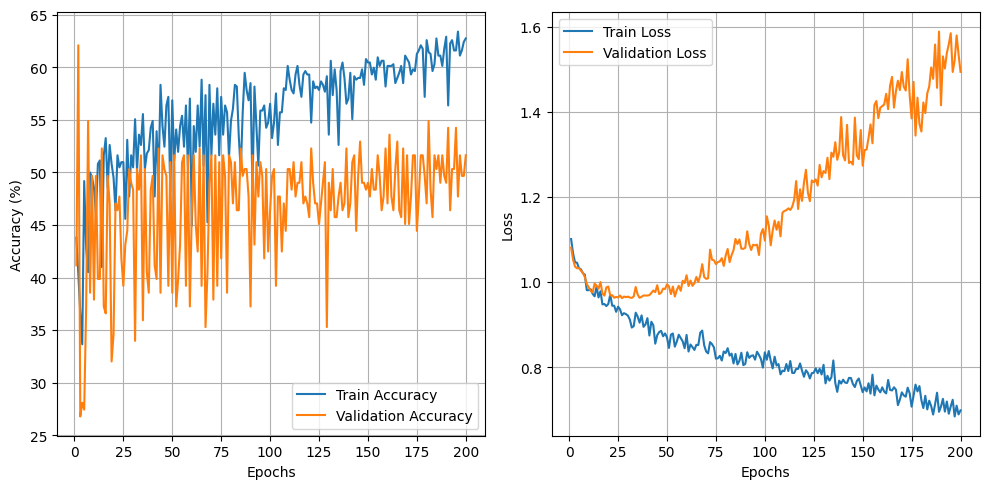

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/representacion_1/longitud_28/CNN1D.png')
plt.show()

***Cargar el modelo :***

In [9]:
model.load_state_dict(torch.load("./Modelos/v2/representacion_1/longitud_28/CNN1D_fold_2.pth"))
model.to(device)
model.eval()

CNN1D(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

***Evaluar el modelo :***

In [10]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

***Matriz de confusión :***

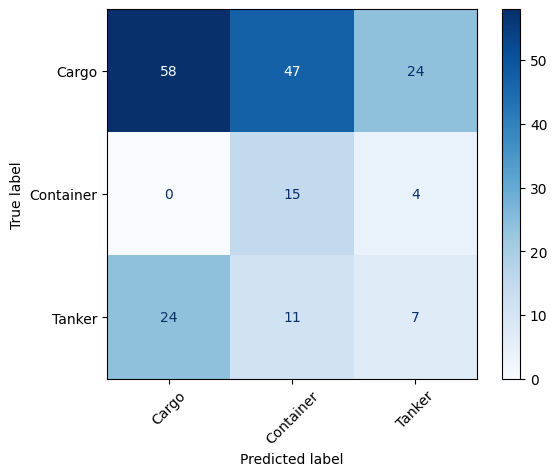

In [11]:
class_names = ['Cargo', 'Container','Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [ ]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v2/representacion_1/longitud_28')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'CNN1D_report.txt', 'w') as f:
    f.write(classification_text)